<a href="https://colab.research.google.com/github/jnofech/phangs_repo/blob/master/galaxies/fancyplot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!curl -s https://course.fast.ai/setup/colab | bash
# ^ Not needed; images save just fine without it!

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# root_dir = "/content/gdrive/My Drive/"
root_dir = "/content/gdrive/Shared drives/PHANGS-Shear/"
base_dir = root_dir #+ 'fastai-v3/'
import os
os.chdir(root_dir)
# Important paths!
import sys
# sys.path.insert(0, '/media/jnofech/BigData/galaxies/')
# sys.path.insert(0, '/media/jnofech/BigData/galaxies/VLA_Lband/')
# sys.path.insert(0, '/media/jnofech/BigData/jnofech_codes/')
# sys.path.insert(0, '/media/jnofech/BigData/')
sys.path.insert(0, '/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/')
sys.path.insert(0, '/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/VLA_Lband/')
sys.path.insert(0, '/content/gdrive/Shared drives/PHANGS-Shear/BigData/jnofech_codes/')
sys.path.insert(0, '/content/gdrive/Shared drives/PHANGS-Shear/BigData/')

# ^ Note that `galaxytools.py`, `rotcurve_tools.py`, `diskfit_input_generator.py`, 
#   and (in 'galaxies/galaxies/') `galaxies.py` need to be edited if the base path
#   ever changes.

Mounted at /content/gdrive


In [0]:
# Run this whenever the runtime is reset on Google Colab!

!pip install corner
!pip install seaborn
!pip install radio_beam
!pip install spectral_cube
!pip install astroquery
!pip install emcee
!pip install reproject

  Created wheel for corner: filename=corner-2.0.1-cp36-none-any.whl size=11643 sha256=e6e364ab777ebde67d5dfccf850c954611b2dcd81ffff199921a859e47c6b71d
  Stored in directory: /root/.cache/pip/wheels/70/d8/e5/e0e7974a2a5757483ea5a180c937041cf6872dc9993d78234a
Successfully built corner
     |████████████████████████████████| 235kB 4.8MB/s 
  Created wheel for radio-beam: filename=radio_beam-0.3.2-cp36-none-any.whl size=74191 sha256=8b8feecd2c8e6b573920502a2dd16a0e5c54ab061bb7a332189cfd53c04c0873
  Stored in directory: /root/.cache/pip/wheels/2d/fd/1d/5b40220501b4f1571e7e2db2fddbcab3f78efc419232a442ef
Successfully built radio-beam
     |████████████████████████████████| 348kB 4.8MB/s 
  Created wheel for spectral-cube: filename=spectral_cube-0.4.4-cp36-none-any.whl size=202523 sha256=7f36d7af94c88ab4a5ed802fa154c1279f1f7d437c1b0cfdcc82588afbbf9fc5
  Stored in directory: /root/.cache/pip/wheels/74/aa/f4/26f26f83cefd9382e181b41b1f51ffe2bedc75fd2c1d371828
Successfully built spectral-cube
    

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import corner
import math

import astropy.io.fits as fits
import astropy.units as u
import astropy.wcs as wcs
from astropy.wcs import WCS
from astropy.table import Table
from astropy.convolution import convolve_fft, Gaussian2DKernel
from astropy.coordinates import SkyCoord, Angle, FK5
from spectral_cube import SpectralCube, Projection, BooleanArrayMask
from radio_beam import Beam
from galaxies.galaxies import Galaxy

from scipy import ndimage, misc, interpolate, signal, optimize
from scipy.interpolate import BSpline, make_lsq_spline
from scipy.stats import binned_statistic
import scipy.stats as stats
from pandas import DataFrame, read_csv
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.gridspec as gridspec

from itertools import count, cycle

import copy
import os.path
from importlib import reload
import operator

# Import Eric's plotting defaults
import sys
sys.path.insert(0, 'VLA_Lband/')
import plotting_styles as ps

# Import Jiayi's code for Alpha
from AlmaTools import XCO

# Import my own code
import rotcurve_tools as rc
import galaxytools as tools
import diskfit_input_generator as dig


# Import silencer
import os, sys
class silence:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
#with silence():
#    print("This will not be printed")


ignorewarnings = True

if ignorewarnings==True:
    import warnings
    warnings.filterwarnings("ignore")
else:
    import warnings
    warnings.resetwarnings()

# Plotting Settings

In [0]:
# Plotting settings, including
#    - PNG/PDF
#    - marker size, edgecolor, edgewidth

extension = '.png'
ms = 7          # markersize, or ms
mec = 'black'   # markeredgecolor, or mec
mew = 0.5       # markeredgewidth, or mew


# Largely unused(?):
from mpl_toolkits.axes_grid1 import make_axes_locatable
def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.15)
    return fig.colorbar(mappable, cax=cax)

In [0]:
# Plotting settings, including
#   - Eric's plotting defaults (ps)
#   - Colour palette
#   - Text size, image width, title toggles, legend simplification
#   - radii normalization in images (with respect to Re)
#   - Other plotting styles

# Eric's plotting defaults
# ps.default_figure()

# Color palette
# matplotlib.rc('image',cmap='rocket')      # Default from sns
matplotlib.rc('image',cmap='rocket_r')    # Inverted default

# My plotting settings
textsize = 20           # 25 by default; roughly appropriate for journals.
base_width = 5.5        # Width of single-panel image; 5.5 for first draft
showtitle = False       # Toggles title display in most (all?) images
simple_legend = True    # Text in legends is shortened or removed, where applicable
rad_normalize = False   # Toggles whether to normalize radii with Re in images

# Plotting style (axis tick size/direction, etc.)
# plt.style.use('/home/jnofech/.config/matplotlib/stylelib/paper_detailed.mplstyle')
# plt.style.use('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/MatPlotLib style/paper_detailed.mplstyle')
# ^ http://www.turnermoni.ca/python3.html
# matplotlib.rcParams.update({'font.size': textsize})
# plt.rc('xtick', labelsize='small')
# plt.rc('ytick', labelsize='small')
# plt.rc('font',family='serif')

# Plot Functions

In [0]:
# Display warnings on images if rotcurve or SFR are missing; or if inclination uses Philipp's value
#   (i.e. if DiskFit returned 18.19deg)

def p_error(vrot_s_check=False,sfr_check=False,size=20, ax=None):
    if ax is None:
        ax = plt.gca()
#   check vrot_s
    if vrot_s_check==True and False==True:
        if np.sum(~np.isnan(vrot_s(R)))==0:
            ax.text(0.03,0.12,'URC failed.',size=size,ha='left',va='bottom',transform=ax.transAxes)
#   check inclination
        if name in galaxies_lowincl and False==True:
            ax.text(0.03,0.03,'Uses P.Lang\'s \'i\'.',size=size,ha='left',va='bottom',transform=ax.transAxes)
#   check sfr
    if sfr_check==True:
        if np.sum(~np.isnan(sfr))==0:
            ax.text(0.20,0.5,'No SFR map.',size=size)

### Plotting: anything without convolution
#### (saves to `fancyplot/` and folders therein)

In [0]:
# 1D Rotation curve (DiskFit raw output, URC, LSQurc, and MCurc)
def p_vrot(save=True, ax=None,alphamult=0.3,show_urc=False,show_lsq=True,show_mc=False):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
        
    if vrot_mom1 is not None and rad is not None and index_wide is not None:
        ax.plot(rad_full[index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                vrot_mom1[index_narrow],'k.',alpha=0.05*alphamult,\
                label=(simple_legend==False)*('mom1 (major axis)'))
        ax.plot(rad_full[index_wide&~index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                vrot_mom1[index_wide&~index_narrow],'k+',mew=0.7,alpha=0.06*alphamult,\
                label=(simple_legend==False)*('mom1 (other)'))
    else:
        raise ValueError('p_vrot() - this shouldn\'t ever happen')
        
    (_,cap1,_) = ax.errorbar(R_e*u.pc/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                             vrot(R_e),yerr=vrot_e, fmt='',\
                 label=(simple_legend==False)*('Rotation Curve ('+data_mode+' '+mapmode+')')\
                      +(simple_legend==True)*('DiskFit'),\
                 c='red',alpha=0.5,capsize=5)
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)
    if show_urc==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_s(R),c='r',linestyle=':', label=(simple_legend==False)*(''+smooth+' fit')\
                                                           +(simple_legend==True)*(smooth))
    if show_lsq==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_lsq(R),c='b',linestyle='--', label=(simple_legend==False)*('LSQ-sampled '+smooth+' fit')\
                                                              +(simple_legend==True)*('LSQ'))
    if show_mc==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_mc(R),c='g',linestyle='--', label=(simple_legend==False)*('MC-sampled '+smooth+' fit')\
                                                              +(simple_legend==True)*('MC'))
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*'~(kpc)',size=textsize)
    ax.set_ylabel('$v_\mathrm{rot}$~(km/s)',size=textsize)
    ax.set_ylim(np.nanmin([vrot(R_e).min(),vrot_s(R).min()])-50,np.nanmax([vrot(R_e).max(),vrot_s(R).max()])+50)
    if showtitle==True:
        ax.set_title('Rotation Curve of '+name.upper(),size=textsize)
    plt.tight_layout()
    if name.lower()=='ngc5068':
        ax.set_ylim([-20,100])
    for cap in cap1:
        #cap.set_color('k')
        cap.set_markeredgewidth(1)
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    ax.legend(loc='best')
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurves/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_vrot'+extension, bbox_inches='tight')

# Same as above, but modified to be more suitable for the 3-panel plots. Can include spline fits
def p_vrot_3panel_rotcurves(save=True, ax=None, show_table=False,\
                            showspline=False,show_urc=False,show_lsq=False,show_mc=False,knots=-1,alphamult=1):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    (_,cap1,_) = ax.errorbar(R_e*u.pc/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                             vrot(R_e),yerr=vrot_e, fmt='',\
                 label=(simple_legend==False)*('Rotation Curve ('+data_mode+' '+mapmode+')')\
                      +(simple_legend==True)*('DiskFit'),\
                 c='red',alpha=0.5,capsize=5)
        
    if vrot_mom1 is not None and rad is not None and index_wide is not None:
        ax.plot(rad_full[index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                vrot_mom1[index_narrow],'k.',alpha=0.05*alphamult,\
                label=(simple_legend==False)*('mom1 (major axis)'))
        ax.plot(rad_full[index_wide&~index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                vrot_mom1[index_wide&~index_narrow],'k+',mew=0.7,alpha=0.06*alphamult,\
                label=(simple_legend==False)*('mom1 (other)'))
    else:
        print('LALALALAL')
        
    if showspline==True:
        R_spl,vrot_spl,knots = rc.RC(gal,data_mode,mode='spline',knots=knots,returnknots=True)
        ax.plot(R_spl/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                vrot_spl(R_spl),c='blue',label=(simple_legend==False)*('Spline, '+str(knots)+' knots')\
                                                    +(simple_legend==True)*(str(knots)+' knots'))
    if show_urc==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_s(R),c='r',linestyle=':', label=(simple_legend==False)*(''+smooth+' fit')\
                                                           +(simple_legend==True)*(smooth))
    if show_lsq==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_lsq(R),c='b',linestyle='--', label=(simple_legend==False)*('LSQ-sampled '+smooth+' fit')\
                                                              +(simple_legend==True)*('LSQ'))
    if show_mc==True:
        ax.errorbar(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                    vrot_mc(R),c='g',linestyle='--', label=(simple_legend==False)*('MC-sampled '+smooth+' fit')\
                                                              +(simple_legend==True)*('MC'))
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*'~(kpc)',size=textsize)
    ax.set_ylabel('$v_\mathrm{rot}$~(km/s)',size=textsize)
    ax.set_ylim(np.max([np.min([vrot(R).min()-25,0,np.nanpercentile(vrot_mom1,5.0)]),-450]),np.min([np.max([vrot(R).max()+25,0,np.nanpercentile(vrot_mom1,95.0)]),600]))
    if showtitle==True:
        ax.set_title('Rotation Curve of '+name.upper(),size=textsize)
    plt.tight_layout()
    if name.lower()=='ngc5068':
        ax.set_ylim([-20,100])
    for cap in cap1:
        #cap.set_color('k')
        cap.set_markeredgewidth(1)
    ax.legend(loc='best')
    # Create the table of parameters, if params are given!
    if ~np.isnan(PA_orig*PA_fit*incl_orig*incl_fit*vsys_orig*vsys_fit) and show_table==True:
        col_labels=['Original','Fitted']
        row_labels=['PA','incl','vsys ($km/s$)']
        table_vals=[["{0:4.1f}".format(PA_orig.value),"{0:4.1f}".format(PA_fit.value)],\
                    ["{0:4.1f}".format(incl_orig.value),"{0:4.1f}".format(incl_fit.value)],\
                    ["{0:4.1f}".format(vsys_orig.value),"{0:4.1f}".format(vsys_fit.value)]]
        the_table = plt.table(cellText=table_vals,
                      colWidths = [0.12]*2,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      loc='lower center')
        the_table.scale(1.3,1.8)
    
# Oort A vs R
def p_a(save=True, ax=None):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    ax.plot(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
            A(R), label=(simple_legend==False)*('Local Shear Parameter (Oort A)'))
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    ax.legend(loc='best')
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*'~(kpc)',size=textsize)
    ax.set_ylabel('Oort A $\mathrm{(km/s/kpc)}$',size=textsize)
    if showtitle==True:
        ax.set_title('Shear Parameter of '+name.upper(),size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/oortA/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_oortA'+extension, bbox_inches='tight')
    
# Oort B vs R
def p_b(save=True, ax=None):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    ax.plot(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
            B(R), label=(simple_legend==False)*('Oort B'))
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    ax.legend(loc='best')
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
    ax.set_ylabel('Oort B $\mathrm{(km/s/kpc)}$',size=textsize)
    if showtitle==True:
        ax.set_title('Oort B of '+name.upper(),size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/oortB/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_oortB'+extension, bbox_inches='tight')

# \\beta vs R
def p_beta(save=True, ax=None):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    ax.plot(rad1D.to(u.pc)/1000. * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
            beta1D, label=(simple_legend==False)*('$\\beta$'))
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    ax.legend(loc='best')
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (pc)',size=textsize)
    ax.set_ylabel('$\\beta$',size=textsize)
    if showtitle==True:
        ax.set_title('$\\beta$ for '+name.upper(),size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/beta/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_beta'+extension, bbox_inches='tight')

# k vs R
def p_k(c=None,save=True, ax=None):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    ax.plot(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
            k(R), c=c, label=(simple_legend==False)*('Epicyclic Frequency'))
    ax.legend(loc='best')
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
    ax.set_ylabel('$\kappa$~(km/s/pc)',size=textsize)
    if showtitle==True:
        ax.set_title('Epicyclic Frequency of '+name.upper(),size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/epicycles/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_k'+extension, bbox_inches='tight')
         
# Plotting vobs map. (MODEL LoS Velocity, from best available 'smoothed' URC (i.e. URC, LSQurc, or MCurc))
def p_vobs(save=True,\
           show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(vobs.value,origin='lower')
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{obs}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$v_\mathrm{obs}$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(vrot_s_check=True,size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/vobs/'+str(name)+'_vobs_'+data_mode+extension, bbox_inches='tight')
        
# Plotting the mom1 (broad) map.
def p_vmom1(save=True,\
           show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(I_mom1_broad)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$mom1$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/mom1/'+str(name)+'_mom1_'+data_mode+extension, bbox_inches='tight')
        
# Plotting the mom1 map, with radius contours.
#   (This is only used in the "Main Loop^{TM}"; this function itself doesn't 
#   appear in the multipanel image functions.)
def p_vmom1_with_radii(save=True,\
                       show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(I_mom1_broad)
    im2 = ax.contour(rad_full,levels=np.linspace(0,20000,21))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$mom1$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/mom1-with-radii/'+str(name)+'_mom1-with-radii_'+data_mode+extension, bbox_inches='tight')

# Plotting the vpeak map.
def p_vpeak(save=True,\
            show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(vpeak)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('Peak Velocity (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('Peak Velocity Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/vpeak/'+str(name)+'_vpeak_'+data_mode+extension, bbox_inches='tight')

# Plotting the (mom1-vpeak) map.
def p_veldiff(save=True,\
              show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(I_mom1_broad-vpeak)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ - $v_\mathrm{peak}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('($mom1$ - vpeak) of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/mom1-vpeak/'+str(name)+'_mom1-vpeak_'+data_mode+extension, bbox_inches='tight')
        
# Plotting the RESIDUALS between "model" vrot and the mom1 map.
def p_residual(save=True,\
               show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(I_mom1_broad-vobs.value)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$-$v_\mathrm{obs}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('Residuals of $mom1$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(vrot_s_check=True,size=textsize)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_maps/mom1-vobs/'+str(name)+'_mom1-vobs_'+data_mode+extension, bbox_inches='tight')

# sigma_gal (i.e. kappa * R_cloud)
def p_sigma_gal(save=True,\
                show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(sigma_gal(rad), vmax=np.max([np.nanpercentile(sigma,99),np.nanpercentile(sigma_gal(rad),99)]))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$\sigma_\mathrm{gal}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$\sigma_\mathrm{gal}$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/velocity_dispersions/'+str(name)+'_sigma_gal'+extension, bbox_inches='tight')

# Plotting the average noise map.
#   Yes, this is technically convolvable, but I won't do it out of simplicity.
def p_noise(save=True,\
            show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(noise,\
               vmin = np.nanpercentile(noise,1.0),\
               vmax = np.nanpercentile(noise,99.0))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('Noise (K)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('Noise Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/noise/'+str(name)+'_noise'+extension, bbox_inches='tight')
#         plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'noise/'+str(name)+'_noise_'+conbeam_filename+extension, bbox_inches='tight')   #<-- Convolved version

### Plotting: anything WITH convolution
#### (saves to `fancyplot/convolved/` and folders therein)
#### (saves to `fancyplot/` if conbeam is `None`)

In [0]:
# Plotting the mom0 map.
def p_mom0(save=True,\
           show_x=True,show_y=True,
           vmax_percentile=98):
    ax = plt.subplot(projection=world)
    im = ax.imshow(I_mom0, vmax = np.nanpercentile(I_mom0,vmax_percentile), vmin=0)
    if conbeam in [0,0*u.pc,np.nan,None]:
        ax.text(0.03,0.03,'Not convolved.',size=textsize,ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$W_\mathrm{CO}$ (K km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    #     lon.set_ticks_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    #     lat.set_ticks_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$mom0$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'mom0/'+str(name)+'_mom0_'+conbeam_filename+extension, bbox_inches='tight')

# Plotting the Sigma (molecular surface density) map.
def p_Sigma(save=True,\
           show_x=True,show_y=True,
           vmax_percentile=98):
    ax = plt.subplot(projection=world)
    im = ax.imshow(Sigma, vmax = np.nanpercentile(Sigma,vmax_percentile), vmin=0)
    if conbeam in [0,0*u.pc,np.nan,None]:
        ax.text(0.03,0.03,'Not convolved.',size=textsize,ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$\Sigma$ ($M_\odot~\mathrm{pc}^{-2}$)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    #     lon.set_ticks_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    #     lat.set_ticks_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$\Sigma$ Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'Sigma/'+str(name)+'_Sigma_'+conbeam_filename+extension, bbox_inches='tight')

# Plotting the tdep map.
def p_tdep(save=True,\
           show_x=True,show_y=True,
           vmax_percentile=100):
    ax = plt.subplot(projection=world)
    logdepletion = np.log10(depletion)
    logdepletion = (~np.isinf(logdepletion))*logdepletion
    im = ax.imshow(logdepletion, vmax = np.nanpercentile(logdepletion,vmax_percentile))
    if conbeam in [0,0*u.pc,np.nan,None]:
        ax.text(0.03,0.03,'Not convolved.',size=textsize,ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('log($_{10} \\tau_\mathrm{dep}$) (yr)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    #     lon.set_ticks_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    #     lat.set_ticks_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('log($_{10} \\tau_\mathrm{dep}$) Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletion_map/'+str(name)+'_tdep_'+conbeam_filename+extension, bbox_inches='tight')   

# Plotting the tff (freefall) map.
def p_tff(save=True,\
           show_x=True,show_y=True,
           vmax_percentile=100):
    ax = plt.subplot(projection=world)
    logfreefall = np.log10(freefall)
    logfreefall = (~np.isinf(logfreefall))*logfreefall
    im = ax.imshow(logfreefall, vmax = np.nanpercentile(logfreefall,vmax_percentile))
    if conbeam in [0,0*u.pc,np.nan,None]:
        ax.text(0.03,0.03,'Not convolved.',size=textsize,ha='left',va='bottom',transform=ax.transAxes)
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('log($_{10} \\tau_\mathrm{ff}$) (yr)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    #     lon.set_ticks_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    #     lat.set_ticks_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('log($_{10} \\tau_\mathrm{ff}$) Map of '+name.upper(),size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'freefall_map/'+str(name)+'_tff_'+conbeam_filename+extension, bbox_inches='tight')

# sigma_gal vs. sigma   (i.e. kappa*R_cloud vs. velocity dispersion)
#   (sigma_gal takes cloud scale to be the size of the beam. That... doesn't sound quite right?)
def p_sigmasigma():
    if np.sum(~np.isnan(sigma1D))!=0 and np.sum(~np.isnan(sigma_gal1D))!=0:
        corner.hist2d(sigma1D[~np.isnan(sigma1D*sigma_gal1D)],sigma_gal1D[~np.isnan(sigma1D*sigma_gal1D)],\
                      plot_density=True, plot_contours=True, plot_datapoints=True)
    else:
        plt.plot(sigma1D[~np.isnan(sigma1D*sigma_gal1D)],sigma_gal1D[~np.isnan(sigma1D*sigma_gal1D)],'.')
    p_error(vrot_s_check=True,size=textsize)
    plt.xlabel('$\sigma_\mathrm{obs}$ (observed)',size=textsize)
    plt.ylabel('$\sigma_\mathrm{gal}=\kappa \mathrm{R_c}$',size=textsize)
    if showtitle==True:
        plt.title('Line Width Correlation of '+name.upper()+conv_title_suffix,size=textsize)
    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'velocity_dispersions_convolved/'+str(name)+'_sigmasigma'+conbeam_filename+extension, bbox_inches='tight')
        
# sigma  (i.e. velocity dispersion)
def p_sigma_obs(save=True,\
                show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(sigma,\
               vmax=np.max([np.nanpercentile(sigma,99),np.nanpercentile(sigma_gal(rad),99)]))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$\sigma_\mathrm{obs}$ (km/s)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$\sigma_\mathrm{obs}$ Map of '+name.upper()+conv_title_suffix,size=textsize)
    fig.set_size_inches(base_width,base_width)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'velocity_dispersions_convolved/'+str(name)+'_sigma_obs'+conbeam_filename+extension, bbox_inches='tight')

# sigma_gal / sigma   (i.e. kappa*R_cloud / velocity dispersion)
def p_ratio(save=True,\
            show_x=True,show_y=True):
    ratio = sigma_gal(rad) / sigma
    ax = plt.subplot(projection=world)
    im = ax.imshow(ratio, vmin=0,vmax=np.nanpercentile(ratio[np.isfinite(ratio)],95))
    if np.nanmin(ratio)<0:
        print("WARNING: For sigma ratio (p_ratio()), vmin is arbitrarily set to zero as some negatives exist.\
                \nNeeds a better solution-- there should be no negatives!")
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$\sigma_\mathrm{gal}/\sigma_\mathrm{obs}$',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$\sigma_\mathrm{gal}/\sigma_\mathrm{obs}$ Map of '+name.upper()+conv_title_suffix,size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(vrot_s_check=True,size=textsize,ax=ax)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'velocity_dispersions_convolved/'+str(name)+'_sigma_ratio'+conbeam_filename+extension, bbox_inches='tight')

# SFR
def p_sfr(save=True,\
          show_x=True,show_y=True):
    ax = plt.subplot(projection=world)
    im = ax.imshow(sfr, vmin=0, vmax=np.percentile(sfr,98.5))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('SFR (M$_\odot$/kpc$^2$/yr)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$SFR$ Map ('+sfr_best+') of '+name.upper()+' \n($M_\odot /yr /kpc^2$)'+conv_title_suffix,size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(sfr_check=True,size=textsize,ax=ax)
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'sfr/'+str(name)+'_sfr'+conbeam_filename+extension, bbox_inches='tight')
        
# (nuv+w3)-to-(fuv+w4) ratio
# (DEFUNCT)
def p_sfr_ratio(save=True,\
                show_x=True,show_y=True):
    # Not needed? Only experimental.
    sfr_ratio = sfr_nuvw3/sfr_fuvw4
    ax = plt.subplot(projection=world)
    im = ax.imshow(sfr_ratio, \
                   vmin=np.percentile(sfr_ratio,1.5), vmax=np.percentile(sfr_ratio,98.5))
    ax.set_xlabel('RA',size=textsize)
    ax.set_ylabel('Dec',size=textsize)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('SFR (nuv+w3) / SFR (fuv+w4)',size=textsize)
    lon = ax.coords[0]
    lat = ax.coords[1]
    if show_x==False:
        lon.set_ticklabel_visible(False)
    if show_y==False:
        lat.set_ticklabel_visible(False)
    fig = plt.gcf()
    if showtitle==True:
        plt.title('$SFR_\mathrm{nuv+w3}/SFR_\mathrm{fuv+w4}$ of '+name.upper()+','+conv_title_suffix,size=textsize)
    fig.set_size_inches(base_width,base_width)
    
#     Display error when sfr is missing
    if np.sum(~np.isnan(sfr_nuvw3))==0:
        plt.figtext(0.20,0.5,'Missing nuv+w3 SFR map.',size=25)
    if np.sum(~np.isnan(sfr_fuvw4))==0:
        plt.figtext(0.20,0.55,'Missing fuv+w4 SFR map.',size=25)
            
    plt.tight_layout()
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'sfr/ratio/'+str(name)+'_sfr_ratio_nuvw3-to-fuvw4_'+conbeam_filename+extension, bbox_inches='tight')

# Plots tdep-vs-R AND beta-vs-R.
def p_depletion_and_beta(mode='best',mode2='',knots=-1,save=True, ax=None,alphamult=1,\
                         show_bestrotcurve=False):
    '''
    mode='diskfit' : str
        - "spline"            : x from spline-smoothed rotcurve (must be generated beforehand).
        - "smooth(ed)"/"URC"  : x from URC-smoothed rotcurve.
        - "LSQurc" : x from final, lsq-improved rotcurve.
        - "MCurc"  : x from final, MC-improved rotcurve (different method).
        - "best"    : x from best available MC, LSQ, or smoothed URC (in order of descending accuracy).
    mode2='' : str
        Same as 'mode' if you want to compare
        beta curves.
    knots : int
        Number of knots if mode=='spline'.
    alphamult : float
        Multiplier for tdep map opacity.
    '''
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    # Find characteristic radius, and depletion time around that region
    Re    = tools.Re_get(name).to(u.pc)
    index = np.abs(rad - Re) < 0.5*u.kpc
    depletion_Re = np.nanmean(depletion[index])
        
    if depletion is not None and rad is not None and index_wide is not None:
        ax.plot(rad_full[index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                np.log10(depletion[index_narrow]),'k.',alpha=0.05*alphamult,\
                label=(simple_legend==False)*('strict depletion (major axis)'))
        ax.plot(rad_full[index_wide&~index_narrow]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                np.log10(depletion[index_wide&~index_narrow]),'k+',mew=0.7,alpha=0.06*alphamult,\
                label=(simple_legend==False)*('strict depletion (other)'))
#         # Plots a big "X" for depletion time at the characteristic radius
#         ax.plot(Re/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
#                 np.log10(depletion_Re),'kX',mew=0.7,alpha=0.7,\
#                 label='$\\tau_\mathrm{dep}(R_\mathrm{e})$')
    else:
        raise ValueError('p_depletion_and_beta() : This should never happen')
#     ax.legend(loc='best')
        
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)
    ax.set_xlabel('R'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
    ax.set_ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
#     ax.set_ylim(np.nanmin(depletion),np.nanmax(depletion))
    ax.set_ylim(8.4,10.2)
    
    ax2 = ax.twinx()
    ax2.set_ylabel('$\\beta$')
    ax2.tick_params('y',color='blue')
    if showtitle==True:
        ax.set_title('Depletion-vs-Radius, for '+name.upper(),size=textsize)
    if mode.lower() in ['spline','spl']:
        R,vrot_spl,knots = rc.RC(gal,data_mode,mode=mode,knots=knots,returnknots=True)
    else:
        R,vrot_spl = rc.RC(gal,data_mode,mode=mode,knots=knots)        
    ax2.plot(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
             rc.beta(R,vrot_spl)(R),'b',label=show_bestrotcurve*(mode+' ')+'$\\beta$')
    if mode2!='':
        if mode2.lower() in ['spline','spl']:
            R,vrot_spl2,knots = rc.RC(gal,data_mode,mode=mode2,knots=knots,returnknots=True)
        else:
            R,vrot_spl2 = rc.RC(gal,data_mode,mode=mode2,knots=knots) 
        ax2.plot(R/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./tools.Re_get(name).to(u.pc)))),\
                 rc.beta(R,vrot_spl2)(R),'b:',label='$\\beta$ ('+str(knots)+' knots)')
    plt.tight_layout()
    p_error(sfr_check=True,vrot_s_check=True,size=textsize,ax=ax)
    ax2.legend(loc='best')
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletion-vs-R/'+str(name)+'_depletion1D_'+conbeam_filename+extension, bbox_inches='tight')

# tdep vs. (kappa*R_cloud / velocitydispersion)
def p_depletion_vs_ratio(hist_xbins=25,hist_ybins=25):
    ratio = sigma_gal(rad) / sigma
    # Sigma is in Msun / pc^2.
    # SFR is in Msun / kpc^2 / yr.
    depletion = Sigma/(u.pc.to(u.kpc))**2/sfr
    if np.sum(~np.isnan(np.log10(ratio)))!=0 and np.sum(~np.isnan(np.log10(depletion)))!=0:
        corner.hist2d(np.log10(ratio)[np.isfinite(np.log10(ratio)*np.log10(depletion))],\
                      np.log10(depletion)[np.isfinite(np.log10(ratio)*np.log10(depletion))],\
                      plot_density=True, plot_contours=True, plot_datapoints=True,\
                      bins=[hist_xbins,hist_ybins])
    else:
        plt.plot(np.log10(ratio)[np.isfinite(np.log10(ratio)*np.log10(depletion))],\
                 np.log10(depletion)[np.isfinite(np.log10(ratio)*np.log10(depletion))],'.')
    fig = plt.gcf()
    if showtitle==True:
        plt.title('Depletion Time ('+sfr_best+') vs Line Width Ratio, \nfor '+name.upper()+conv_title_suffix,size=textsize)
    fig.set_size_inches(base_width,base_width)
    p_error(sfr_check=True,size=textsize)
    
    plt.ylim(8.4,10.2)
    
    plt.xlim([-1.3,1.3])
    plt.ylim([7.5,10.3])
    plt.xlabel('log($\sigma_\mathrm{gal}/\sigma_\mathrm{obs}$)',size=textsize)
    plt.ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/depletion-sigmaratio/'\
                +str(name)+'_depletion_vs_ratio'+conbeam_filename+extension, bbox_inches='tight')
    
# tdep vs. A
def p_depletion_vs_A(save=True, ax=None,\
                        hist_xbins=25,hist_ybins=25):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,base_width)
        plt.tight_layout()
    # k is in km/s/kpc
    # Depletion is in yr.
    if np.sum(~np.isnan(A(rad)))!=0 and np.sum(~np.isnan(np.log10(depletion)))!=0:
        corner.hist2d(A(rad)[np.isfinite(A(rad)*np.log10(depletion))],\
                      np.log10(depletion)[np.isfinite(A(rad)*np.log10(depletion))],\
                      plot_density=True, plot_contours=True, plot_datapoints=True,\
                      bins=[hist_xbins,hist_ybins],ax=ax)
    else:
        ax.plot(A(rad)[np.isfinite(A(rad)*np.log10(depletion))],\
                 np.log10(depletion)[np.isfinite(A(rad)*np.log10(depletion))],'.')
    if showtitle==True:
        ax.set_title('Depletion Time ('+sfr_best+') vs Shear Parameter ('+smooth+'), \nfor '\
                  +name.upper()+conv_title_suffix,size=textsize)
    p_error(vrot_s_check=True,sfr_check=True,size=textsize,ax=ax)
    
    plt.ylim(8.4,10.2)

    ax.set_xlabel('Oort A  (km/s/kpc)',size=textsize)
    ax.set_ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/depletion-oortA/'+smooth+'/'+data_mode+'_'+mapmode+'_'\
                +str(name)+'_depletion_vs_A'+conbeam_filename+extension, bbox_inches='tight') 

# tdep vs. B
def p_depletion_vs_B(save=True, ax=None,\
                        hist_xbins=25,hist_ybins=25):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,base_width)
        plt.tight_layout()
    # k is in km/s/kpc
    # Depletion is in yr.
    if np.sum(~np.isnan(B(rad)))!=0 and np.sum(~np.isnan(np.log10(depletion)))!=0:
        corner.hist2d(B(rad)[np.isfinite(B(rad)*np.log10(depletion))],\
                      np.log10(depletion)[np.isfinite(B(rad)*np.log10(depletion))],\
                      plot_density=True, plot_contours=True, plot_datapoints=True, \
                      bins=[hist_xbins,hist_ybins],ax=ax)
    else:
        ax.plot(B(rad)[np.isfinite(B(rad)*np.log10(depletion))],\
                 np.log10(depletion)[np.isfinite(B(rad)*np.log10(depletion))],'.')
    if showtitle==True:
        ax.set_title('Depletion Time ('+sfr_best+') vs Oort B ('+smooth+'), \nfor '\
                  +name.upper()+conv_title_suffix,size=textsize)
    p_error(vrot_s_check=True,sfr_check=True,size=textsize,ax=ax)
    
    plt.ylim(8.4,10.2)

    ax.set_xlabel('Oort B  (km/s/kpc)',size=textsize)
    ax.set_ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/depletion-oortB/'+smooth+'/'+data_mode+'_'+mapmode+'_'\
                +str(name)+'_depletion_vs_oortB'+conbeam_filename+extension, bbox_inches='tight')

# tdep vs beta
def p_depletion_vs_beta(save=True, ax=None,\
                        hist_xbins=25,hist_ybins=25):
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,base_width)
        plt.tight_layout()
    if np.sum(~np.isnan(beta1D))!=0 and np.sum(~np.isnan(logdepletion1D))!=0:
        corner.hist2d(beta1D,logdepletion1D,\
                      plot_density=True, plot_contours=True, plot_datapoints=True, \
                      bins=[hist_xbins,hist_ybins],ax=ax)
    else:
        ax.plot(beta1D,logdepletion1D,'.')
    if showtitle==True:
        ax.set_title('Depletion Time ('+sfr_best+') vs Dimensionless Rotation Curve ('+smooth+'), \nfor '+name.upper()\
                  +conv_title_suffix,size=textsize)
    p_error(vrot_s_check=True,sfr_check=True,size=textsize,ax=ax)
    
    # Only take data from 0.5th to 99th percentiles!
    if np.sum(~np.isnan(beta1D))!=0:
        plt.xlim(np.percentile(beta1D,0.5),np.percentile(beta1D,99.5))
    if np.sum(~np.isnan(logdepletion1D))!=0:
#         plt.ylim(np.percentile(logdepletion1D,0.5),np.percentile(logdepletion1D,99.5))
        plt.ylim(8.4,10.2)
    ax.set_xlabel('$\\beta$ ($\mathrm{R/V *dV/dR}$)',size=textsize)
    ax.set_ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/depletion-beta/'+smooth+'/'+data_mode+'_'+mapmode+'_'\
                +str(name)+'_depletion_vs_beta'+conbeam_filename+extension, bbox_inches='tight')

In [0]:
# 9-panel collage, showing 'methods'

def p_collage_RCderivs():

    fig = plt.figure(figsize=(1.45*base_width,2.09*base_width))

    Nrows = 5
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)

    # mom1
    sub_mom1 = fig.add_subplot(G[0,0], projection=world)
    im = sub_mom1.imshow(I_mom1_broad)
    sub_mom1.set_xlabel('RA')
    sub_mom1.set_ylabel('Dec')
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    sub_mom1.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_mom1.transAxes)

    # sfr
    sub_sfr  = fig.add_subplot(G[0,1], projection=world)
    im2 = sub_sfr.imshow(sfr,vmin=0,vmax=np.nanpercentile(sfr,99))
    sub_sfr.set_xlabel('RA')
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('SFR (M$_\odot$/kpc$^2$/yr)',size=textsize)
    lon = sub_sfr.coords[0]
    lat = sub_sfr.coords[1]
    lat.set_ticklabel_visible(False)
    sub_sfr.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_sfr.transAxes)

    # RC
    sub_RC = fig.add_subplot(G[1,:])
    p_vrot(save=False,ax=sub_RC)
    sub_RC.text(0.03/2,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_RC.transAxes)
    # A
    suba  = fig.add_subplot(G[2,0])
    p_a(save=False,ax=suba)
    suba.set_xticks([])
    suba.set_xlabel('\_')
    subat = fig.add_subplot(G[2,1])
    p_depletion_vs_A(save=False,ax=subat)
    suba.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=suba.transAxes)
    subat.text(0.03,0.97,'e)',size=textsize,ha='left',va='top',transform=subat.transAxes)
    # B
    subb  = fig.add_subplot(G[3,0])
    p_b(save=False,ax=subb)
    subb.set_xticks([])
    subb.set_xlabel('\_')
    subbt = fig.add_subplot(G[3,1])
    p_depletion_vs_B(save=False,ax=subbt)
    subb.text(0.03,0.97,'f)',size=textsize,ha='left',va='top',transform=subb.transAxes)
    subbt.text(0.03,0.97,'g)',size=textsize,ha='left',va='top',transform=subbt.transAxes)
    # beta
    subbeta  = fig.add_subplot(G[4,0])
    p_beta(save=False,ax=subbeta)
    subbetat = fig.add_subplot(G[4,1])
    p_depletion_vs_beta(save=False,ax=subbetat)
    subbeta.text(0.03,0.97,'h)',size=textsize,ha='left',va='top',transform=subbeta.transAxes)
    subbetat.text(0.03,0.97,'i)',size=textsize,ha='left',va='top',transform=subbetat.transAxes)

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/collage_RCderivs/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')

In [0]:
#### Figure 2.1 - 4-panel image
# a) mom0 (Convolved)
# b) mom1
# c) w1 (Not convolved)
# d) SFR, corrected (Convolved)
# ^ The choice of 'convolved'/'not-convolved' are to reflect the data that we're actually doing calculations with.

def p_4panel_maps(base_width=16.5):
    
    fig = plt.figure(figsize=(base_width,base_width*aspect))

    Nrows = 2
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)

    sub_mom0 = fig.add_subplot(G[0,0], projection=world)
    im = sub_mom0.imshow(I_mom0,vmin=0,vmax=np.nanpercentile(I_mom0,98.))
    if showtitle==True:
        sub_mom0.set_title('$W_\mathrm{CO}$')
    lon = sub_mom0.coords[0]
    lat = sub_mom0.coords[1]
    lon.set_ticklabel_visible(False)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$W_\mathrm{CO}$ (K km/s)',size=textsize)
    sub_mom0.set_xlabel('RA')
    sub_mom0.set_ylabel('Dec')
    sub_mom0.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_mom0.transAxes)

    sub_mom1 = fig.add_subplot(G[0,1], projection=world)
    im2 = sub_mom1.imshow(I_mom1_broad)
    im2p5 = sub_mom1.contour(rad_full,levels=np.linspace(0,20000,21))
    if showtitle==True:
        sub_mom1.set_title('$v_\mathrm{LOS}$')
    lon = sub_mom1.coords[0]
    lat = sub_mom1.coords[1]
    lat.set_ticklabel_visible(False)
    lon.set_ticklabel_visible(False)
    cbar = plt.colorbar(im2,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    sub_mom1.set_xlabel('RA')
    sub_mom1.set_ylabel('Dec')
    sub_mom1.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_mom1.transAxes)

    sub_wise  = fig.add_subplot(G[1,0], projection=world)
    im3 = sub_wise.imshow(wise1.value,vmin=0,vmax=np.nanpercentile(wise1,99))
    if showtitle==True:
        sub_wise.set_title('WISE1')
    sub_wise.set_xlabel('RA')
    lon = sub_wise.coords[0]
    lat = sub_wise.coords[1]
    cbar = plt.colorbar(im3,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('WISE1 (MJy/sr)',size=textsize)
    sub_wise.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_wise.transAxes)

    sub_sfr  = fig.add_subplot(G[1,1], projection=world)
    im4 = sub_sfr.imshow(sfr,vmin=0,vmax=np.nanpercentile(sfr,99))
    if showtitle==True:
        sub_sfr.set_title('SFR')
    sub_sfr.set_xlabel('RA')
    lon = sub_sfr.coords[0]
    lat = sub_sfr.coords[1]
    lat.set_ticklabel_visible(False)
    cbar = plt.colorbar(im4,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('SFR (M$_\odot$/kpc$^2$/yr)',size=textsize)
    sub_sfr.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_sfr.transAxes)

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_maps/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')

#### Figure 3.3 - 3-panel rotcurve image
# a) mom0 (convolved)
# b) mom1 (BROAD)
# c) rotcurve, with DiskFit and URC fit(s)
def p_3panel_rotcurves(vmax_percentile=98):
    base_width_scale = 1.75
    fig = plt.figure(figsize=(base_width*base_width_scale,base_width*base_width_scale*aspect))

    Nrows = 2
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)

    sub_mom0 = fig.add_subplot(G[0,0], projection=world)
    im = sub_mom0.imshow(I_mom0,vmin=0,vmax=np.nanpercentile(I_mom0,vmax_percentile))
    if showtitle==True:
        sub_mom0.set_title('$W_\mathrm{CO}$')
    if conbeam in [0,0*u.pc,np.nan,None]:
        sub_mom0.text(0.03,0.03,'Not convolved.',size=textsize,ha='left',va='bottom',transform=sub_mom0.transAxes)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$W_\mathrm{CO}$ (K km/s)',size=textsize)
    sub_mom0.set_xlabel('RA')
    sub_mom0.set_ylabel('Dec')
    sub_mom0.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_mom0.transAxes)

    sub_mom1 = fig.add_subplot(G[0,1], projection=world)
    im2 = sub_mom1.imshow(I_mom1_broad)
    im2p5 = sub_mom1.contour(rad_full,levels=np.linspace(0,20000,21))
    if showtitle==True:
        sub_mom1.set_title('$v_\mathrm{LOS}$')
    lon = sub_mom1.coords[0]
    lat = sub_mom1.coords[1]
    lat.set_ticklabel_visible(False)
    cbar = plt.colorbar(im2,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    sub_mom1.set_xlabel('RA')
    sub_mom1.set_ylabel('Dec')
    sub_mom1.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_mom1.transAxes)

    # RC
    sub_RC = fig.add_subplot(G[1,:])
    p_vrot_3panel_rotcurves(save=False,ax=sub_RC,showspline=False,show_lsq=True)
    sub_RC.text(0.015,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_RC.transAxes)

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/3panel_rotcurves/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth\
                +extension, bbox_inches='tight')
    print('fancyplot/3panel_rotcurves/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth\
                +extension)

#### Figure C.1 - 4-panel rotcurve image with LSQ and spline compared
# a) mom1 (BROAD)
# b) tdep (convolved)
# c) rotcurve, with URC and spline fits (and mom1 in background)
# d) beta-vs-R, with URC and spline fits (and tdep in background)
def p_4panel_splinecompare(knots=2):
    basewidth=9
    fig = plt.figure(figsize=(basewidth,basewidth*aspect))

    Nrows = 2
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)
    
    # mom1 with radius
    sub_mom1 = fig.add_subplot(G[0,0], projection=world)
    im1 = sub_mom1.imshow(I_mom1_broad)
    im1p5 = sub_mom1.contour(rad_full,levels=np.linspace(0,20000,21))
    if showtitle==True:
        sub_mom1.set_title('$v_\mathrm{LOS}$')
    cbar = plt.colorbar(im1,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    sub_mom1.set_xlabel('RA')
    sub_mom1.set_ylabel('Dec')
    sub_mom1.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_mom1.transAxes)
    
    # tdep    
    sub_tdep = fig.add_subplot(G[0,1], projection=world)
    im2 = sub_tdep.imshow(np.log10(depletion),vmin=8.2,vmax=9.8)
    if showtitle==True:
        sub_tdep.set_title('$\\tau_\mathrm{dep}$')
    lon = sub_tdep.coords[0]
    lat = sub_tdep.coords[1]
    lat.set_ticklabel_visible(False)
    cbar = plt.colorbar(im2,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$\\tau_\mathrm{dep}$ (yr)',size=textsize)
    sub_tdep.set_xlabel('RA')
    sub_tdep.set_ylabel('Dec')
    sub_tdep.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdep.transAxes)

    # RC
    sub_RC = fig.add_subplot(G[1,0])
    p_vrot_3panel_rotcurves(save=False,ax=sub_RC,showspline=True,show_lsq=True,knots=knots,alphamult=0.6,show_table=False)
    sub_RC.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_RC.transAxes)
    
    # tdep and beta    
    sub_tdep_beta = fig.add_subplot(G[1,1])
    p_depletion_and_beta(mode='best',mode2='spline',ax=sub_tdep_beta,knots=knots,alphamult=0.6)
    sub_tdep_beta.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_beta.transAxes)

    plt.tight_layout(pad=0.1)
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_splinecompare/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')


#### Not in thesis - 6-panel image showing data, rotcurves, and final tdep-vs-beta
def p_6panel_tdep_vs_beta():
    fig = plt.figure(figsize=(base_width*3,base_width*1.8*aspect))

    Nrows = 2
    Ncols = 3

    G = gridspec.GridSpec(Nrows,Ncols)
    
    # mom1 with radius
    sub_mom1 = fig.add_subplot(G[0,0], projection=world)
    im1 = sub_mom1.imshow(I_mom1_broad)
    im1p5 = sub_mom1.contour(rad_full,levels=np.linspace(0,20000,21))
    if showtitle==True:
        sub_mom1.set_title('$v_\mathrm{LOS}$')
    cbar = plt.colorbar(im1,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$v_\mathrm{LOS}$ (km/s)',size=textsize)
    sub_mom1.set_xlabel('RA')
    sub_mom1.set_ylabel('Dec')
    sub_mom1.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_mom1.transAxes)

    # mom0
    sub_mom0 = fig.add_subplot(G[0,1], projection=world)
    im = sub_mom0.imshow(I_mom0)
    if showtitle==True:
        sub_mom0.set_title('$W_\mathrm{CO}$')
    lon = sub_mom0.coords[0]
    lat = sub_mom0.coords[1]
    lat.set_ticklabel_visible(False)
    cbar = plt.colorbar(im,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('$W_\mathrm{CO}$ (K km/s)',size=textsize)
    sub_mom0.set_xlabel('RA')
    sub_mom0.set_ylabel('Dec')
    sub_mom0.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_mom0.transAxes)
    
    # tdep    
    sub_tdep = fig.add_subplot(G[0,2], projection=world)
    im2 = sub_tdep.imshow(np.log10(depletion),vmin=8.4,vmax=10.2)
    if showtitle==True:
        sub_tdep.set_title('log($\\tau_\mathrm{dep}$)')
    lon = sub_tdep.coords[0]
    lat = sub_tdep.coords[1]
    lat.set_ticklabel_visible(False)
    cbar = plt.colorbar(im2,pad=0.02,fraction=aspect/21.2)
    cbar.ax.set_ylabel('log($\\tau_\mathrm{dep}$ (yr))',size=textsize)
    sub_tdep.set_xlabel('RA')
    sub_tdep.set_ylabel('Dec')
    sub_tdep.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep.transAxes)

    # RC
    sub_RC = fig.add_subplot(G[1,0])
    p_vrot(save=False,ax=sub_RC,alphamult=0.6,show_urc=False,show_lsq=True,show_mc=False)
    sub_RC.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_RC.transAxes)
    
    # tdep-vs-beta, histogram and plot
    sub_tdep_vs_beta = fig.add_subplot(G[1,1])
    p_map2d_1panel('beta','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=False,Nbins=15,\
                   save=False, ax=sub_tdep_vs_beta)
    p_map2d_1panel('beta','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=True,Nbins=15,\
                   save=True, ax=sub_tdep_vs_beta)
    sub_tdep_vs_beta.text(0.03,0.97,'e)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_beta.transAxes)
    
    # tdep and beta    
    sub_tdep_beta = fig.add_subplot(G[1,2])
    p_depletion_and_beta(mode='best',ax=sub_tdep_beta,knots=knots,alphamult=0.6)
    sub_tdep_beta.text(0.03,0.97,'f)',size=textsize,ha='left',va='top',transform=sub_tdep_beta.transAxes)
    
    plt.tight_layout()
    
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/6panel_tdep-vs-beta/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')


#### Not in thesis - 4-panel image showing tdep-vs-(kappa, A, 1/Omega, 1/(Omega(1-0.7beta))).
#  Unused. I implemented this by accident.
def p_4panel_tdep_vs_shearpredictors():

    fig = plt.figure(figsize=(11.0,9.0))

    Nrows = 2
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)
    
    # tdep-vs-kappa, histogram and plot
    sub_tdep_vs_kappa = fig.add_subplot(G[0,0])
    p_map2d_1panel('meidt2018','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=False,Nbins=15,\
                   save=False, ax=sub_tdep_vs_kappa)
    p_map2d_1panel('meidt2018','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=True,Nbins=15,\
                   save=True, ax=sub_tdep_vs_kappa)
    sub_tdep_vs_kappa.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_kappa.transAxes)
    if showtitle==True:
        sub_tdep_vs_kappa.set_title('$\\tau_\mathrm{dep}$ vs $\\kappa$')
    
    # tdep-vs-A, histogram and plot
    sub_tdep_vs_A = fig.add_subplot(G[0,1])
    p_map2d_1panel('hunter1998','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=False,Nbins=15,\
                   save=False, ax=sub_tdep_vs_A)
    p_map2d_1panel('hunter1998','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=True,Nbins=15,\
                   save=True, ax=sub_tdep_vs_A)
    sub_tdep_vs_A.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_A.transAxes)
    sub_tdep_vs_A.set_ylabel('')
    if showtitle==True:
        sub_tdep_vs_A.set_title('$\\tau_\mathrm{dep}$ vs A')
    
    # tdep-vs-1/Omega, histogram and plot
    sub_tdep_vs_invomega = fig.add_subplot(G[1,0])
    p_map2d_1panel('1/Omega','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=False,Nbins=15,\
                   save=False, ax=sub_tdep_vs_invomega)
    p_map2d_1panel('1/Omega','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=True,Nbins=15,\
                   save=True, ax=sub_tdep_vs_invomega)
    sub_tdep_vs_invomega.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_invomega.transAxes)
    if showtitle==True:
        sub_tdep_vs_invomega.set_title('$\\tau_\mathrm{dep}$ vs $\\Omega^{-1}$')
    
    # tdep-vs-CC, histogram and plot
    sub_tdep_vs_CC = fig.add_subplot(G[1,1])
    p_map2d_1panel('tan2000','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=False,Nbins=15,\
                   save=False, ax=sub_tdep_vs_CC)
    p_map2d_1panel('tan2000','depletion',x_mode='best',x_normalize=False,y_normalize=False,bins=True,Nbins=15,\
                   save=True, ax=sub_tdep_vs_CC)
    sub_tdep_vs_CC.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_CC.transAxes)
    sub_tdep_vs_CC.set_ylabel('')
    if showtitle==True:
        sub_tdep_vs_CC.set_title('$\\tau_\mathrm{dep}$ vs $1/(\\Omega(1-0.7 \\beta ))$')

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_tdep_vs_shearpredictors/'+data_mode+'_'+mapmode+'_'+str(name)+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')
    


In [0]:
#### Not in thesis - 4-panel image showing Spearman correlation coeffs. for tdep-vs-(some shear predictors)
def p_4panel_tdep_vs_shearpredictors_hist(bins=20,\
                                          show_all=True,show_cleanish=True,show_clean=True,\
                                          alpha_custom='constant'):
    bins = np.linspace(-1,1,bins+1)
    colors = ['gray','lightgray','white']
    fig = plt.figure(figsize=(11.0,9.0))

    Nrows = 2
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)

    # Grab saved correlations depending on alpha_mode!
    # Note: `rank_correlations_list` = list of Spearman rank correlation coefficients of tdep-vs-(shear predictors).
    if alpha_custom=='constant':
        rank_correlations_list_local = rank_correlations_list
    elif alpha_custom=='radial':
        rank_correlations_list_local = rank_correlations_list_alpharad
    else:
        raise ValueError('alpha_custom must be "constant" or "radial"!')
        
    # Creating "clean","cleanish" versions of rank_correlations_list_local!
    rank_correlations_list_local_clean    = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_clean]
    rank_correlations_list_local_cleanish = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_cleanish]
    
    # Cleaning up rank_correlations_list_local and company!
    rank_corrs          = [e for e in rank_correlations_list_local if ~np.isnan(e).any()]
    rank_corrs_clean    = [e for e in rank_correlations_list_local_clean    if ~np.isnan(e).any()]
    rank_corrs_cleanish = [e for e in rank_correlations_list_local_cleanish if ~np.isnan(e).any()]
    
    # tdep-vs-beta, histogram and plot
    sub_tdep_vs_beta = fig.add_subplot(G[0,0])
    if show_all:
        sub_tdep_vs_beta.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_beta.set_xlabel('$\\rho$')
    sub_tdep_vs_beta.set_ylabel('Frequency')
    sub_tdep_vs_beta.set_xlim([-1,1])
    sub_tdep_vs_beta.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_beta.transAxes)
    sub_tdep_vs_beta.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\beta$',size=textsize,ha='right',va='top',\
                           transform=sub_tdep_vs_beta.transAxes)
    if showtitle==True:
        sub_tdep_vs_beta.set_title('$\\tau_\mathrm{dep}$ vs $\\beta$')    
        
    # tdep-vs-kappa, histogram and plot
    sub_tdep_vs_kappa = fig.add_subplot(G[0,1])
    if show_all:
        sub_tdep_vs_kappa.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
                               color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_kappa.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
                               color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_kappa.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
                               color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_kappa.set_xlabel('$\\rho$')
    sub_tdep_vs_kappa.set_ylabel('Frequency')
    sub_tdep_vs_kappa.set_xlim([-1,1])
    sub_tdep_vs_kappa.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_kappa.transAxes)
    sub_tdep_vs_kappa.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\kappa$',size=textsize,ha='right',va='top',\
                           transform=sub_tdep_vs_kappa.transAxes)
    if showtitle==True:
        sub_tdep_vs_kappa.set_title('$\\tau_\mathrm{dep}$ vs $\\kappa$')
    
    # tdep-vs-A, histogram and plot
    sub_tdep_vs_A = fig.add_subplot(G[1,0])
    if show_all:
        sub_tdep_vs_A.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_A.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_A.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_A.set_xlabel('$\\rho$')
    sub_tdep_vs_A.set_ylabel('Frequency')
    sub_tdep_vs_A.set_xlim([-1,1])
    sub_tdep_vs_A.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_A.transAxes)
    sub_tdep_vs_A.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs A',size=textsize,ha='right',va='top',\
                       transform=sub_tdep_vs_A.transAxes)
    if showtitle==True:
        sub_tdep_vs_A.set_title('$\\tau_\mathrm{dep}$ vs A')
    
    # tdep-vs-1/Omega, histogram and plot
    sub_tdep_vs_invomega = fig.add_subplot(G[1,1])
    if show_all:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdep_vs_invomega.set_xlabel('$\\rho$')
    sub_tdep_vs_invomega.set_ylabel('Frequency')
    sub_tdep_vs_invomega.legend(loc='center right',prop={'size': textsize/2})
    sub_tdep_vs_invomega.set_xlim([-1,1])
    sub_tdep_vs_invomega.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_invomega.transAxes)
    sub_tdep_vs_invomega.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $1/\\Omega$',size=textsize,ha='right',va='top',\
                              transform=sub_tdep_vs_invomega.transAxes)
    if showtitle==True:
        sub_tdep_vs_invomega.set_title('$\\tau_\mathrm{dep}$ vs $\\Omega^{-1}$')
    
#     # tdep-vs-CC, histogram and plot
#     sub_tdep_vs_CC = fig.add_subplot(G[1,1])
#     if show_all:
#         sub_tdep_vs_CC.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins)
#     if show_cleanish:
#         sub_tdep_vs_CC.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins)
#     if show_clean:
#         sub_tdep_vs_CC.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins)
#     sub_tdep_vs_CC.set_xlabel('$\\rho$')
#     sub_tdep_vs_CC.set_ylabel('Frequency')
#     sub_tdep_vs_CC.set_xlim([-1,1])
#     sub_tdep_vs_CC.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_CC.transAxes)
#     sub_tdep_vs_CC.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $1/(\\Omega(1-0.7 \\beta))$',size=textsize,ha='right',va='top',\
#                         transform=sub_tdep_vs_CC.transAxes)
#     if showtitle==True:
#         sub_tdep_vs_CC.set_title('$\\tau_\mathrm{dep}$ vs $1/(\\Omega(1-0.7 \\beta ))$')

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_tdep_vs_shearpredictors_hist/'+data_mode+'_'+mapmode+'_'+str('all')+'_alpha-'+alpha_custom+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')

#### Fig. 4.11, A.11 - 6-panel image showing Spearman correlation coeffs. for tdep-vs-(most shear predictors)
def p_6panel_tdep_vs_shearpredictors_hist(bins=20,\
                                          show_all=True,show_cleanish=False,show_clean=False,\
                                          alpha_custom='constant'):
    bins = np.linspace(-1,1,bins+1)
    colors = ['gray','lightgray','white']
    fig = plt.figure(figsize=(11.0,13.5))

    Nrows = 3
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)
    
    # Grab saved correlations depending on alpha_mode!
    if alpha_custom=='constant':
        rank_correlations_list_local = rank_correlations_list
    elif alpha_custom=='radial':
        rank_correlations_list_local = rank_correlations_list_alpharad
    else:
        raise ValueError('alpha_custom must be "constant" or "radial"!')
        
    # Creating "clean","cleanish" versions of rank_correlations_list_local!
    rank_correlations_list_local_clean    = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_clean]
    rank_correlations_list_local_cleanish = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_cleanish]
    
    # Cleaning up rank_correlations_list_local and company!
    rank_corrs          = [e for e in rank_correlations_list_local if ~np.isnan(e).any()]
    rank_corrs_clean    = [e for e in rank_correlations_list_local_clean    if ~np.isnan(e).any()]
    rank_corrs_cleanish = [e for e in rank_correlations_list_local_cleanish if ~np.isnan(e).any()]
    
    # tdep-vs-beta, histogram and plot
    sub_tdep_vs_beta = fig.add_subplot(G[0,0])
    if show_all:
        sub_tdep_vs_beta.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_beta.set_xlabel('$\\rho$')
    sub_tdep_vs_beta.set_ylabel('Frequency')
    sub_tdep_vs_beta.set_xlim([-1,1])
    sub_tdep_vs_beta.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_beta.transAxes)
    sub_tdep_vs_beta.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\beta$',size=textsize,ha='right',va='top',\
                           transform=sub_tdep_vs_beta.transAxes)
    if showtitle==True:
        sub_tdep_vs_beta.set_title('$\\tau_\mathrm{dep}$ vs $\\beta$')    
        
    # tdep-vs-Q, histogram and plot
    sub_tdep_vs_Q = fig.add_subplot(G[0,1])
    if show_all:
        sub_tdep_vs_Q.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['Q', 'depletion'])],bins,\
                               color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdep_vs_Q.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['Q', 'depletion'])],bins,\
                               color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdep_vs_Q.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['Q', 'depletion'])],bins,\
                               color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdep_vs_Q.set_xlabel('$\\rho$')
    sub_tdep_vs_Q.set_ylabel('Frequency')
    sub_tdep_vs_Q.legend(loc='center right',prop={'size': textsize/2})
    sub_tdep_vs_Q.set_xlim([-1,1])
    sub_tdep_vs_Q.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_Q.transAxes)
    sub_tdep_vs_Q.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs Q',size=textsize,ha='right',va='top',\
                           transform=sub_tdep_vs_Q.transAxes)
    if showtitle==True:
        sub_tdep_vs_Q.set_title('$\\tau_\mathrm{dep}$ vs Q') 
        
    # tdep-vs-freefall, histogram and plot
    sub_tdep_vs_freefall = fig.add_subplot(G[1,0])
    if show_all:
        sub_tdep_vs_freefall.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['freefall', 'depletion'])],bins,\
                                  color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdep_vs_freefall.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['freefall', 'depletion'])],bins,\
                                  color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdep_vs_freefall.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['freefall', 'depletion'])],bins,\
                                  color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdep_vs_freefall.set_xlabel('$\\rho$')
    sub_tdep_vs_freefall.set_ylabel('Frequency')
    sub_tdep_vs_freefall.set_xlim([-1,1])
    sub_tdep_vs_freefall.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_freefall.transAxes)
    sub_tdep_vs_freefall.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\tau_\mathrm{ff}$',size=textsize,ha='right',va='top',\
                              transform=sub_tdep_vs_freefall.transAxes)
    if showtitle==True:
        sub_tdep_vs_freefall.set_title('$\\tau_\mathrm{dep}$ vs $\\tau_\mathrm{ff}$')
    
    # tdep-vs-1/Omega, histogram and plot
    sub_tdep_vs_invomega = fig.add_subplot(G[1,1])
    if show_all:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdep_vs_invomega.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['1/Omega', 'depletion'])],bins,\
                                  color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdep_vs_invomega.set_xlabel('$\\rho$')
    sub_tdep_vs_invomega.set_ylabel('Frequency')
    sub_tdep_vs_invomega.set_xlim([-1,1])
    sub_tdep_vs_invomega.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_invomega.transAxes)
    sub_tdep_vs_invomega.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $1/\\Omega$',size=textsize,ha='right',va='top',\
                              transform=sub_tdep_vs_invomega.transAxes)
    if showtitle==True:
        sub_tdep_vs_invomega.set_title('$\\tau_\mathrm{dep}$ vs $\\Omega^{-1}$')
        
#     # tdep-vs-kappa, histogram and plot
#     sub_tdep_vs_kappa = fig.add_subplot(G[1,0])
#     if show_all:
#         sub_tdep_vs_kappa.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
#                                color=colors[0],edgecolor='black',linewidth=mew)
#     if show_cleanish:
#         sub_tdep_vs_kappa.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
#                                color=colors[1],edgecolor='black',linewidth=mew)
#     if show_clean:
#         sub_tdep_vs_kappa.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['meidt2018', 'depletion'])],bins,\
#                                color=colors[2],edgecolor='black',linewidth=mew)
#     sub_tdep_vs_kappa.set_xlabel('$\\rho$')
#     sub_tdep_vs_kappa.set_ylabel('Frequency')
#     sub_tdep_vs_kappa.set_xlim([-1,1])
#     sub_tdep_vs_kappa.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_kappa.transAxes)
#     sub_tdep_vs_kappa.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\kappa$',size=textsize,ha='right',va='top',\
#                            transform=sub_tdep_vs_kappa.transAxes)
#     if showtitle==True:
#         sub_tdep_vs_kappa.set_title('$\\tau_\mathrm{dep}$ vs $\\kappa$')

    
    # tdep-vs-CC, histogram and plot
    sub_tdep_vs_CC = fig.add_subplot(G[2,0])
    if show_all:
        sub_tdep_vs_CC.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins,\
                                  color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdep_vs_CC.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins,\
                                  color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdep_vs_CC.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['tan2000', 'depletion'])],bins,\
                                  color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdep_vs_CC.set_xlabel('$\\rho$')
    sub_tdep_vs_CC.set_ylabel('Frequency')
    sub_tdep_vs_CC.set_xlim([-1,1])
    sub_tdep_vs_CC.text(0.03,0.97,'e)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_CC.transAxes)
    sub_tdep_vs_CC.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs Q$/(\\Omega(1-0.7 \\beta ))$',size=textsize,ha='right',va='top',\
                              transform=sub_tdep_vs_CC.transAxes)
    if showtitle==True:
        sub_tdep_vs_freefall.set_title('$\\tau_\mathrm{dep}$ vs Q$/(\\Omega(1-0.7 \\beta ))$')
    
    
    # FINAL PANEL: tdep-vs-A, histogram and plot
    sub_tdep_vs_A = fig.add_subplot(G[2,1])
    if show_all:
        sub_tdep_vs_A.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_A.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_A.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['hunter1998', 'depletion'])],bins,\
                           color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_A.set_xlabel('$\\rho$')
    sub_tdep_vs_A.set_ylabel('Frequency')
    sub_tdep_vs_A.set_xlim([-1,1])
    sub_tdep_vs_A.text(0.03,0.97,'f)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_A.transAxes)
    sub_tdep_vs_A.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs A',size=textsize,ha='right',va='top',\
                       transform=sub_tdep_vs_A.transAxes)
    if showtitle==True:
        sub_tdep_vs_A.set_title('$\\tau_\mathrm{dep}$ vs A')
        
    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_tdep_vs_shearpredictors_hist/6panel_'+data_mode+'_'+mapmode+'_'+str('all')+'_alpha-'+alpha_custom+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')
    
#### Fig. 4.4, A.4 - 3-panel image showing Spearman correlation coeffs. for tdep/(1, tff, torb)-vs-beta
def p_3panel_tdep_vs_shearpredictors_hist(bins=20,\
                                          show_all=True,show_cleanish=False,show_clean=False,\
                                          alpha_custom='constant'):
    bins = np.linspace(-1,1,bins+1)
    colors = ['gray','lightgray','white']
    fig = plt.figure(figsize=(12.0,4.5))

    Nrows = 1
    Ncols = 3

    G = gridspec.GridSpec(Nrows,Ncols)
    
    # Grab saved correlations depending on alpha_mode!
    if alpha_custom=='constant':
        rank_correlations_list_local = rank_correlations_list
    elif alpha_custom=='radial':
        rank_correlations_list_local = rank_correlations_list_alpharad
    else:
        raise ValueError('alpha_custom must be "constant" or "radial"!')
        
    # Creating "clean","cleanish" versions of rank_correlations_list_local!
    rank_correlations_list_local_clean    = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_clean]
    rank_correlations_list_local_cleanish = [e for e in rank_correlations_list_local \
                                       if galaxies_set[np.where(rank_correlations_list_local==e)[0][0]] in galaxies_cleanish]
    
    # Cleaning up rank_correlations_list_local and company!
    rank_corrs          = [e for e in rank_correlations_list_local if ~np.isnan(e).any()]
    rank_corrs_clean    = [e for e in rank_correlations_list_local_clean    if ~np.isnan(e).any()]
    rank_corrs_cleanish = [e for e in rank_correlations_list_local_cleanish if ~np.isnan(e).any()]
    
    # tdep-vs-beta, histogram and plot  
    sub_tdep_vs_beta = fig.add_subplot(G[0,0])
    if show_all:
        sub_tdep_vs_beta.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdep_vs_beta.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['beta', 'depletion'])],bins,\
                              color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdep_vs_beta.set_xlabel('$\\rho$')
    sub_tdep_vs_beta.set_ylabel('Frequency')
    sub_tdep_vs_beta.set_xlim([-1,1])
    sub_tdep_vs_beta.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_beta.transAxes)
    sub_tdep_vs_beta.text(0.97,0.97,'$\\tau_\mathrm{dep}$ vs $\\beta$',size=textsize,ha='right',va='top',\
                           transform=sub_tdep_vs_beta.transAxes)
    if showtitle==True:
        sub_tdep_vs_beta.set_title('$\\tau_\mathrm{dep}$ vs $\\beta$') 
        
    # tdep-tff-vs-beta, histogram and plot
    sub_tdeptff_vs_beta = fig.add_subplot(G[0,1])
    if show_all:
        sub_tdeptff_vs_beta.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['beta', 'tdep-tff'])],bins,\
                              color=colors[0],edgecolor='black',linewidth=mew)
    if show_cleanish:
        sub_tdeptff_vs_beta.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['beta', 'tdep-tff'])],bins,\
                              color=colors[1],edgecolor='black',linewidth=mew)
    if show_clean:
        sub_tdeptff_vs_beta.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['beta', 'tdep-tff'])],bins,\
                              color=colors[2],edgecolor='black',linewidth=mew)
    sub_tdeptff_vs_beta.set_xlabel('$\\rho$')
    sub_tdeptff_vs_beta.set_ylabel('Frequency')
    sub_tdeptff_vs_beta.set_xlim([-1,1])
    sub_tdeptff_vs_beta.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdeptff_vs_beta.transAxes)
    sub_tdeptff_vs_beta.text(0.97,0.97,'$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$ vs $\\beta$',size=textsize,ha='right',va='top',\
                           transform=sub_tdeptff_vs_beta.transAxes)
    if showtitle==True:
        sub_tdeptff_vs_beta.set_title('$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$ vs $\\beta$')
        
    # tdep-torb-vs-beta, histogram and plot
    sub_tdeptorb_vs_beta = fig.add_subplot(G[0,2])
    if show_all:
        sub_tdeptorb_vs_beta.hist(np.array(rank_corrs)[:,tdep_vs_shear_tests.index(['beta', 'tdep-torb'])],bins,\
                              color=colors[0],edgecolor='black',linewidth=mew,label='all')
    if show_cleanish:
        sub_tdeptorb_vs_beta.hist(np.array(rank_corrs_cleanish)[:,tdep_vs_shear_tests.index(['beta', 'tdep-torb'])],bins,\
                              color=colors[1],edgecolor='black',linewidth=mew,label='marginal')
    if show_clean:
        sub_tdeptorb_vs_beta.hist(np.array(rank_corrs_clean)[:,tdep_vs_shear_tests.index(['beta', 'tdep-torb'])],bins,\
                              color=colors[2],edgecolor='black',linewidth=mew,label='clean')
    sub_tdeptorb_vs_beta.set_xlabel('$\\rho$')
    sub_tdeptorb_vs_beta.set_ylabel('Frequency')
    sub_tdeptorb_vs_beta.legend(loc='center left',prop={'size': textsize/2})
    print('aye')
    sub_tdeptorb_vs_beta.set_xlim([-1,1])
    sub_tdeptorb_vs_beta.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdeptorb_vs_beta.transAxes)
    sub_tdeptorb_vs_beta.text(0.97,0.97,'$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$ vs $\\beta$',size=textsize,ha='right',va='top',\
                           transform=sub_tdeptorb_vs_beta.transAxes)
    if showtitle==True:
        sub_tdeptorb_vs_beta.set_title('$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$ vs $\\beta$')

    plt.tight_layout()
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_tdep_vs_shearpredictors_hist/3panel_'+data_mode+'_'+mapmode+'_'+str('all')+'_alpha-'+alpha_custom+'_'+smooth+'_'+conbeam_filename\
                +extension, bbox_inches='tight')

In [0]:
#### Not in thesis - map2d-vs-map2d (usually something like "tdep-vs-(shear predictor)"),
#       for ONE GALAXY AT A TIME

# Finding map2d
def map2d_get(map2d_name='',mode='best',\
              normalize=False, logscale_over=None, return_axistitles=False,\
              show_bestrotcurve=False,alpha_custom='constant'):
    '''
    Returns specified 2D map, along with axis titles if specified.
    By default:
        - TIMES (depletion/freefall/orbital) are log10-scaled
        - ROTCURVE STUFF (beta/A/B/Omega) is not
    
    Parameters:
    -----------
    map2d_name='' : str
        Indicates 2D map that will be returned.
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        'tdep-tdepRe' / 'tdep-tdep(Re)' / 'depletion-depletion(Re)'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        'A' / 'shear-regulated' / 'hunter1998'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
        'Q' / 'toomreQ' / 'criterion' / 'toomre'
    mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurve (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurve.
        - "LSQurc" : grabs final, lsq-improved rotcurve.
        - "MCurc"  : grabs final, MC-improved rotcurve (different method).
        - "best"    : grabs MC, LSQ, or smoothed URC (in order of descending accuracy).
    normalize=False : bool
        Subtract map2d's mean value from itself?
    logscale_over=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)
    return_axistitles=False : bool
        False : returns map2d (DEFAULT)
        True  : returns map2d, map2d_display_title, map2d_display_axis, map2d_filename_folder, map2d_filename_file
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way value (=4.35/0.7)    
    '''    
    # Get R, vrot, rad:
    R,vrot_s = rc.RC(gal,data_mode,mapmode,smooth,mode,knots=knots)
    rad, sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'sigma')
    rad, Sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')
    logscale = False
    # Set alpha correction
    alpha_CO21 = (tools.alphaCO21_gen(name,rad,alpha_custom=alpha_custom))
    if alpha_custom.lower()!='constant':
        alpha_correction = (alpha_CO21 / alpha)       # Should be a 2D map of the correction
    else:
        alpha_correction = (alpha_CO21 / alpha_CO21)  # Should be a 2D map of 1's
    
    # Get 2D map:
    if map2d_name.lower() in ['beta']:
        beta = rc.beta(R,vrot_s)
        map2d = tools.rad_function2D(rad,beta)
        map2d_display_title  = '$\\beta$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\beta$'
        map2d_filename_folder = 'beta'
        map2d_filename_file   = 'beta'
    elif map2d_name.lower() in ['a']:
        A = rc.oort(R,vrot_s,'A')
        map2d = tools.rad_function2D(rad,A)
        map2d_display_title  = 'A' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A (km/s/kpc)'
        map2d_filename_folder = 'A'
        map2d_filename_file   = 'A'
    elif map2d_name.lower() in ['b']:
        B = rc.oort(R,vrot_s,'B')
        map2d = tools.rad_function2D(rad,B)
        map2d_display_title  = 'B' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'B (km/s/kpc)'
        map2d_filename_folder = 'B'
        map2d_filename_file   = 'B'
    elif map2d_name.lower() in ['a+b','apb']:
        A = rc.oort(R,vrot_s,'A')
        B = rc.oort(R,vrot_s,'B')
        map2d = tools.rad_function2D(rad,A) + tools.rad_function2D(rad,B)
        map2d_display_title  = 'A+B' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A+B (km/s/kpc)'
        map2d_filename_folder = 'ApB'
        map2d_filename_file   = 'ApB'
    elif map2d_name.lower() in ['kappa','k','epicycles']:
        kappa = rc.epicycles(R,vrot_s)
        map2d = kappa(rad)*1000      # from km/s/pc to km/s/kpc
        map2d_display_title  = '$\\kappa$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\kappa$ (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'kappa'
        map2d_filename_file   = 'kappa'
    elif map2d_name.lower() in ['sigma_gal']:
        sigma_gal = rc.linewidth_iso(gal,hdr['BMAJ'],smooth,knots,data_mode,mapmode,mode='best')
        map2d = sigma_gal(rad)
        map2d_display_title  = '$\\sigma_\mathrm{gal}$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\sigma_\mathrm{gal}$ (km s$^{-1}$)'
        map2d_filename_folder = 'sigma_gal'
        map2d_filename_file   = 'sigma_gal'
    elif map2d_name.lower() in ['sigma','sigma_obs']:
        rad, sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'sigma')
        map2d = sigma
        map2d_display_title  = '$\\sigma_\mathrm{obs}$'
        map2d_display_axis   = '$\\sigma_\mathrm{obs}$ (km s$^{-1}$)'
        map2d_filename_folder = 'sigma_obs'
        map2d_filename_file   = 'sigma_obs'
    elif map2d_name.lower() in ['tdep','depletion']:
        logscale = True
        map2d = np.log10(depletion*alpha_correction)
        map2d_display_title  = '$\\tau_\mathrm{dep}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep}$'
        map2d_filename_folder = 'depletion'
        map2d_filename_file   = 'tdep'
    elif map2d_name.lower() in ['tff','freefall']:
        logscale = True
        map2d = np.log10(freefall*alpha_correction**(-0.5))
        map2d_display_title  = '$\\tau_\mathrm{ff}$'
        map2d_display_axis   = '$\\tau_\mathrm{ff}$'
        map2d_filename_folder = 'freefall'
        map2d_filename_file   = 'tff'
    elif map2d_name.lower() in ['torb','orbital']:
        logscale = True
        map2d = np.log10(orbital)
        map2d_display_title  = '$\\tau_\mathrm{orb}$'
        map2d_display_axis   = '$\\tau_\mathrm{orb}$'
        map2d_filename_folder = 'orbital'
        map2d_filename_file   = 'torb'
    elif map2d_name.lower() in ['tdep-freefall','tdep-tff']:
        logscale = True
        map2d = np.log10(depletion*alpha_correction) - np.log10(freefall*(alpha_correction**(-0.5)))
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$'
        map2d_filename_folder = 'depletion-freefall'
        map2d_filename_file   = 'tdep-tff'
    elif map2d_name.lower() in ['tdep-orbital','tdep-torb']:
        logscale = True
        map2d = np.log10(depletion*alpha_correction) - np.log10(orbital)
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$'
        map2d_filename_folder = 'depletion-orbital'
        map2d_filename_file   = 'tdep-torb'
    elif map2d_name.lower() in ['tdep-tdepre','tdep-tdep(re)','depletion-depletion(re)']:
        logscale = True
        map2d = copy.deepcopy(depletion)
        index = np.abs(rad - tools.Re_get(name)) < 0.5*u.kpc
        map2d_Re = np.nanmean(map2d[index])
        map2d = np.log10((map2d*alpha_correction) / (map2d_Re*alpha_correction))
        map2d = (~np.isinf(map2d))*map2d
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{dep}(R_e)$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{dep}(R_e)$'
        map2d_filename_folder = 'depletionRe'
        map2d_filename_file   = 'tdepRe'
    elif map2d_name.lower() in ['1/omega']:
        # 1/Omega is just (orbital time / 2pi), but in 1/(km/s/kpc)
        Omega2D = vrot_s(rad) / (rad.to(u.kpc)).value
        map2d = 1./Omega2D
        map2d_display_title  = '$1/\\Omega$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$1/\\Omega$ (kpc$^{-1}$ s$^{-1}$ km)'
        map2d_filename_folder = '1dOmega'
        map2d_filename_file   = '1dOmega'
    elif map2d_name.lower() in ['1/(Omega(1-0.7beta))','cloud-collision','tan2000']:
        Grav = 6.67408e-11 * (u.m**3)/(u.kg * u.s**2)
        kappa = rc.epicycles(R,vrot_s)(rad)*u.km/u.s/u.pc  # 2D kappa map
        sigma = sigma*u.km/u.s
        Sigma = Sigma*u.Msun/u.pc**2*alpha_correction
        Q = ((sigma*kappa/Sigma).to(u.m**3 / u.kg / u.s**2) / Grav).value
        Omega2D = vrot_s(rad) / (rad.to(u.kpc)).value
        beta = rc.beta(R,vrot_s)
        beta2D = beta(rad)
        map2d = Q/(Omega2D*(1 - 0.7*beta2D))
        map2d_display_title  = '$Q/(\\Omega(1-0.7 \\beta ))$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$Q/(\\Omega(1-0.7 \\beta ))$ (kpc$^{-1}$ s$^{-1}$ km)'
        map2d_filename_folder = 'tan2000'
        map2d_filename_file   = 'tan2000'
        # Logscale! Comment out to disable
        logscale = True
        map2d = np.log10(map2d)
    elif map2d_name.lower() in ['a','shear-regulated','hunter1998']:
        # Just A
        A = rc.oort(R,vrot_s,'A')
        map2d = tools.rad_function2D(rad,A)
        map2d_display_title  = 'A' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'A'
        map2d_filename_file   = 'A'
    elif map2d_name.lower() in ['k','kappa','instability','meidt2018']:
        # Just kappa
        kappa = rc.epicycles(R,vrot_s)
        map2d = (kappa(rad)*1000)      # from km/s/pc to km/s/kpc
        map2d_display_title  = '$\\kappa$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\kappa$ (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'kappa'
        map2d_filename_file   = 'kappa'
    elif map2d_name.lower() in ['q','toomreq','criterion','toomre']:
        Grav = 6.67408e-11 * (u.m**3)/(u.kg * u.s**2)
        kappa = rc.epicycles(R,vrot_s)(rad)*u.km/u.s/u.pc  # 2D kappa map
        sigma = sigma*u.km/u.s
        Sigma = Sigma*u.Msun/u.pc**2*alpha_correction
        map2d = ((sigma*kappa/Sigma).to(u.m**3 / u.kg / u.s**2) / Grav).value
        map2d_display_title  = 'Q' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'Q'
        map2d_filename_folder = 'Q'
        map2d_filename_file   = 'Q'
        # Logscale! Comment out to disable
        logscale = True
        map2d = np.log10(map2d)
    else:
        raise ValueError('fancyplot:map2d_get() : \''+map2d_name.lower()+'\' is not a valid map2d_name!')
    
    if logscale_over is not None:
        raise ValueError('fancyplot.map2d_get() : Custom logscales not yet implemented!')
        logscale = logscale_over
    if logscale is True:
        map2d_display_title  = 'log('+map2d_display_title.replace((' ('+mode+')'),'')+')' \
                               + ((' ('+mode+')') in map2d_display_title)*((' ('+mode+')'))
        map2d_display_axis   = 'log('+map2d_display_axis+')'
        map2d_filename_folder = map2d_filename_folder
        map2d_filename_file   = 'log'+map2d_filename_file
    
    # Normalization
    if normalize==True:
        map2d_median = np.nanmedian(map2d)
        map2d_display_axis   = map2d_display_axis+'-$\\langle$'+map2d_display_axis+'$\\rangle$'
        map2d_filename_file  = map2d_filename_file+'-median'
        map2d = map2d - map2d_median
    else:
        map2d_median = np.nanmedian(map2d)
    
    if return_axistitles==False:
        return map2d
    else:
        return map2d, map2d_display_title,map2d_display_axis,map2d_filename_folder,map2d_filename_file

# Finding CORRELATIONS of map2d-vs-map2d
def corr_map2d_1panel(x_name='',y_name='',\
                   x_mode='best',y_mode='best',\
                   x_normalize = False,y_normalize = False,\
                   x_logscale  = None,  y_logscale = None,\
                   Nbins=15,alpha_custom='constant'):
    '''
    Plots binned 1D plot (or histogram) of a 2D map versus another 2D map.
    (NOTE: 'y' has same available input parameters as 'x')
    x_name : str
        Indicates 2D map that will be returned.
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        'tdep-tdepRe' / 'tdep-tdep(Re)' / 'depletion-depletion(Re)'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        'A' / 'shear-regulated' / 'hunter1998'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
        'Q' / 'toomreQ' / 'criterion' / 'toomre'
    x_mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurve (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurve.
        - "LSQurc" : grabs final, lsq-improved rotcurve.
        - "MCurc"  : grabs final, MC-improved rotcurve (different method).
        - "best"    : grabs MC, LSQ, or smoothed URC (in order of descending accuracy).
    x_normalize=False : bool
        Subtract map2d's mean value from itself?
    x_logscale=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)
    Nbins=15 : int
        Number of bins, for if bins==True.
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way value (=4.35/0.7)  
    '''
        
    # Get R, vrot, rad:
    R,xxx = rc.RC(gal,data_mode,mapmode,smooth,x_mode,knots=knots)
    rad,xxx = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')
    
    # Get 2D maps and text
    x, x_display_title,x_display_axis,x_filename_folder,x_filename_file\
        = map2d_get(x_name,x_mode,x_normalize,x_logscale,True,show_bestrotcurve=False,alpha_custom=alpha_custom)
    y, y_display_title,y_display_axis,y_filename_folder,y_filename_file\
        = map2d_get(y_name,y_mode,y_normalize,y_logscale,True,show_bestrotcurve=False,alpha_custom=alpha_custom)
    # Get 1D values
    rad1D, [x1D,y1D] = tools.map2D_to_1D(rad,[x,y],stride)
    x,y = x1D,y1D
    
    # Cleaning up NaNs since hist2d doesn't like those...
    x, y  =  x[~np.isnan(x*y)],\
             y[~np.isnan(x*y)]

    # Correlation!
    rho, pvalue = stats.spearmanr(x,y)
    
    return rho, pvalue

# PLOTTING map2d-vs-map2d
def p_map2d_1panel(x_name='',y_name='',\
                   x_mode='best',y_mode='best',\
                   x_normalize = False,y_normalize = False,\
                   x_logscale = None, y_logscale = None,\
                   bins=True,Nbins=15,\
                   percentile_min=0.0,hist_xbins=15,hist_ybins=15,\
                   show_bestrotcurve=False,\
                   showcorrelation=True,\
                   save=True,ax=None,alpha_custom='constant'):
    '''
    Plots binned 1D plot (or histogram) of a 2D map versus another 2D map.
    (NOTE: 'y' has same available input parameters as 'x')
    x_name : str
        Indicates 2D map that will be returned.
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        'tdep-tdepRe' / 'tdep-tdep(Re)' / 'depletion-depletion(Re)'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        'A' / 'shear-regulated' / 'hunter1998'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
        'Q' / 'toomreQ' / 'criterion' / 'toomre'
    x_mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurve (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurve.
        - "LSQurc" : grabs final, lsq-improved rotcurve.
        - "MCurc"  : grabs final, MC-improved rotcurve (different method).
        - "best"    : grabs MC, LSQ, or smoothed URC (in order of descending accuracy).
    x_normalize=False : bool
        Subtract map2d's mean value from itself?
    x_logscale=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)
    bins=True : bool
        Chooses whether x,tdep are binned.
        True  : 1D plot of tdep vs x
        False : hist2d of tdep vs x (cannot compare)
    Nbins=15 : int
        Number of bins, for if bins==True.
    percentile_min=0.0 : float
        Percentile within which xlim,ylim are set.
        (e.g. percentile_min=2.5 means that data between the 2.5th 
        and 97.5th percentiles are within the figure window range.)
    hist_xbins/ybins=15 : int
        Number of bins in 2D histogram, if bins=False.
        (`bins` refers to averaging the x,tdep data into bins of equal number of data.
        Does NOT refer to histogram bins.)
    showcorrelation=True : bool
        Show Spearman rank correlation coefficient?
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way value (=4.35/0.7) 
    '''
    # Get R, vrot, rad:
    R,xxx = rc.RC(gal,data_mode,mapmode,smooth,x_mode,knots=knots)
    rad,xxx = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
    
    # Get 2D maps and text
    x, x_display_title,x_display_axis,x_filename_folder,x_filename_file\
        = map2d_get(x_name,x_mode,x_normalize,x_logscale,True,show_bestrotcurve=show_bestrotcurve,\
                    alpha_custom=alpha_custom)
    y, y_display_title,y_display_axis,y_filename_folder,y_filename_file\
        = map2d_get(y_name,y_mode,y_normalize,y_logscale,True,show_bestrotcurve=show_bestrotcurve,\
                    alpha_custom=alpha_custom)
    # Get 1D values
    rad1D, [x1D,y1D] = tools.map2D_to_1D(rad,[x,y],stride)
    x,y = x1D,y1D
    
    # Bin, if specified
    #   (Normalization already covered in map2d_get()! Cutting out some points (tools.map2d_to_1d) doesn't affect.)
    x_mean = tools.means(x,Nbins)      # Binned x values
    y_mean = tools.means(y,Nbins)      # Binned y values
    
    # Cleaning up NaNs since hist2d doesn't like those...
    x, y  =  x[~np.isnan(x*y)],\
             y[~np.isnan(x*y)]

    # Figure 1 : Setup
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)

    #    Plotting x vs y
    if bins==False:
        corner.hist2d(x,y, ax=ax,\
                      plot_density=True, plot_contours=True, plot_datapoints=True,\
                      bins=[hist_xbins,hist_ybins])
    else:
        # NEW: Colour based on vmax
        IQR = np.percentile(y_mean,75) - np.percentile(y_mean,25)
        ax.fill_between(x_mean, y_mean-IQR, y_mean+IQR,\
                    color='red',alpha=0.05)
        ax.plot(x_mean,y_mean, label=x_display_title+', binned',\
                   color='red',marker='.',mew=1,linewidth=2,alpha=0.7)
        
    # Setting window ranges:
    #     Only display data within a percentile range!
    # x window ranges
    if x_name in ['beta']:
        xmin = np.nanmin([np.percentile(x,0.),-0.2])
        xmax = np.nanmax([np.percentile(x,100.-percentile_min),1.0])
    elif (x_name in ['tdep','depletion'] and y_normalize==False and y_logscale==None):
        xmin = 8.4
        xmax = 10.2
    else:
        percentilediff = np.percentile(x,90) - np.percentile(x,10)
        xmin = np.percentile(x,0.+percentile_min) - percentilediff/10
        xmax = np.percentile(x,100.-percentile_min) + percentilediff/10
    # Repeat exactly for y
    if y_name in ['beta']:
        ymin = np.nanmin([np.percentile(y,0.),-0.2])
        ymax = np.nanmax([np.percentile(y,100.-percentile_min),1.0])
    elif (y_name in ['tdep','depletion'] and y_normalize==False and y_logscale==None):
        ymin = 8.4
        ymax = 10.2
    else:
        percentilediff = np.percentile(y,90) - np.percentile(y,10)
        ymin = np.percentile(y,0.+percentile_min) - percentilediff/10
        ymax = np.percentile(y,100.-percentile_min) + percentilediff/10

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    if bins==True:
        ax.legend(loc='best')
    
    # New titles-and-filenames-and-all-that-fun-stuff!
    if showtitle==True:
        ax.set_title(y_display_title+' vs '+x_display_title+' for '+name\
                     +conv_title_suffix,size=textsize)
    ax.set_ylabel(y_display_axis,size=textsize)
    ax.set_xlabel(x_display_axis,size=textsize)
    
    # Correlation!
    if showcorrelation==True:
        rho, pvalue = stats.spearmanr(x,y)
#         ax.text(0.035,0.03,'$\\rho$ = '+('%.3E' % rho),size=textsize,ha='left',va='bottom',transform=ax.transAxes)
        ax.text(0.035,0.03,'$\\rho$ = '+("{0:4.4f}".format(rho)),size=textsize,ha='left',va='bottom',transform=ax.transAxes)
    
    if save==True:
        if os.path.isdir('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'map2d-vs-map2d/'+y_filename_folder+'_vs_'+x_filename_folder):
            plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'map2d-vs-map2d/'+y_filename_folder+'_vs_'+x_filename_folder+'/'+smooth+'/'\
                    +(bins==True)*'smoothcompare_'+(bins==False)*'smoothhist2d_'\
                    +name+'_'+x_filename_file+'_vs_'+y_filename_file+'_'\
                    +'_alpha-'+alpha_custom+'__'\
                    +x_mode+'_'+y_mode+'__'\
                    +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')
        else:
            print('fancyplot.p_map2d_1panel() : WARNING: '+path+'map2d-vs-map2d/'+y_filename_folder+'-'+x_filename_folder+'/'+'" does not exist')


In [0]:
#### Figures 4.XX, A.XX (i.e. most of the images in the Results of the thesis)
#       - map2d-vs-map2d (usually something like "tdep-vs-(shear predictor)"),
#       for MANY GALAXIES AT ONCE

def map2d_many_get(galaxies_set,sample='all',split_sample='None',alpha_custom='constant',\
                   map2d_name='',mode='best',\
                   normalize=False, Nbins=15, logscale_over=None, return_axistitles=False,\
                   show_bestrotcurve=False,\
                   galaxies_skip=['NGC3239','NGC4694'],\
                   logscale_name=None):
    '''
    Returns specified 2D map, along with axis titles if specified.
    By default:
        - TIMES (depletion/freefall/orbital) are log10-scaled
        - ROTCURVE STUFF (beta/A/B/Omega) are not
    
    Parameters:
    -----------
    galaxies_set : list
        List of galaxies. Must have necessary data (radius maps, tdep, rotcurves, etc.) saved.
    sample='all' : str
        Only considers galaxies in the sample:
        'all'
        'clean-ish'
        'clean'
    split_sample='None' : str
        Only considers data from a certain sample.
        'mass-lt'/'mass-gt' : Separates at log(Mstar)=10.2.
        'bar-yes'/'bar-no'  : Only considers barred/unbarred galaxies.
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way(?) value (=4.35/0.7)
    map2d_name='' : str
        Indicates 2D maps that will be returned.
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        'tdep-tdepRe' / 'tdep-tdep(Re)' / 'depletion-depletion(Re)'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        'A' / 'shear-regulated' / 'hunter1998'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
        'Q' / 'toomreQ' / 'criterion' / 'toomre'
        'sfr'
        'sd' / 'density' / 'bigma'      <-- surface density Sigma (as opposed to sigma)
    mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurves (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurves.
        - "LSQurc" : grabs final, lsq-improved rotcurves.
        - "MCurc"  : grabs final, MC-improved rotcurves (different method).
        - "best"    : grabs MC, LSQ, or smoothed URCs (in order of descending accuracy).
    normalize=False : bool
        Subtract map2d's mean values from themselves?
    logscale_over=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)
    return_axistitles=False : bool
        False : returns map2d (DEFAULT)
        True  : returns map2d, map2d_display_title, map2d_display_axis, map2d_filename_folder, map2d_filename_file
    galaxies_skip=['NGC3239','NGC4694'] : list
        Galaxies to skip entirely, even if they're in the main set.
    logscale_name=None : bool or None
        Toggles whether to edit title, axis title, filename, etc. with 'log(' if logscaling occurs
    '''
    logscale = False
    
    galmax = len(galaxies_set)      # Number of galaxies in list.
    test_list   = [False]*galmax    # Checks whether a galaxy was used (True) or not (False).
    for j in range(0,galmax):
        # Choose a condition!
        if sample=='clean':
            if galaxies_set[j] in galaxies_clean and galaxies_set[j] not in galaxies_skip:
                test_list[j] = True
        elif sample in ['cleanish','clean-ish']:
            sample='cleanish'
            if galaxies_set[j] in galaxies_cleanish and galaxies_set[j] not in galaxies_skip:
                test_list[j] = True
        elif sample in ['','all']:
            sample='all'
            if galaxies_set[j] not in galaxies_skip:
                test_list[j] = True
        else:
            raise ValueError('Select sample of galaxies to plot.')
        # (!) Any other conditions?
#         if condition[j] fails:
#             test_list[j] = False
            
    # Set alpha correction
    alpha_CO21 = (tools.alphaCO21_gen(galaxies_set,rad_list,alpha_custom=alpha_custom))
    if alpha_custom.lower()!='constant':
        alpha_correction = (alpha_CO21 / alpha)
    else:
        alpha_correction = (alpha_CO21 / alpha_CO21)  # List of 1's, matching rad1D_list's shape
        
    # Find Re values
    Re_set = tools.Re_get(galaxies_set)
    
    # Get 2D map:
    if map2d_name.lower() in ['beta']:
        map2d = copy.deepcopy(beta2D_list)
        map2d_display_title  = '$\\beta$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\beta$'
        map2d_filename_folder = 'beta'
        map2d_filename_file   = 'beta'
    elif map2d_name.lower() in ['a']:
        map2d = copy.deepcopy(A2D_list)
        map2d_display_title  = 'A' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A (km/s/kpc)'
        map2d_filename_folder = 'A'
        map2d_filename_file   = 'A'
    elif map2d_name.lower() in ['b']:
        map2d = copy.deepcopy(B2D_list)
        map2d_display_title  = 'B' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'B (km/s/kpc)'
        map2d_filename_folder = 'B'
        map2d_filename_file   = 'B'
    elif map2d_name.lower() in ['a+b','apb']:
        map2d = copy.deepcopy(A2D_list) + copy.deepcopy(B2D_list)
        map2d_display_title  = 'A+B' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A+B (km/s/kpc)'
        map2d_filename_folder = 'ApB'
        map2d_filename_file   = 'ApB'
    elif map2d_name.lower() in ['kappa','k','epicycles']:
        map2d = copy.deepcopy(k2D_list)*1000      # from km/s/pc to km/s/kpc
        map2d_display_title  = '$\\kappa$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\kappa$ (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'kappa'
        map2d_filename_file   = 'kappa'
    elif map2d_name.lower() in ['sigma_gal']:
        map2d = copy.deepcopy(sigma_gal2D_list)
        map2d_display_title  = '$\\sigma_\mathrm{gal}$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\sigma_\mathrm{gal}$ (km s$^{-1}$)'
        map2d_filename_folder = 'sigma_gal'
        map2d_filename_file   = 'sigma_gal'
    elif map2d_name.lower() in ['sigma','sigma_obs']:
        map2d = copy.deepcopy(sigma2D_list)
        map2d_display_title  = '$\\sigma_\mathrm{obs}$'
        map2d_display_axis   = '$\\sigma_\mathrm{obs}$ (km s$^{-1}$)'
        map2d_filename_folder = 'sigma_obs'
        map2d_filename_file   = 'sigma_obs'
    elif map2d_name.lower() in ['tdep','depletion']:
        logscale = True
        map2d = [np.log10(e) for e in copy.deepcopy(depletion2D_list)*alpha_correction]  # tdep propto alpha
        map2d_display_title  = '$\\tau_\mathrm{dep}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep}$'
        map2d_filename_folder = 'depletion'
        map2d_filename_file   = 'tdep'
    elif map2d_name.lower() in ['tff','freefall']:
        logscale = True
        map2d = [np.log10(e) for e in copy.deepcopy(freefall2D_list)*alpha_correction**(-0.5)] # tff propto 1/sqrt(alpha)
        map2d_display_title  = '$\\tau_\mathrm{ff}$'
        map2d_display_axis   = '$\\tau_\mathrm{ff}$'
        map2d_filename_folder = 'freefall'
        map2d_filename_file   = 'tff'
    elif map2d_name.lower() in ['torb','orbital']:
        logscale = True
        map2d = [np.log10(e) for e in copy.deepcopy(orbital2D_list)]
        map2d_display_title  = '$\\tau_\mathrm{orb}$'
        map2d_display_axis   = '$\\tau_\mathrm{orb}$'
        map2d_filename_folder = 'orbital'
        map2d_filename_file   = 'torb'
    elif map2d_name.lower() in ['tdep-freefall','tdep-tff']:
        logscale = True
        map2d = copy.deepcopy(depletion2D_list)*alpha_correction
        for i in range(0,len(galaxies_set)):
            map2d[i] = np.log10(map2d[i]) - np.log10(freefall2D_list[i]*alpha_correction[i]**(-0.5))
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{ff}$'
        map2d_filename_folder = 'depletion-freefall'
        map2d_filename_file   = 'tdep-tff'
    elif map2d_name.lower() in ['tdep-orbital','tdep-torb']:
        logscale = True
        map2d = copy.deepcopy(depletion2D_list)*alpha_correction
        for i in range(0,len(galaxies_set)):
            map2d[i] = np.log10(map2d[i]) - np.log10(orbital2D_list[i])
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{orb}$'
        map2d_filename_folder = 'depletion-orbital'
        map2d_filename_file   = 'tdep-torb'
    elif map2d_name.lower() in ['tdep-tdepre','tdep-tdep(re)','depletion-depletion(re)']:
        logscale = True
        map2d = [e for e in copy.deepcopy(depletion2D_list)*alpha_correction]  # tdep propto alpha
        for i in range(0,len(galaxies_set)):
            index = np.abs(rad_list[i] - Re_set[i]) < 0.5*u.kpc
            map2d_Re = np.nanmean(map2d[i][index])
            map2d[i] = map2d[i] / map2d_Re
            map2d[i] = np.log10(map2d[i])
            map2d[i] = (~np.isinf(map2d[i]))*map2d[i]
        map2d_display_title  = '$\\tau_\mathrm{dep} / \\tau_\mathrm{dep}(R_e)$'
        map2d_display_axis   = '$\\tau_\mathrm{dep} / \\tau_\mathrm{dep}(R_e)$'
        map2d_filename_folder = 'depletionRe'
        map2d_filename_file   = 'tdepRe'
    elif map2d_name.lower() in ['1/omega']:
        # 1/Omega is just (orbital time / 2pi), but in 1/(km/s/kpc)
        map2d = 1./Omega2D_list
        map2d_display_title  = '$1/\\Omega$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$1/\\Omega$ (kpc$^{-1}$ s$^{-1}$ km)'
        map2d_filename_folder = '1dOmega'
        map2d_filename_file   = '1dOmega'
    elif map2d_name.lower() in ['1/(omega(1-0.7beta))','cloud-collision','tan2000']:
        Q = [None]*len(galaxies_set)
        Grav = 6.67408e-11 * (u.m**3)/(u.kg * u.s**2)
        for i in range(0,len(galaxies_set)):
            k = k2D_list[i]*u.km/u.s/u.pc
            sigma = sigma2D_list[i]*u.km/u.s
            Sigma = Sigma2D_list[i]*u.Msun/u.pc**2 * alpha_correction[i]
            Q[i] = ((sigma*k/Sigma).to(u.m**3 / u.kg / u.s**2) / Grav).value
        map2d = Q/(Omega2D_list*(1 - 0.7*beta2D_list))
        map2d_display_title  = '$Q/(\\Omega(1-0.7 \\beta ))$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$Q/(\\Omega(1-0.7 \\beta ))$ (kpc$^{-1}$ s$^{-1}$ km)'
        map2d_filename_folder = 'tan2000'
        map2d_filename_file   = 'tan2000'
        # Logscale? Comment out if you want to disable
        logscale = True
        map2d = [np.log10(e) for e in copy.deepcopy(map2d)]
    elif map2d_name.lower() in ['a','shear-regulated','hunter1998']:
        # Just A
        map2d = A2D_list
        map2d_display_title  = 'A' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'A (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'A'
        map2d_filename_file   = 'A'
    elif map2d_name.lower() in ['k','kappa','instability','meidt2018']:
        # Just kappa
        map2d = (k2D_list*1000)      # from km/s/pc to km/s/kpc
        map2d_display_title  = '$\\kappa$' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = '$\\kappa$ (km s$^{-1}$ kpc$^{-1}$)'
        map2d_filename_folder = 'kappa'
        map2d_filename_file   = 'kappa'
    elif map2d_name.lower() in ['q','toomreq','criterion','toomre']:
        map2d = [None]*len(galaxies_set)
        Grav = 6.67408e-11 * (u.m**3)/(u.kg * u.s**2)
        for i in range(0,len(galaxies_set)):
            k = k2D_list[i]*u.km/u.s/u.pc
            sigma = sigma2D_list[i]*u.km/u.s
            Sigma = Sigma2D_list[i]*u.Msun/u.pc**2 * alpha_correction[i]
            map2d[i] = ((sigma*k/Sigma).to(u.m**3 / u.kg / u.s**2) / Grav).value
        map2d_display_title  = 'Q' + show_bestrotcurve*(' ('+mode+')')
        map2d_display_axis   = 'Q'
        map2d_filename_folder = 'Q'
        map2d_filename_file   = 'Q'
        # Logscale? Comment out if you want to disable
        logscale = True
        map2d = [np.log10(e) for e in copy.deepcopy(map2d)]
#     elif map2d_name.lower() in ['sfr']:
#         map2d = copy.deepcopy(depletion2D_list)*alpha_correction
#         for i in range(0,len(galaxies_set)):
#             map2d[i] = Sigma2D_list[i]*alpha_correction[i] / map2d[i]    # Should just give SFR!
#         map2d_display_title  = 'SFR (M$_\odot~\mathrm{pc}^{-2}~\mathrm{yr^{-1}}$)'
#         map2d_display_axis   = 'SFR (M$_\odot~\mathrm{pc}^{-2}~\mathrm{yr^{-1}}$)'
#         map2d_filename_folder = 'SFR'
#         map2d_filename_file   = 'SFR'
#     elif map2d_name.lower() in ['sd','density','bigma']:
#         map2d = copy.deepcopy(Sigma2D_list)*alpha_correction
#         map2d_display_title  = '$\Sigma_\mathrm{mol}$ (M$_\odot~\mathrm{pc}^{-2}$)'
#         map2d_display_axis   = '$\Sigma_\mathrm{mol}$ (M$_\odot~\mathrm{pc}^{-2}$)'
#         map2d_filename_folder = 'Sigma'
#         map2d_filename_file   = 'Sigma'
    elif map2d_name.lower() in ['sfr']:
        logscale = True
        map2d = copy.deepcopy(depletion2D_list)*alpha_correction
        for i in range(0,len(galaxies_set)):
            map2d[i] = np.log10(Sigma2D_list[i]*alpha_correction[i] / map2d[i])    # Should just give SFR!
        map2d_display_title  = 'SFR (M$_\odot~\mathrm{pc}^{-2}~\mathrm{yr^{-1}}$)'
        map2d_display_axis   = 'SFR (M$_\odot~\mathrm{pc}^{-2}~\mathrm{yr^{-1}}$)'
        map2d_filename_folder = 'SFR'
        map2d_filename_file   = 'SFR'
    elif map2d_name.lower() in ['sd','density','bigma']:
        logscale = True
        map2d = copy.deepcopy(Sigma2D_list)*alpha_correction
        for i in range(0,len(galaxies_set)):
            map2d[i] = np.log10(map2d[i])    # Should just give SFR!
        map2d_display_title  = '$\Sigma_\mathrm{mol}$ (M$_\odot~\mathrm{pc}^{-2}$)'
        map2d_display_axis   = '$\Sigma_\mathrm{mol}$ (M$_\odot~\mathrm{pc}^{-2}$)'
        map2d_filename_folder = 'Sigma'
        map2d_filename_file   = 'Sigma'
    else:
        raise ValueError('fancyplot:map2d_get() : \''+map2d_name.lower()+'\' is not a valid map2d_name!')
    # Preventing any changes to the global lists
    map2d = copy.deepcopy(map2d)
    # Getting rid of 'inf' values (e.g. log10(0.0))
    for i in range(0,len(galaxies_set)):
        map2d[i] = (~np.isinf(map2d[i]))*map2d[i]

    # EXCLUDING galaxies!
    for j in range(0,len(galaxies_set)):
        if test_list[j]==False or vrot_s_list[j] is None or logdepletion_mean_list[j] is None:
            # ^ Galaxy must be in the "sample" and "split_sample". It also shouldn't be missing vrot_s OR sfr.
            # Yes, the loop is necessary. The nans won't be arrays otherwise.
            map2d[j]            = np.array([np.nan])
    
    if logscale_over is not None:
        raise ValueError('fancyplot.map2d_get() : Custom logscales not yet implemented!')
        logscale = logscale_over
    if logscale is True and logscale_name!=False:
        map2d_display_title  = 'log('+map2d_display_title.replace((' ('+mode+')'),'')+')' \
                               + ((' ('+mode+')') in map2d_display_title)*((' ('+mode+')'))
        map2d_display_axis   = 'log('+map2d_display_axis+')'
        map2d_filename_folder = map2d_filename_folder
        map2d_filename_file   = 'log'+map2d_filename_file
    
    # Normalization
    if normalize==True:
        for i in range(0,len(galaxies_set)):
            map2d[i] = map2d[i] - np.nanmedian(map2d[i])
        map2d_display_axis   = map2d_display_axis+'-$\\langle$'+map2d_display_axis+'$\\rangle$'
        map2d_filename_file  = map2d_filename_file+'-median'
    
    if return_axistitles==False:
        return map2d
    else:
        return map2d, map2d_display_title,map2d_display_axis,map2d_filename_folder,map2d_filename_file
    
def p_map2d_many_1panel(galaxies_set,sample='all',split_sample='None',alpha_custom='constant',\
                        x_name='',y_name='',\
                        x_mode='best',y_mode='best',\
                        x_normalize = False,y_normalize = False,\
                        x_logscale = None, y_logscale = None,\
                        bins=True,Nbins=15,\
                        percentile_min=0.5,hist_xbins=20,hist_ybins=20,\
                        show_bestrotcurve=False,\
                        show_x=True,show_y=True,\
                        save=True,ax=None,\
                        galaxies_skip=['NGC3239','NGC4694']):
    '''
    Plots binned 1D plot (or histogram) of a 2D map versus another 2D map, for MANY galaxies.
    (NOTE: 'y' has same available input parameters as 'x')
    galaxies_set : list
        List of galaxies. Must have necessary data (radius maps, tdep, rotcurves, etc.) saved.
    sample='all' : str
        Only considers galaxies in the sample:
        'all'
        'clean-ish'
        'clean'
    split_sample='None' : str
        Colours the galaxies based on certain attributes.
        'None'   : Coloured by log(M_*).
        'bar'    : Coloured by whether the galaxy is barred or unbarred.
        'Hubble' : Coloured by lateness of galaxy (<4.1 or >4.1).
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way value (=4.35/0.7)
    x_name='' : str
        Indicates 2D maps that will be returned.
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        'tdep-tdepRe' / 'tdep-tdep(Re)' / 'depletion-depletion(Re)'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        'A' / 'shear-regulated' / 'hunter1998'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
        'Q' / 'toomreQ' / 'criterion' / 'toomre'
        'sfr'
        'sd' / 'density' / 'bigma'      <-- surface density Sigma (as opposed to sigma)
    x_mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurves (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurves.
        - "LSQurc" : grabs final, lsq-improved rotcurves.
        - "MCurc"  : grabs final, MC-improved rotcurves (different method).
        - "best"    : grabs MC, LSQ, or smoothed URCs (in order of descending accuracy).
    x_normalize=False : bool
        Subtract map2d's mean values from themselves?
    x_logscale=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)    
    bins=True : bool
        Chooses whether x,tdep are binned.
        True  : 1D plot of tdep vs x
        False : hist2d of tdep vs x (cannot compare)
    Nbins=15 : int
        Number of bins, for if bins==True.
    percentile_min=0.5 : float
        Percentile within which xlim,ylim are set.
        (e.g. percentile_min=2.5 means that data between the 2.5th 
        and 97.5th percentiles are within the figure window range.)
    hist_xbins/ybins=20 : int
        Number of bins in 2D histogram, if bins=False.
        (`bins` refers to averaging the x,tdep data into bins of equal number of data.
        Does NOT refer to histogram bins.)
    show_x/y : bool
        Show x/y axis labels?
    galaxies_skip=['NGC3239','NGC4694'] : list
        Galaxies to skip entirely, even if they're in the main set.
    '''
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(1.5*base_width,1.7*base_width)
        
    # Split sample!
    if split_sample=='None':
        colours = colours_set_b
        legend_colours = None
        marker=shapes_set_b
        ls    =lines_set_b
        color =colours_set_b
    elif split_sample in ['bar','barred','bars']:
        colours = barcolours_set_b
        legend_colours = plt.cm.RdYlBu_r(np.array([0.,1.]))
        marker=['']*len(galaxies_set)
        ls    =['-']*len(galaxies_set)
        color =barcolours_set_b
    elif split_sample.lower() in ['hubble','htype','hubblet','t']:
        colours = hubblecolours_set_b
        legend_colours = plt.cm.RdYlBu_r(np.array([0.,1.]))
        marker=['']*len(galaxies_set)
        ls    =['-']*len(galaxies_set)
        color = hubblecolours_set_b
    else:
        raise ValueError('fancyplot.p_map2d_many_1panel() : Invalid "split_sample".')
    
    # Get 2D maps and text
    x_set, x_display_title,x_display_axis,x_filename_folder,x_filename_file\
        = map2d_many_get(galaxies_set,sample,'None',alpha_custom,x_name,x_mode,x_normalize,Nbins,x_logscale,True,show_bestrotcurve=show_bestrotcurve,galaxies_skip=galaxies_skip)
#     print('--------------')
    y_set, y_display_title,y_display_axis,y_filename_folder,y_filename_file\
        = map2d_many_get(galaxies_set,sample,'None',alpha_custom,y_name,y_mode,y_normalize,Nbins,y_logscale,True,show_bestrotcurve=show_bestrotcurve,galaxies_skip=galaxies_skip)

    # Check logscales
    x_logscale=False
    y_logscale=False
    if 'log(' in x_display_axis:
        x_logscale=True
    if 'log(' in y_display_axis:
        y_logscale=True
        
    x_medians = np.zeros(len(galaxies_set))
    y_medians = np.zeros(len(galaxies_set))
    for i in range(0,len(galaxies_set)):
        x_medians[i] = np.nanmedian(x_set[i])
        y_medians[i] = np.nanmedian(y_set[i])
    
    # Get 1D values (this involves trimming off some of the data; need to get medians beforehand!)
    rad1D_set = [np.nan]*len(galaxies_set)
    x1D_set   = [np.nan]*len(galaxies_set)
    y1D_set   = [np.nan]*len(galaxies_set)
    x_means_set = [np.nan]*len(galaxies_set)
    y_means_set = [np.nan]*len(galaxies_set)
    for i in range(0,len(galaxies_set)):
        if x_set[i].shape == (1,):
            continue
        rad1D_set[i], [x1D_set[i],y1D_set[i]] = tools.map2D_to_1D(rad_list[i],[x_set[i],y_set[i]],stride)
        x_set[i],y_set[i] = x1D_set[i],y1D_set[i]
        # Bin, if specified
        #   (Normalization already covered in map2d_get()! Cutting out some points (tools.map2d_to_1d) doesn't affect.)
        x_means_set[i] = tools.means(x_set[i],Nbins)      # Binned x medians
        y_means_set[i] = tools.means(y_set[i],Nbins)      # Binned y medians (yes, 'means' is misleading, apologies)
        # Cleaning up NaNs since hist2d doesn't like those...
        x_set[i], y_set[i]  =  x_set[i][~np.isnan(x_set[i]*y_set[i])],\
                               y_set[i][~np.isnan(x_set[i]*y_set[i])]
  
    # Single gigantic arrays...
    for i in range(0,len(galaxies_set)):
        if x_set[i].shape!=y_set[i].shape:
            print(galaxies_set[i],x_set[i].shape,y_set[i].shape)
    x_all         = np.concatenate(x_set[0:])
    y_all         = np.concatenate(y_set[0:])
    # Cleaning up NaNs since hist2d doesn't like those...
    x_all        = x_all[~np.isnan(x_all)]
    y_all        = y_all[~np.isnan(y_all)]
            
    # Figure 1 : Setup
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)

    # Choosing window ranges (includes fix to data outside window range being considered)
    # x window ranges
    if x_name in ['beta']:
        xmin = np.nanmin([np.percentile(x_all,0.),-0.2])
        xmax = np.nanmax([np.percentile(x_all,100.-percentile_min),1.0])
    elif (x_name in ['tdep','depletion'] and x_normalize==False and x_logscale==True):
#         xmin = 8.4
#         xmax = 10.2
        xmin = np.percentile(x_all,percentile_min)-0.1
        xmax = np.percentile(x_all,100.-percentile_min)
    else:
        percentilediff = np.percentile(x_all,90) - np.percentile(x_all,10)
        xmin = np.percentile(x_all,0.+percentile_min) - percentilediff/10
        xmax = np.percentile(x_all,100.-percentile_min) + percentilediff/10
    # Repeat exactly for y
    if y_name in ['beta']:
        ymin = np.nanmin([np.percentile(y_all,0.),-0.2])
        ymax = np.nanmax([np.percentile(y_all,100.-percentile_min),1.0])
    elif (y_name in ['tdep','depletion'] and y_normalize==False and y_logscale==True):
#         ymin = 8.4
#         ymax = 10.2
        ymin = np.percentile(y_all,percentile_min)-0.1
        ymax = np.percentile(y_all,100.-percentile_min)
    else:
        percentilediff = np.percentile(y_all,90) - np.percentile(y_all,10)
        ymin = np.percentile(y_all,0.+percentile_min) - percentilediff/10
        ymax = np.percentile(y_all,100.-percentile_min) + percentilediff/10
    #    Plotting x vs y
    if bins==False:
        # Clear data outside window range
        x_all, y_all = x_all[((x_all>xmin)&(x_all<xmax))&((y_all>ymin)&(y_all<ymax))],\
                       y_all[((x_all>xmin)&(x_all<xmax))&((y_all>ymin)&(y_all<ymax))]
        corner.hist2d(x_all,y_all, ax=ax,\
                      plot_density=True, plot_contours=True, plot_datapoints=True,\
                      bins=[hist_xbins,hist_ybins])
        #    Median scatter points!
        if x_normalize!=True or y_normalize!=True:
            for i in range(0,len(galaxies_set)):
                ax.scatter(x_medians[i],y_medians[i],label=str(galaxies_set[i]),\
                            alpha=0.7,\
                            marker=marker[i],color=color[i],\
                            s=ms*10,edgecolors=mec,linewidth=mew*1.5)
    else:
        # ENTIRE galaxies:
        for i in range(0,len(galaxies_set)):
            if galaxies_set[i] in galaxies_skip:
                print('Skip '+galaxies_set[i])
                continue
            IQR = np.percentile(y_means_set[i],75) - np.percentile(y_means_set[i],25)
#             ax.fill_between(x_means_set[i], y_means_set[i]-IQR, y_means_set[i]+IQR,\
#                         color=colours_set_b[i],alpha=0.05)
            ax.plot(x_means_set[i],y_means_set[i],\
                     alpha=0.7,linewidth=2,\
                     marker=marker[i],ls=ls[i],color=color[i],\
                     ms=ms,mec=mec,mew=mew)
        # Identify custom colours, if any
        if split_sample in ['bar','barred','bars']:
            ax.plot(-9999,-9999,label='unbarred',\
                    alpha=0.7,linewidth=2,\
                    marker=marker[i],ls=ls[i],color=legend_colours[0],\
                    ms=ms,mec=mec,mew=mew)
            ax.plot(-9999,-9999,label='barred',\
                    alpha=0.7,linewidth=2,\
                    marker=marker[i],ls=ls[i],color=legend_colours[1],\
                    ms=ms,mec=mec,mew=mew)
            ax.legend(loc='best')
        elif split_sample.lower() in ['hubble','htype','hubblet','t']:
            ax.plot(-9999,-9999,label='Hubble T < 4.1',\
                    alpha=0.7,linewidth=2,\
                    marker=marker[i],ls=ls[i],color=legend_colours[0],\
                    ms=ms,mec=mec,mew=mew)
            ax.plot(-9999,-9999,label='Hubble T > 4.1',\
                    alpha=0.7,linewidth=2,\
                    marker=marker[i],ls=ls[i],color=legend_colours[1],\
                    ms=ms,mec=mec,mew=mew)
            ax.legend(loc='best')
    
    # Setting window ranges; maybe find a cleaner way to do this later?
    if x_name.lower() in ['k','kappa','meidt','meidt2018']:
        xmax = 200
    if x_name.lower() in ['a','oorta','hunter','hunter1998']:
        xmax = 75
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
        
    # New titles-and-filenames-and-all-that-fun-stuff!
    if showtitle==True:
        if len(galaxies_set)<=3:
            ax.set_title(y_display_title+' vs '+x_display_title+' for '\
                         +(str(galaxies_set).replace('[','').replace(']','').replace('\'',''))\
                         +conv_title_suffix,size=textsize)
        else:
            ax.set_title(y_display_title+' vs '+x_display_title+' for multiple '\
                         +(split_sample=='mass-gt')*'higher-mass '\
                         +(split_sample=='mass-lt')*'lower-mass '\
                         +(split_sample=='bar-yes')*'barred '\
                         +(split_sample=='bar-no')*'unbarred '\
                         +'galaxies'\
                         +conv_title_suffix,size=textsize)  
    # Showing/hiding axis info
    if show_y:
        ax.set_ylabel(y_display_axis,size=textsize)
    else:
        ax.set_yticklabels([])
    if show_x:
        ax.set_xlabel(x_display_axis,size=textsize)
    else:
        ax.set_xticklabels([])
        
    if save==True:
        if os.path.isdir('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'map2d-vs-map2d-MANY/'+y_filename_folder+'_vs_'+x_filename_folder):
            plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'map2d-vs-map2d-MANY/'+y_filename_folder+'_vs_'+x_filename_folder+'/'+smooth+'/'\
                    +(split_sample!='None')*'split_sample/'\
                    +'multiple_'+sample+'_'+(split_sample!='None')*(split_sample+'_')\
                    +(bins==True)*'smoothcompare_'+(bins==False)*'smoothhist2d_'\
                    +x_filename_file+'_vs_'+y_filename_file\
                    +'_alpha-'+alpha_custom+'__'\
                    +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')
        else:
            print('fancyplot.p_map2d_many_1panel() : WARNING: '+path+'map2d-vs-map2d-MANY/'+y_filename_folder+'-'+x_filename_folder+'/'+'" does not exist')

def p_map2d_many_2panel(galaxies_set,sample='all',split_sample='None',alpha_custom=False,\
                        x_name='',y_name='',\
                        x_mode='best',y_mode='best',\
                        x_normalize = False,y_normalize = False,\
                        x_logscale = None, y_logscale = None,\
                        Nbins=15,\
                        percentile_min=0.5,hist_xbins=20,hist_ybins=20,\
                        save=True,\
                        galaxies_skip=['NGC3239','NGC4694']):
    fig = plt.figure(figsize=(base_width*2.2,base_width*1.0))

    Nrows = 1
    Ncols = 3

    G = gridspec.GridSpec(Nrows,Ncols,width_ratios=[10,10,0.1])
    sub_hist = fig.add_subplot(G[0,0])
    sub_medians = fig.add_subplot(G[0,1])
    sub_cbar = fig.add_subplot(G[0,2])
    sub_cbar.axis('off')
    
    
    # <Colorbar + padding go here>
    m = plt.cm.ScalarMappable()
    m.set_array(logmass)  # Corresponds to colours_set (same # of galaxies); just make sure alpha is consistent!
    if split_sample in ['None','']:
        cbar = plt.colorbar(m,pad=0.01,alpha=0.7,ax=sub_cbar,fraction=10)
        cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
    plt.tight_layout(pad=0.)

    # Hist
    p_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                    x_name,y_name,\
                    x_mode,y_mode,
                    x_normalize,y_normalize,\
                    x_logscale,y_logscale,
                    bins=False,Nbins=Nbins,\
                    percentile_min=percentile_min,hist_xbins=hist_xbins,hist_ybins=hist_ybins,\
                    save=False,ax=sub_hist, galaxies_skip = galaxies_skip)
#     sub_hist.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_hist.transAxes)
    
    
    # Median plots
    # Okay, now for the actual plot
    p_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                    x_name,y_name,\
                    x_mode,y_mode,
                    x_normalize,y_normalize,\
                    x_logscale,y_logscale,
                    bins=True,Nbins=Nbins,\
                    percentile_min=percentile_min,hist_xbins=hist_xbins,hist_ybins=hist_ybins,\
                    save=True,ax=sub_medians, show_y=False, galaxies_skip = galaxies_skip)
#     sub_medians.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_medians.transAxes)

In [0]:
#### Not quite in thesis - Plot of P-values versus Spearman rank correlation coefficient.

def p_corr_map2d_many_1panel(galaxies_set,sample='all',split_sample='None',alpha_custom='constant',\
                             x_name='',y_name='',\
                             x_mode='best',y_mode='best',\
                             x_normalize = False,y_normalize = False,\
                             x_logscale = None, y_logscale = None,\
                             show_bestrotcurve=False,\
                             showcorrelation=False,\
                             show_x=True,show_y=True,\
                             save=True,ax=None,\
                             galaxies_skip=['NGC3239','NGC4694']):
    '''
    Plots 1D plot of the SPEARMAN RANK CORRELATION COEFFICIENTS
    of a 2D map versus another 2D map. That is, it plots 'rho' versus 'p-value'
    for each galaxy in galaxies_set.
    (NOTE: 'y' has same available input parameters as 'x')
    galaxies_set : list
        List of galaxies that have saved data.
    sample='all' : str
        Only considers galaxies in the sample:
        'all'
        'clean-ish'
        'clean'
    split_sample='None' : str
        Colours the galaxies based on certain attributes.
        'None'   : Coloured by log(M_*).
        'bar'    : Coloured by whether the galaxy is barred or unbarred.
        'Hubble' : Coloured by lateness of galaxy (<4.1 or >4.1).
    alpha_custom='constant' : str
        Toggles whether to correct alpha with Jiayi's XCO code.
        'radial' : Returns 2D alpha_CO(2-1) map
        'custom' : Returns 2D alpha_CO(2-1) map, except
                   it's just the radial version at radius Re
                   for each galaxy
        'constant' : Returns Milky Way(?) value (=4.35/0.7)
    x_name : str
        'beta'
        'A'
        'B'
        'A+B'
        'kappa' / 'k' / 'epicycles'
        'sigma_gal'
        'sigma' / 'sigma_obs'
        'tdep' / 'depletion'
        'tff'  / 'freefall'
        'torb' / 'orbital'
        'tdep-freefall' / 'tdep-tff'
        'tdep-orbital' / 'tdep-torb'
        '1/Omega'
        '1/(Omega(1-0.7beta))' / 'cloud-collision' / 'tan2000'
        '1/A' / 'shear-regulated'
        '1/kappa' / '1/k' / 'instability' / 'meidt2018'
    x_mode='best' : str
        For rotcurve stuff.
        - "spline"            : grabs spline-smoothed rotcurve (requires knots).
        - "smooth(ed)"/"URC"  : grabs URC-smoothed rotcurve.
        - "LSQurc" : grabs final, lsq-improved rotcurve.
        - "MCurc"  : grabs final, MC-improved rotcurve (different method).
        - "best"    : grabs MC, LSQ, or smoothed URC (in order of descending accuracy).
    x_normalize=False : bool
        Subtract map2d's mean value from itself?
    x_logscale=None : bool
        True : logscale
        False : no logscale
        None : Choose automatically (DEFAULT)
    '''
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,1.1*base_width)
        
    # Split sample!
    if split_sample=='None':
        colours = colours_set_b
        legend_colours = None
        marker=shapes_set_b
        ls    =lines_set_b
        color =colours_set_b
    elif split_sample in ['bar','barred','bars']:
        colours = barcolours_set_b
        legend_colours = plt.cm.RdYlBu_r(np.array([0.,1.]))
        marker=['']*len(galaxies_set)
        ls    =['-']*len(galaxies_set)
        color =barcolours_set_b
    elif split_sample.lower() in ['hubble','htype','hubblet','t']:
        colours = hubblecolours_set_b
        legend_colours = plt.cm.RdYlBu_r(np.array([0.,1.]))
        marker=['']*len(galaxies_set)
        ls    =['-']*len(galaxies_set)
        color = hubblecolours_set_b
    else:
        raise ValueError('fancyplot.p_map2d_many_1panel() : Invalid "split_sample".')
    
    # Get 2D maps and text
    x_set, x_display_title,x_display_axis,x_filename_folder,x_filename_file\
        = map2d_many_get(galaxies_set,sample,'None',alpha_custom,x_name,x_mode,\
                         x_normalize,15,x_logscale,True,show_bestrotcurve=show_bestrotcurve,\
                         galaxies_skip=galaxies_skip,logscale_name=False)
#     print('--------------')
    y_set, y_display_title,y_display_axis,y_filename_folder,y_filename_file\
        = map2d_many_get(galaxies_set,sample,'None',alpha_custom,y_name,y_mode,\
                         y_normalize,15,y_logscale,True,show_bestrotcurve=show_bestrotcurve,\
                         galaxies_skip=galaxies_skip,logscale_name=False)
    
    # Get 1D values (this involves trimming off some of the data; need to get medians beforehand!)
    # Get correlations for each galaxy
    rho_set    = [np.nan]*len(galaxies_set)
    pvalue_set = [np.nan]*len(galaxies_set)
    rad1D_set = [np.nan]*len(galaxies_set)
    x1D_set   = [np.nan]*len(galaxies_set)
    y1D_set   = [np.nan]*len(galaxies_set)
    for i in range(0,len(galaxies_set)):
        if x_set[i].shape == (1,):
#             print(i, galaxies_set[i])
            continue
        rad1D_set[i], [x1D_set[i],y1D_set[i]] = tools.map2D_to_1D(rad_list[i],[x_set[i],y_set[i]],stride)
        x_set[i],y_set[i] = x1D_set[i],y1D_set[i]
        # Cleaning up NaNs since hist2d doesn't like those...
        x_set[i], y_set[i]  =  x_set[i][~np.isnan(x_set[i]*y_set[i])],\
                               y_set[i][~np.isnan(x_set[i]*y_set[i])]
        rho_set[i], pvalue_set[i] = stats.spearmanr(x_set[i],y_set[i])
            
    # Figure 1 : Setup
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)
    
    #    Plotting 'rho' vs 'p', one galaxy after the other
    for i in range(0,len(galaxies_set)):
        ax.scatter(rho_set[i],np.log10(pvalue_set[i]),label=str(galaxies_set[i]),\
                   alpha=0.7,\
                   marker=marker[i],color=color[i],\
                   s=ms*10,edgecolors=mec,linewidth=mew*1.5)
    ymin,ymax = ax.get_ylim()
    for i in range(0,len(galaxies_set)):
        if pvalue_set[i]==0:
            ax.scatter(rho_set[i],ymin,label=str(galaxies_set[i]),\
                       alpha=0.7,\
                       marker=marker[i],color=color[i],\
                       s=ms*10,edgecolors=mec,linewidth=mew*1.5)
    ymax = 25
    ax.set_ylim([ymin-(ymax-ymin)*0.012,ymax])
            
        
    # New titles-and-filenames-and-all-that-fun-stuff!
    if showtitle==True:
        if len(galaxies_set)<=3:
            ax.set_title('Spearman Rank Correlations for \n' \
                         +y_display_title+' vs '+x_display_title+' for '\
                         +(str(galaxies_set).replace('[','').replace(']','').replace('\'',''))\
                         +conv_title_suffix,size=textsize)
        else:
            ax.set_title('Spearman Rank Correlations for \n' \
                         +y_display_title+' vs '+x_display_title+' for multiple '\
                         +(split_sample=='mass-gt')*'higher-mass '\
                         +(split_sample=='mass-lt')*'lower-mass '\
                         +(split_sample=='bar-yes')*'barred '\
                         +(split_sample=='bar-no')*'unbarred '\
                         +'galaxies'\
                         +conv_title_suffix,size=textsize)  
    # Axis limits
    ax.set_xlim([-1,1])

    # Label quantity-vs-quantity
    ax.text(0.97,0.97, y_display_title+' vs '+x_display_title,\
            size=textsize,ha='right',va='top',\
            transform=ax.transAxes)
    
    # Showing/hiding axis info
    if show_y:
        ax.set_ylabel('$\log ( p \mathrm{-value} )$',size=textsize)
    else:
        ax.set_yticklabels([])
    if show_x:
        ax.set_xlabel('$\\rho$',size=textsize)
    else:
        ax.set_xticklabels([])
        
#     if save==True:
#     filename?


#### Figure 4.12, A.12 - Plot of P-values versus Spearman rank correlation coefficient,
#       for 6 tdep-vs-(shearpredictor) comparisons at once.
def p_corr_map2d_many_6panel(galaxies_set,sample='all',split_sample='None',alpha_custom=False,\
                             x_mode='best',y_mode='best',\
                             x_normalize = False,y_normalize = False,\
                             x_logscale = None, y_logscale = None,\
                             save=True,\
                             galaxies_skip=['NGC3239','NGC4694']):
    fig = plt.figure(figsize=(base_width*2.0,base_width*2.4545))

    Nrows = 3
    Ncols = 2

    G = gridspec.GridSpec(Nrows,Ncols)
    
#     # Colorbar + padding go here...? (EXPERIMENTAL)
#     m = plt.cm.ScalarMappable()
#     m.set_array(logmass)  # Corresponds to colours_set (same # of galaxies); just make sure alpha is consistent!
#     if split_sample in ['None','']:
#         cbar = plt.colorbar(m,pad=0.01,alpha=0.7,ax=sub_cbar,fraction=10)
#         cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
#     plt.tight_layout(pad=0.)
    
    
    # tdep-vs-beta, histogram and plot
    sub_tdep_vs_beta = fig.add_subplot(G[0,0])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             'beta','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_beta, galaxies_skip = galaxies_skip)
    sub_tdep_vs_beta.text(0.03,0.97,'a)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_beta.transAxes)
    
    # tdep-vs-Q, histogram and plot
    sub_tdep_vs_Q = fig.add_subplot(G[0,1])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             'Q','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_Q, galaxies_skip = galaxies_skip)
    sub_tdep_vs_Q.text(0.03,0.97,'b)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_Q.transAxes)
    
    # tdep-vs-tff, histogram and plot
    sub_tdep_vs_tff = fig.add_subplot(G[1,0])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             'freefall','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_tff, galaxies_skip = galaxies_skip)
    sub_tdep_vs_tff.text(0.03,0.97,'c)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_tff.transAxes)
    
    # tdep-vs-1/Omega, histogram and plot
    sub_tdep_vs_1dOmega = fig.add_subplot(G[1,1])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             '1/Omega','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_1dOmega, galaxies_skip = galaxies_skip)
    sub_tdep_vs_1dOmega.text(0.03,0.97,'d)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_1dOmega.transAxes)
    
    # tdep-vs-tan2000, histogram and plot
    sub_tdep_vs_tan2000 = fig.add_subplot(G[2,0])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             'tan2000','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_tan2000, galaxies_skip = galaxies_skip)
    sub_tdep_vs_tan2000.text(0.03,0.97,'e)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_tan2000.transAxes)
    
    # tdep-vs-A, histogram and plot
    sub_tdep_vs_A = fig.add_subplot(G[2,1])
    p_corr_map2d_many_1panel(galaxies_set,sample,split_sample,alpha_custom,\
                             'A','tdep',\
                             x_mode,y_mode,
                             x_normalize,y_normalize,\
                             x_logscale,y_logscale,\
                             save=False,ax=sub_tdep_vs_A, galaxies_skip = galaxies_skip)
    sub_tdep_vs_A.text(0.03,0.97,'f)',size=textsize,ha='left',va='top',transform=sub_tdep_vs_A.transAxes)
        
    plt.tight_layout()
    
    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/4panel_tdep_vs_shearpredictors_hist/'\
                +'6panel_'\
                +(split_sample!='None')*'split_sample/'\
                +'multiple_'+sample+'_'+(split_sample!='None')*(split_sample+'_')\
                +'pvalues_'\
                +'_alpha-'+alpha_custom+'__'\
                +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')

## Wonky galaxies:
- NGC5068 (orange square): outlier in tdep-vs-tan2000 (very high 1/(Omega(1-0.7beta)); beta is high and lowest value is 0.8
- NGC4826 (purple diamond): outlier in tdep-vs-A, tdep-vs-k (obscenely high A, k)
- NGC1809 (Does not have Re available from z0mgs survey; needs to assume alpha value.)  <-- Not part of the set anyways
- NGC1809 (Does not have Re available from z0mgs survey; radii cannot be normalized.)  <-- Excluded when normalizing!

In [0]:
# Generate all information!
def everything(name,conbeam=None,smooth='spline',knots=3,mapmode='mom1',data_mode='12m',masking='strict',\
               alpha=6.2,read_df_output=False,customPA=True):
    '''
    Generates. Friggin'. Everything.
    
    Parameters:
    -----------
    name : str
        Name of galaxy.
    conbeam : float
        Beam width, in pc OR arcsec.
        Must specify units!
    smooth : str
        Determines smoothing for rotation curve.
        Available modes:
        'none'   (not recommended)
        'spline' (DEFAULT; uses specified # of knots)
        'brandt' (an analytical model)
        'universal' (Persic & Salucci 1995)
    knots : int
        Number of internal knots in BSpline of
        vrot, which is used to calculate epicyclic
        frequency.
    mapmode(='mom1') : str
        'mom1' - uses mom1 map of specified
                 data_mode.
        'vpeak' - uses vpeak map of 
                     specified data_mode.
    alpha : float
        CO(2-1) to H2 conversion factor.
        Default: 6.7 (Msun pc^-2) / (K km s^-1)
    read_df_output : bool
        Toggles whether DiskFit output parameters are used in the galaxy object.
    customPA : bool (or str)
        Chooses which PA to use.
        False - default NED/LEDA photometric PA (overwritten by df output PA, if any).
        True  - eyeballed kinematic PA (overwritten by df output PA, if any).
        'MC(urc)', 'LSQ(urc)' - fitted PA from MC/LSQ "optimizations" to URC fit.
                                This is NOT overwritten by df output PA.
        
    Returns:
    --------
    A bunch of 'em. Note that 2D DENSITY measurements (i.e. SFR, Sigma) return their
        face-on value, rather than their "apparent" value along our line of sight to the object.
        (i.e. it's just the apparent value times cos(i).)
    '''
    print("Galaxy "+name+' selected!')
    # data_mode and mapmode!
    if data_mode == '7m':
        data_mode = '7m'
    elif data_mode in ['12m','12m+7m']:
        data_mode = '12m+7m'  
    elif data_mode.lower() in ['both','hybrid']:
        data_mode = 'hybrid'  
    elif data_mode=='':
        print('No data_mode set. Defaulted to 12m+7m.')
        data_mode = '12m+7m' 
    if mapmode in ['mom1']:
        mapmode='mom1'
    elif mapmode in ['vpeak','vpeak']:
        mapmode='vpeak'
    else:
        print('Invalid mapmode set. Defaulted to "mom1".')
        data_mode = 'mom1' 
    # Create galaxy object
    gal = tools.galaxy(name,customPA=customPA,diskfit_output=read_df_output,data_mode=data_mode,mapmode=mapmode)
    gal_orig = tools.galaxy(name,diskfit_output=False,custominc=True,customPA=True,customvsys=False)  # pre-DiskFit

    PA_orig = gal_orig.position_angle
    incl_orig = gal_orig.inclination
    vsys_orig = gal_orig.vsys

    PA_fit = gal.position_angle
    incl_fit = gal.inclination
    vsys_fit = gal.vsys
    
    I_mom1_broad = tools.mom1_get(gal,data_mode,masking='broad')    # Forced to be 'broad', as that's what DF used

    # Basic info
    hdr, I_mom0, I_mom1, vpeak, I_tpeak, cube, sfr = tools.info(gal,data_mode,conbeam,masking=masking)
    x, sfr_best = tools.sfr_combine(gal,data_mode,conbeam,return_best=True)
    #  ^ sfr_best just tells which data is used in the best available SFR map.
    beam = hdr['BMAJ']
    world = WCS(hdr)    # The WCS coordinates of the cube/maps/etc, as specified by the header.
    aspect = I_mom0.shape[0]/I_mom0.shape[1]   # Aspect ratio of images, for colorbar
    noise = tools.noise_get(gal,data_mode,cube,noisypercent=0.17)
    wise1 = tools.band_get(gal,hdr,band='w1',res='7p5')
        
    # Fancyplot path & conbeam filename
    # Conbeam - convert to angle
    if str(conbeam).replace('.0 pc','pc') in ['500pc','750pc','1000pc','1250pc']:
        conbeam = int(str(conbeam).replace('.0 pc','pc').replace('pc',''))*u.pc
    elif type(conbeam) is str:
        raise ValueError('fancyplot.everything() : \'conbeam\' must be in [\'500pc\',\'750pc\',\'1000pc\',\'1250pc\'] as a string.')
    # Create conbeam_filename
    if conbeam==None:
        conbeam_filename = ''
        conbeam_deg = None
    elif conbeam.unit in {u.pc, u.kpc, u.Mpc}:
        conbeam_filename = str(conbeam.to(u.pc)).replace('.0 pc','pc')
        conbeam_deg = (conbeam.to(u.pc)/gal.distance.to(u.pc))*(u.rad.to(u.deg))
    elif conbeam.unit in {u.arcsec, u.arcmin, u.deg, u.rad}:
        conbeam_filename = str(conbeam.to(u.arcsec).value)+'arcsec'
        conbeam_deg = conbeam.to(u.deg)
    else:
        raise ValueError('conbeam should be in arcsec or pc!')   
    if conbeam==None:
        path = 'fancyplot/'
        conv_title_suffix = ''
    else:
        path = 'fancyplot/convolved/'
        conv_title_suffix = ',\n Convolved to '+conbeam_filename

    # Missing SFR map?
    if sfr is None:
        print('(fancyplot) : SFR MAP MISSING!')
        sfr = np.zeros(I_mom1.shape)
        sfr[:] = np.nan       # Create array of NaNs, same size as others.
    if wise1 is None:
        print('(fancyplot) : WISE MAP MISSING!')
        wise1 = np.zeros(I_mom1.shape)
        wise1[:] = np.nan         # Create array of NaNs, same size as others.
        wise1 = wise1*u.km/u.km   
        
    # Stride length
    pixsizes_deg    = wcs.utils.proj_plane_pixel_scales(wcs.WCS(hdr))[0]*u.deg # Pixel width, in deg.
    pixsizes_arcsec = pixsizes_deg.to(u.arcsec)                                # Pixel width, in arcsec.
    if conbeam_deg != None:
        conbeam_pixwidth = conbeam_deg / pixsizes_deg                         # Beam width, in pixels.
        stride = int(conbeam_pixwidth.value/2)                                # Stride over 0.5 beamwidths at a time
#         print("Stride length (for Depletion time & beta): "+str(stride))
    else:
        stride = 1
        
    
#     # Read DiskFit outputs!
#     if read_df_output==True:
    rcmode = mapmode+'_'+data_mode       # RC is generated from <mapmode> data at <data_mode> resolution.
    diskfit_folder='diskfit_auto_'+rcmode+'/'

    # Re-create mom1 datapoints (in 1D) used in rotcurve fit!        
    X_temp,Y_temp = gal.radius(header=hdr, returnXY=True)     # Coords in disk plane, in Mpc.
    rad_full = (np.sqrt(X_temp**2+Y_temp**2).to(u.pc))  # Now in pc.
    phi = np.arctan2(Y_temp,X_temp)
    vrot_mom1  = (I_mom1_broad - gal.vsys.value) / (np.sin(gal.inclination) * np.cos(phi))
    # ^ Datapoints that rotcurve was found from.
    index_wide = (np.abs(np.cos(phi)) > 0.3)  # Only consider points where cos(phi) is large.
    index_narrow = (np.abs(np.cos(phi)) > 0.8)  # Only consider points where cos(phi) is large.
    
    vrot_map = vrot_mom1*index_wide      # Deprojected velocities, in km/s. Needs cleaning.
    vrot_map[index_wide==False] = np.nan # It's clean.
    
    # Get rotcurve.
    R, vrot,R_e,vrot_e = gal.rotcurve(data_mode=data_mode,mapmode=mapmode)  # Radius, rotation curve
    # Abort if rotcurve is invalid.
    if np.isnan(np.sum(R)):
        print('(fancyplot) : ROTCURVE INVALID!')
        
    # Get 2D vobs, sigma, Sigma. Requires R.
    vobs, rad = rc.rotmap(gal,header=hdr,data_mode=data_mode,mapmode=mapmode,mode='best') # vobs map, 2D Radius
    rad, sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'sigma')    # Velocity dispersion
    rad, Sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')    # Surface density (Msun / pc^2)
     
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Fixing densities to be face-on value! 
    # (Need more elegant way of doing this; this is just a bandaid!
    #  Maybe just clarify 
    # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    Sigma = Sigma / np.cos(incl_fit)
    sfr = sfr / np.cos(incl_fit)
    
    # Get smoothed rotcurve, and all derivatives of it. Requires R, vrot.
    def nan1D(R):
        # Acts like an interpolator function, except it returns nan arrays instead of something useful.
        funct = np.zeros(R.shape)
        funct[:] = np.nan
        return funct
    if (smooth=='universal' and name in galaxies_badfit_univ) \
    or (smooth=='brandt' and name in galaxies_badfit_bran) \
    or (smooth=='simple' and name in galaxies_badfit_simp):
        print('(fancyplot) : SMOOTHED ROTCURVE FAILED! ('+smooth+')')
        vrot_spl = nan1D
        vrot_s = nan1D
        vrot_lsq = nan1D
        vrot_mc = nan1D
        vrot_best = nan1D
        vrots = [vrot_s,vrot_lsq,vrot_mc]    # All three smoothed versions, for your convenience.
        vrots_params = [[np.nan,np.nan,np.nan]]*3
        vrot_best_index = 0
        # Get beta, k, OortA&B. Requires vrot_s.
        beta = nan1D
        k = nan1D
        A = nan1D                                          # Oort A / Local Shear
        B = nan1D                                          # Oort B / Local Shear
        sigma_gal = nan1D                                                      # (BSpline of 2D array)
        # ^ Effective vel. disp. from gal. rotation
    else:
        R,vrot_spl                        = rc.RC(gal,data_mode,mapmode,mode='spline',knots=knots)
        R,vrot_s,vmaxURC,rmaxURC,AURC     = rc.rotcurve_smooth(R,vrot,R_e,vrot_e,smooth=smooth,\
                                                           knots=knots, returnparams=True)  # Smooth rotcurve
        R,vrot_lsq,vmaxLSQ,rmaxLSQ,ALSQ   = rc.RC(gal,data_mode,mapmode,smooth,mode='LSQ',returnparams=True)
        R,vrot_mc,vmaxMC,rmaxMC,AMC       = rc.RC(gal,data_mode,mapmode,smooth,mode='MC',returnparams=True)
        if (vrot_mc is None) and (vrot_lsq is None):
            print('fancyplot.everything() : No MC-URC or LSQ-URC rotcurve. Doing calculations with standard URC fit instead.')
            vrot_mc  = nan1D
            vrot_lsq = nan1D
            vrot_best_index = 0
        elif vrot_mc is None:        # If only MCurc isn't there
            print('fancyplot.everything() : No MC-URC rotcurve. Doing calculations with LSQ fit instead.')
            vrot_mc = nan1D
            vrot_best_index = 1
        elif vrot_lsq is None:        # If only LSQurc isn't there
            print('fancyplot.everything() : No LSQ-URC rotcurve. Doing calculations with MC fit instead.')
            vrot_lsq = nan1D
            vrot_best_index = 2      
#             vrot_best_index = 0      # (!) vrot_mc sucks at the moment. Replace this with vrot_ms when it's better!
        else:
            vrot_best_index = 2      
#             vrot_best_index = 1      # (!) By default, LSQ is best option for now
        # Choose the best smoothed rotcurve!
        vrots = [vrot_s,vrot_lsq,vrot_mc]    # All three smoothed versions, for your convenience.
        vrots_params = [[vmaxURC,rmaxURC,AURC],[vmaxLSQ,rmaxLSQ,ALSQ],[vmaxMC,rmaxMC,AMC]]
        vrot_best = vrots[vrot_best_index]
        # 
        # Get beta, k, OortA&B. Requires vrot_s or vrot_mc.
        beta = rc.beta(R,vrot_best)
        k = rc.epicycles(R,vrot_best)
        A = rc.oort(R,vrot_best,oort='A')                     # Oort A / Local Shear
        B = rc.oort(R,vrot_best,oort='B')                     # Oort B / Local Shear
        sigma_gal = rc.linewidth_iso(gal,beam,smooth,knots,data_mode,mapmode,mode='best')  # (BSpline of 2D array)
        # ^ Effective vel. disp. from gal. rotation, where R_c ~ beam width. (NOT the width of convolved beam!)
    
    # Create 2D maps of rotcurve derivatives. Requires beta, OortA&B (which should theoretically never fail).
    beta2D = tools.rad_function2D(rad,beta)
    A2D    = tools.rad_function2D(rad,A)
    B2D    = tools.rad_function2D(rad,B)
    # Also create 2D map of depletion. Requires sfr.
    depletion = tools.depletion(Sigma,sfr)
    logdepletion = np.log10(depletion)
    # Also create 2D map of freefall time.
    H = 100.*u.pc   # Very approximate
    G = 6.67408e-11 * (u.m**3)/(u.kg * u.s**2)
    freefall = (np.sqrt((3.*np.pi / (32.*G) * (100*u.pc / (Sigma * u.Msun / u.pc**2)))).to(u.yr)).value  # t_ff, in yr
    logfreefall = np.log10(freefall)
    # Also create 2D map of orbital time. Requires rotcurve.
    rad_km = (rad).to(u.km)
    vrot_map = vrot_best(rad)     # (???)
    orbital = ((2*np.pi*rad_km / (vrot_map*(u.km/u.s))).to(u.yr)).value   # Orbital time, in years
    logorbital =  np.log10(orbital)
    
    # 2D->1D, to be plotted versus radius
    index_narrow = (np.abs(np.cos(phi)) > 0.8)  # Only consider points where cos(phi) is large.
    tdep_map = depletion*index_narrow      # Depletion. Needs cleaning.
    tdep_map[index_narrow==False] = np.nan # It's clean.
    
    # Convert these 2D maps, plus the 2D sigma maps, to 1D.
#     rad1D_sig, [sigma1D, sigma_gal1D] = \
#         tools.map2D_to_1D(rad,[sigma,sigma_gal(rad)])
    rad1D, [depletion1D,freefall1D,orbital1D,\
            logdepletion1D,logfreefall1D,logorbital1D,\
            beta1D,A1D,B1D,\
            sigma1D, sigma_gal1D] =  tools.map2D_to_1D(rad,[depletion,freefall,orbital,\
                                                       logdepletion,logfreefall,logorbital,\
                                                       beta2D,A2D,B2D,\
                                                       sigma,sigma_gal(rad)],stride=stride)
                                                                          # Deletes points in ALL of these
                                                                          #    maps where ANY of these maps is nan.
                                                                          # And converts to 1D, for corner.hist2d.
            
    return hdr,world,beam,I_mom0,I_mom1,I_mom1_broad,vpeak,I_tpeak,cube,noise,sfr,sfr_best,wise1,\
            R,vrot,R_e,vrot_e,vrot_spl,vrot_s,vrot_lsq,vrot_mc,\
            vrots,vrots_params,vrot_best_index,vrot_mom1,index_wide,index_narrow,\
            PA_orig,PA_fit,incl_orig,incl_fit,vsys_orig,vsys_fit, k,\
            vobs,rad,rad_full,A,B,Sigma,sigma,sigma_gal,sigma1D,sigma_gal1D,\
            beta,depletion,freefall,orbital,beta1D,\
            depletion1D,logdepletion1D,freefall1D,logfreefall1D,orbital1D,logorbital1D,\
            rad1D,A1D,B1D,\
            stride,path,conv_title_suffix,conbeam_filename,aspect

## Select data!
Note:  
`galaxies_list` refers to the entire sample of primary target galaxies with available data.  
`galaxies_set` refers to the set of galaxies that we choose to use in the main loop-- it can be anything from `galaxies_list` itself to just a single galaxy. In fancyplot, the main loop is designed to run for any galaxy that has PHANGS and SFR maps **of 750pc or better**, excluding n3239 (irregular) and n4694 (nonsensical DiskFit outputs).

Also note:  
In the code below, the 'recommended' settings (i.e. the settings that I used for my thesis) are indicated with **<anglebrackets\>**.  Other settings were not tested and often will not work (for example, `data_mode='12m'` probably doesn't even have DiskFit rotation curves available, let alone LSQ-smoothed rotation curves).

In [0]:
data_mode = '7m'           # PHANGS data selection. <'7m'> or '12m'.
data_mode_sfr = 'either'   # z0MGS data selection. '7p5', '15', <'either'>, or 'both'.
mapmode='mom1'             # Velocity map selection. <'mom1'> or 'vpeak'.
masking='strict'           # PHANGS mom0/mom1/tpeak masking. 'broad' or <'strict'>.
conbeam = 750*u.pc         # Required spatial scale for PHANGS/z0MGS data.
customPA = 'LSQ'           # Position angle in each `galaxy` object.
                           #   False (LEDA value), True (custom eyeballed value), <'LSQ'> (optimized from LSQ fit
                           #   to URC model), 'MC' (optmized from MC improvement to LSQ fit to URC model).
                           #   Note that 'LSQ' and 'MC' require output files in the 'MCurc_save/' folder, which
                           #   are generated in `rotcurve_tools.ipynb`.

smooth='universal'         # RC smoothing method. <'universal'>, 'brandt', 'simple'. (Only 'universal' implemented.)
knots=-1                   # Number of knots when attempting spline-fitted RCs.
                           #   -1 : uses custom number of knots where available; uses 3 (or whatever value specified
                           #        in rc.py) otherwise.

galaxies_list = tools.galaxies_gen(data_mode,'either',exclude_custom='')
galaxies_set = tools.galaxies_gen(data_mode,data_mode_sfr,exclude_custom=['NGC3239','NGC4694'],\
                            include_sfr=['fuv+w4','nuv+w3'],\
                            min_res=conbeam)  # Galaxies with 750pc resolution for SFR and cube maps,
                                              #   AND have both fuv+w4 and nuv+w3 data available
galaxies_alpha = [4.35/0.7]*len(galaxies_set)   # Constant CO(2-1)intensity -> molecular factor for each galaxy
galaxies_conbeam = [conbeam]*len(galaxies_set)  # Conbeam for each galaxy

# -------------------------------------------------------------

# Individual galaxy properties
# Characteristic radii:
Re_set  = tools.Re_get(galaxies_set)
Re_list = tools.Re_get(galaxies_list)
# Stellar masses:
logmass      = tools.logmass_get(galaxies_set)       # (technically should be `logmass_set`)
logmass_list = tools.logmass_get(galaxies_list)
# Bar exists:
hasbar      = tools.hasbar_get(galaxies_set)    # (technically should be `hasbar_set`)
hasbar_list = tools.hasbar_get(galaxies_list)
# Hubble Type T's
hubble_list = tools.hubbleT_get(galaxies_list) > 4.1   # Comment out the `> 4.1` if you want Htype to vary smoothly!

# Markers + lines + colours
logmass_colorscale_set  = (logmass.astype('float') - np.nanmin(logmass_list.astype('float'))) / \
                          (np.nanmax(logmass_list.astype('float')) - np.nanmin(logmass_list.astype('float')))
logmass_colorscale_list = (logmass_list.astype('float') - np.nanmin(logmass_list.astype('float'))) / \
                          (np.nanmax(logmass_list.astype('float')) - np.nanmin(logmass_list.astype('float')))
# vrot_colorscale      = (vrot_best_vmax_list.astype('float') - np.nanmin(vrot_best_vmax_list.astype('float'))) / \
#                        (np.nanmax(vrot_best_vmax_list.astype('float')) - np.nanmin(vrot_best_vmax_list.astype('float')))
# vrot_colorscale_list = (vrot_best_vmax_list.astype('float') - np.nanmin(vrot_best_vmax_list.astype('float'))) / \
#                        (np.nanmax(vrot_best_vmax_list.astype('float')) - np.nanmin(vrot_best_vmax_list.astype('float')))
shape = cycle(['o','s','^','*','d','X','p'])
lines = cycle(['-','--',':','-.'])

# Markers, lines, colours assigned to EACH GALAXY
# (for both galaxies_list and galaxies_set)
shapes_list  = [None]*len(galaxies_list)
lines_list   = [None]*len(galaxies_list)
colours_list       = [None]*len(galaxies_list)
barcolours_list    = [None]*len(galaxies_list)
hubblecolours_list = [None]*len(galaxies_list)
shapes_set  = [None]*len(galaxies_set)
lines_set   = [None]*len(galaxies_set)
colours_set       = [None]*len(galaxies_set)
barcolours_set    = [None]*len(galaxies_set)
hubblecolours_set = [None]*len(galaxies_set)
for i in range(0,len(galaxies_list)):
    shapes_list[i]  = next(shape)
    lines_list[i]   = next(lines)
    colours_list[i]       = plt.cm.magma_r(logmass_colorscale_list[i])      # The '_r' reverses the colour scaling!
    barcolours_list[i]    = plt.cm.RdYlBu_r(hasbar_list.astype(float)[i])   # The '_r' reverses the colour scaling!
    hubblecolours_list[i] = plt.cm.RdYlBu_r(hubble_list.astype(float)[i])   # The '_r' reverses the colour scaling!
    if galaxies_list[i] in galaxies_set:
        shapes_set[galaxies_set.index(galaxies_list[i])]  = shapes_list[i]
        lines_set[galaxies_set.index(galaxies_list[i])]   = lines_list[i]
        colours_set[galaxies_set.index(galaxies_list[i])]       = colours_list[i]
        barcolours_set[galaxies_set.index(galaxies_list[i])]    = barcolours_list[i]
        hubblecolours_set[galaxies_set.index(galaxies_list[i])] = hubblecolours_list[i]

#### List of bad galaxies, and clean/cleanish galaxies.
Only applies to 7m data.

In [0]:
# Results, for 7m data
galaxies_irreg       = ['NGC3239']
galaxies_badrotcurve = [] # []

galaxies_badfit_univ = ['NGC4694']
galaxies_badfit_bran = ['NGC4694']
galaxies_badfit_simp = []

# Missing maps
galaxies_noNUVpW3 = tools.galaxies_gen(data_mode,data_mode_sfr,include_missing_sfr=['nuv+w3'])
galaxies_noFUVpW4 = tools.galaxies_gen(data_mode,data_mode_sfr,include_missing_sfr=['fuv+w4'])
galaxies_other       = []

# Updated (7.26.19)
galaxies_lowincl = ['IC5332', 'NGC0628', 'NGC1317', 'NGC1365', 'NGC1433', 'NGC1672',
                    'NGC2566', 'NGC3059', 'NGC3507', 'NGC3596', 'NGC3626', 'NGC4303',
                    'NGC4548', 'NGC4731', 'NGC5134', 'NGC5643']

galaxies_clean = ['IC1954','IC5273','IC5332','NGC0685','NGC1087',\
                  'NGC1385','NGC1511','NGC1546','NGC1559','NGC1637',\
                  'NGC1672','NGC1792','NGC2090','NGC2283','NGC2775',\
                  'NGC2835','NGC2903','NGC3137','NGC3507','NGC3511',\
                  'NGC3521','NGC3596','NGC3621','NGC3626','NGC3627',\
                  'NGC4254','NGC4298','NGC4303','NGC4321','NGC4457',\
                  'NGC4496A','NGC4540','NGC4569','NGC4571','NGC4654',\
                  'NGC4689','NGC4781','NGC4826','NGC4951','NGC5530',\
                  'NGC5643','NGC6300','NGC6744','NGC7496']

galaxies_cleanish = ['IC1954','IC5273','IC5332','NGC0628','NGC0685',\
                     'NGC1087','NGC1097','NGC1300','NGC1317','NGC1365',\
                     'NGC1385','NGC1433','NGC1511','NGC1546','NGC1559',\
                     'NGC1566','NGC1637','NGC1672','NGC1792','NGC1809',\
                     'NGC2090','NGC2283','NGC2566','NGC2775','NGC2835',\
                     'NGC2903','NGC2997','NGC3059','NGC3137','NGC3351',\
                     'NGC3507','NGC3511','NGC3521','NGC3596','NGC3621',\
                     'NGC3626','NGC3627','NGC4207','NGC4254','NGC4293',\
                     'NGC4298','NGC4303','NGC4321','NGC4457','NGC4496A',\
                     'NGC4535','NGC4536','NGC4540','NGC4548','NGC4569',\
                     'NGC4571','NGC4579','NGC4654','NGC4689','NGC4731',\
                     'NGC4781','NGC4826','NGC4941','NGC4951','NGC5042',\
                     'NGC5068','NGC5128','NGC5134','NGC5248','NGC5530',\
                     'NGC5643','NGC6300','NGC6744','NGC7456','NGC7496']

if smooth=='universal':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_univ])
elif smooth=='brandt':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_bran])
elif smooth=='simple':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_simp])

# Print!
print('galaxies_skip='+str(galaxies_skip)+'\n')

galaxies_skip=['NGC3239', 'NGC4694']



# IIIIIT'S NUMBER-CRUNCHING TIME!
For one galaxy.

In [0]:
reload(rc)
reload(dig)
reload(tools)

<module 'galaxytools' from '/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/galaxytools.py'>

In [0]:
# PICK A GALAXY!

# i = 0
i = galaxies_set.index('NGC4321')
name = galaxies_set[i]

# Other settings
knots=-1

alpha = galaxies_alpha[i]
# alpha = 4.35/0.7

# conbeam = 6*u.arcsec     # If you don't want convolved versions, set conbeam=None.
conbeam = galaxies_conbeam[i]
# conbeam = 750*u.pc
# conbeam = 15.*u.arcsec
# conbeam = None


# Create galaxy object
with silence():
    gal = tools.galaxy(name,data_mode=data_mode,mapmode=mapmode,diskfit_output=True, customPA=customPA)

# Run some code!
hdr,world,beam,I_mom0,I_mom1,I_mom1_broad,vpeak,I_tpeak,cube,noise,sfr,sfr_best,wise1,\
R,vrot,R_e,vrot_e,vrot_spl,vrot_s,vrot_lsq,vrot_mc,\
vrots,vrots_params,vrot_best_index,vrot_mom1,index_wide,index_narrow,\
PA_orig,PA_fit,incl_orig,incl_fit,vsys_orig,vsys_fit, k,\
vobs,rad,rad_full,A,B,Sigma,sigma,sigma_gal,sigma1D,sigma_gal1D,\
beta,depletion,freefall,orbital,beta1D,\
depletion1D,logdepletion1D,freefall1D,logfreefall1D,orbital1D,logorbital1D,\
rad1D,A1D,B1D,\
stride,path,conv_title_suffix,conbeam_filename,aspect \
    = everything(name,conbeam=conbeam,smooth=smooth,knots=knots,mapmode=mapmode,data_mode=data_mode,\
                 masking=masking,alpha=alpha,\
                 read_df_output=True,customPA=customPA)
incl = gal.inclination    # since it's not returned by `everything()`
PA = gal.position_angle   # since it's not returned by `everything()`

Galaxy NGC4321 selected!
tools.galaxy(customPA=LSQ) : smooth=universal is assumed.
rc.MC(): WARNING - MCurc_save/LSQ_NGC4321_7m_universal.npz does not exist!
dig.read_all_outputs(): WARNING: Only considering 7m data for bar information!
Output successful for iteration=4! (eps fitted in iteration_incl=2)
rc.RC() - WARNING: No custom knots. Spline fit will be crappy
rc.RC(): WARNING - MCurc_save/MC_NGC4321_7m_universal.npz does not exist!
fancyplot.everything() : No MC-URC rotcurve. Doing calculations with LSQ fit instead.


## Plotting, for that 1 galaxy

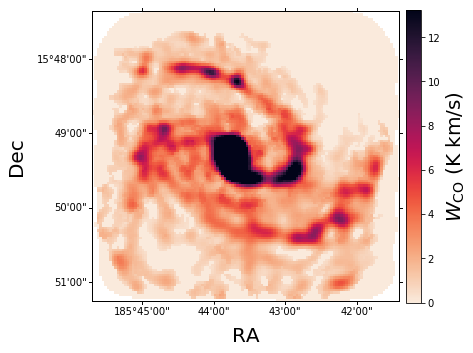

In [0]:
p_mom0()
# plt.title('mom0 ('+conbeam_filename+')')

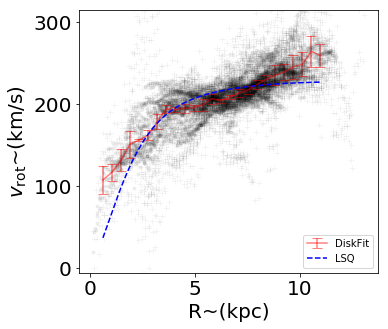

In [0]:
p_vrot(alphamult=1)

No handles with labels found to put in legend.


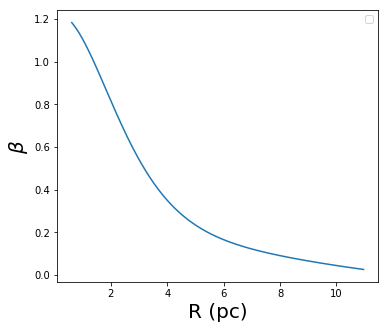

In [0]:
p_beta()

No handles with labels found to put in legend.


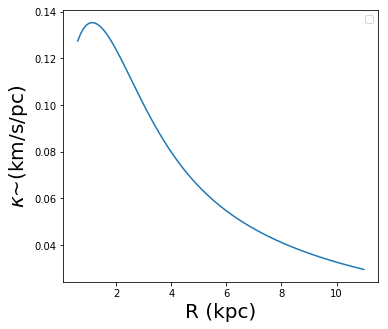

In [0]:
p_k()

No handles with labels found to put in legend.


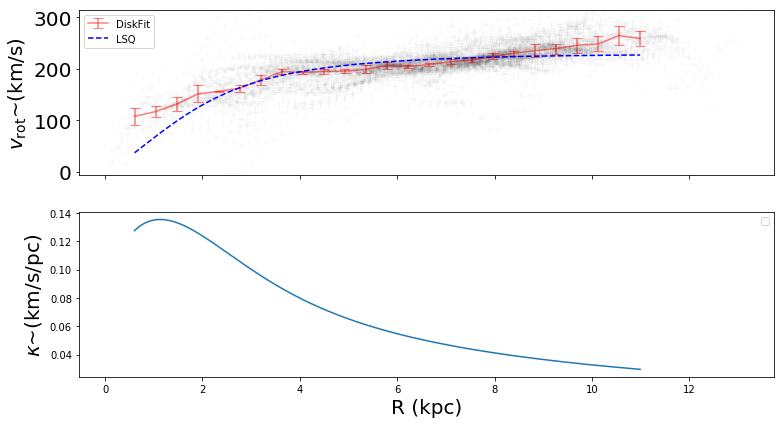

In [0]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(11,6),sharex=True)
p_vrot(save=False,ax=ax1)
p_k(save=False,ax=ax2)

plt.setp(ax1.get_xticklabels(), visible=False)
ax1.set_xlabel('',size=textsize)
plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/epicycles/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_k'+extension, bbox_inches='tight')

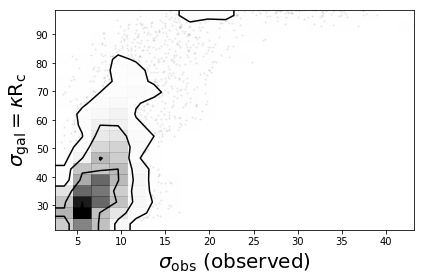

In [0]:
p_sigmasigma()

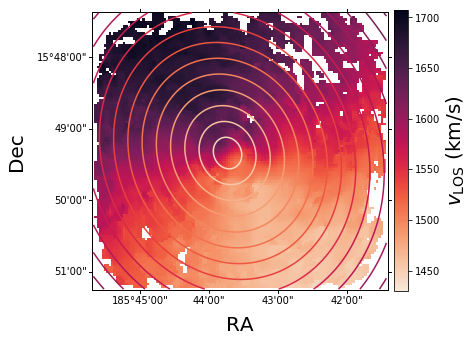

In [0]:
p_vmom1_with_radii()

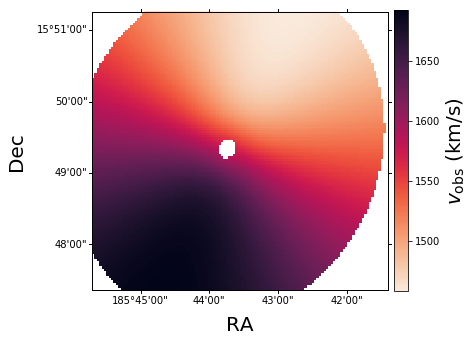

In [0]:
p_vobs()

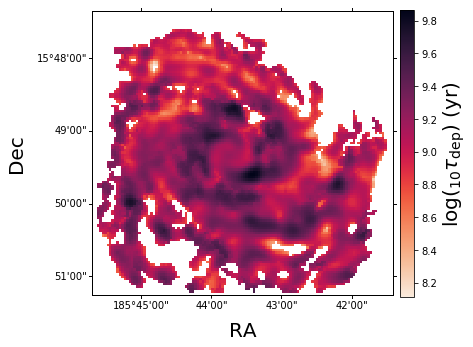

In [0]:
p_tdep()

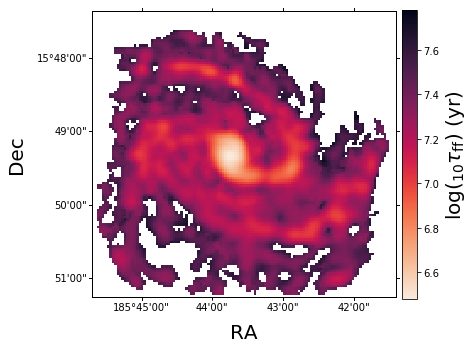

In [0]:
p_tff()

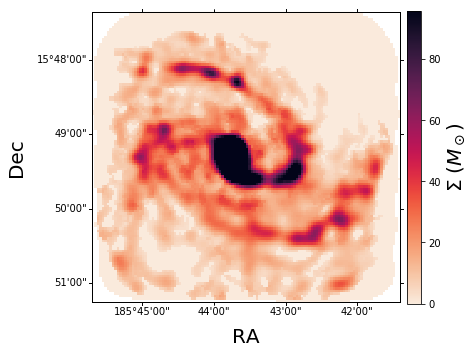

In [0]:
p_Sigma()

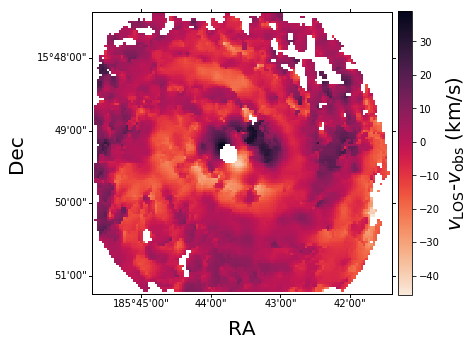

In [0]:
p_residual()

No handles with labels found to put in legend.


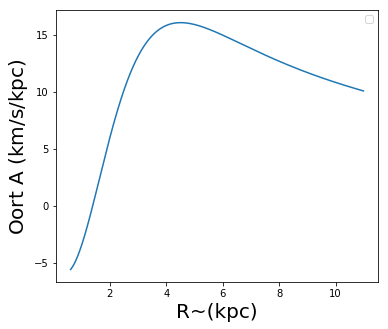

In [0]:
p_a()

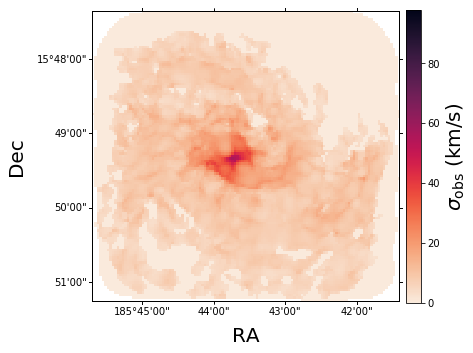

In [0]:
p_sigma_obs()
# plt.title('Line width, from convolved cube')

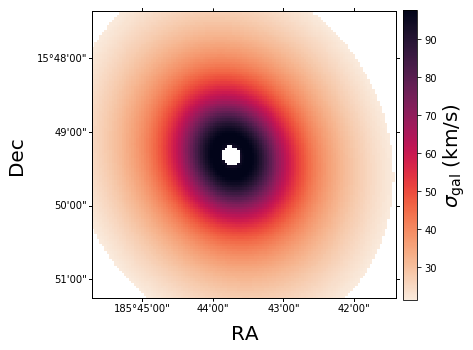

In [0]:
p_sigma_gal()

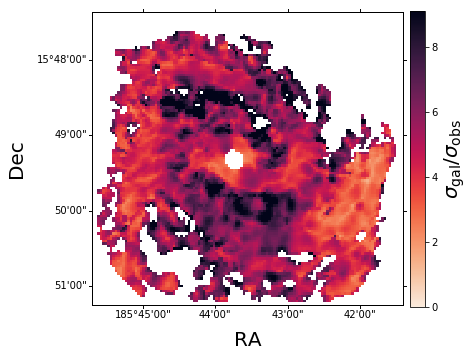

In [0]:
p_ratio()

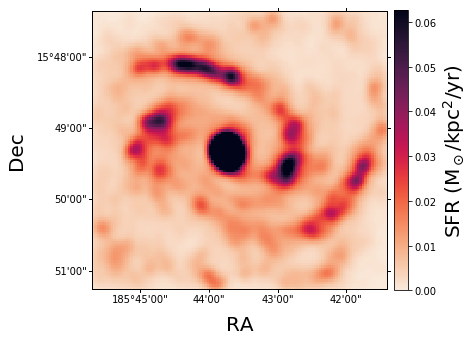

In [0]:
p_sfr()

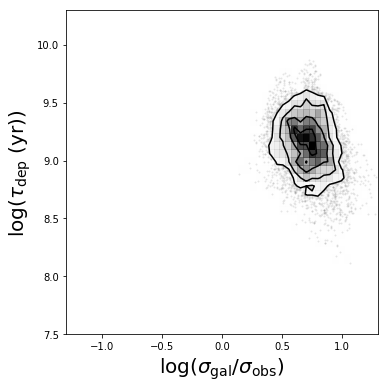

In [0]:
p_depletion_vs_ratio()

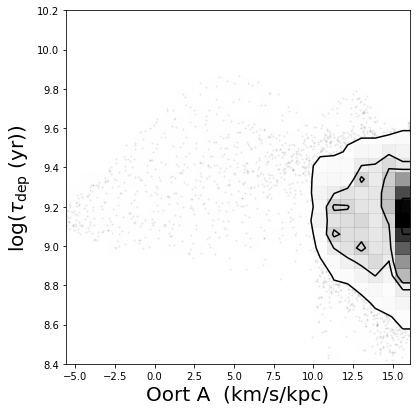

In [0]:
p_depletion_vs_A()

Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.


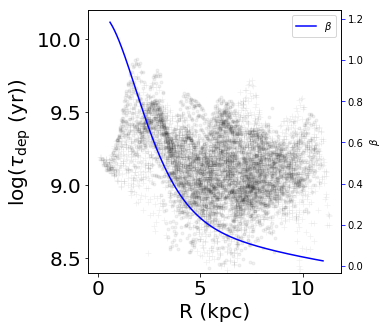

In [0]:
p_depletion_and_beta()

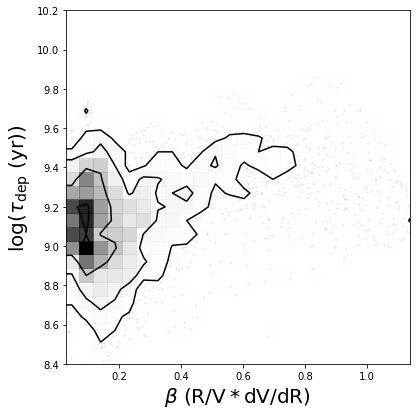

In [0]:
p_depletion_vs_beta()

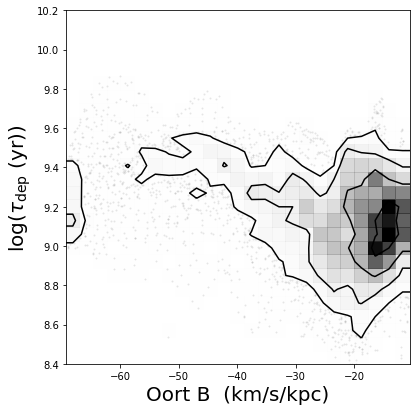

In [0]:
p_depletion_vs_B()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


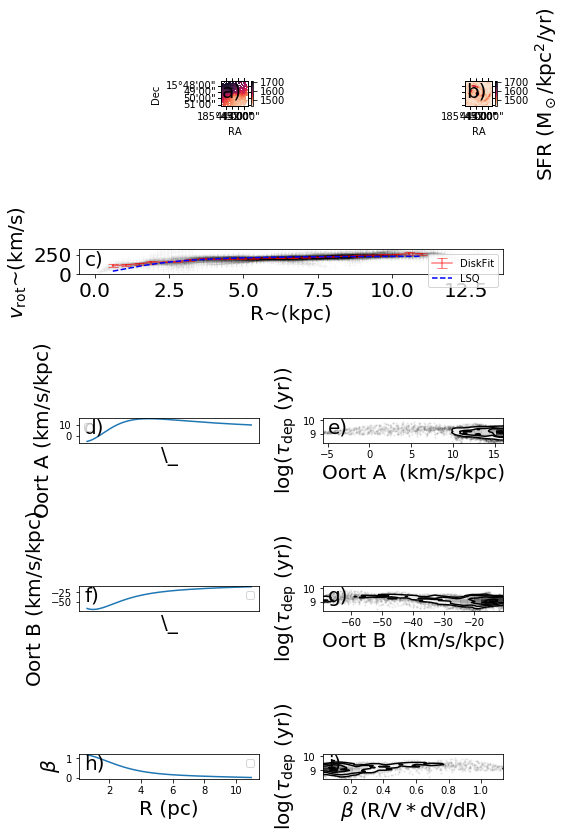

In [0]:
p_collage_RCderivs()

fancyplot/3panel_rotcurves/7m_mom1_NGC4321_universal.png


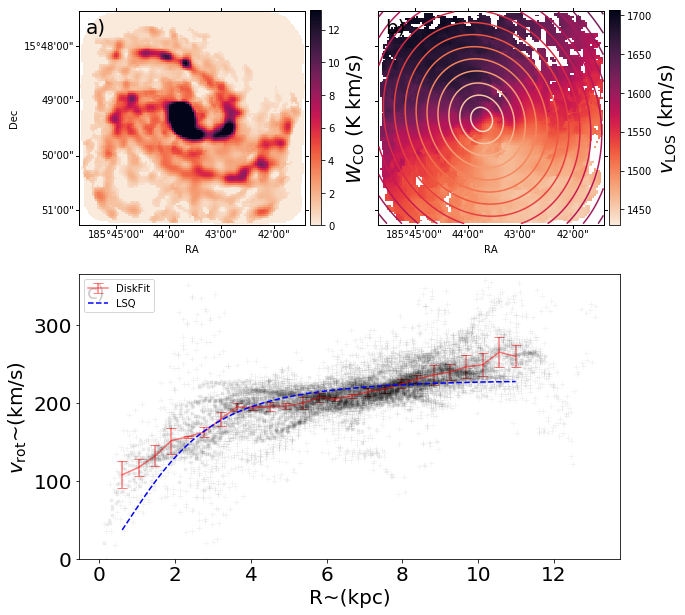

In [0]:
p_3panel_rotcurves()

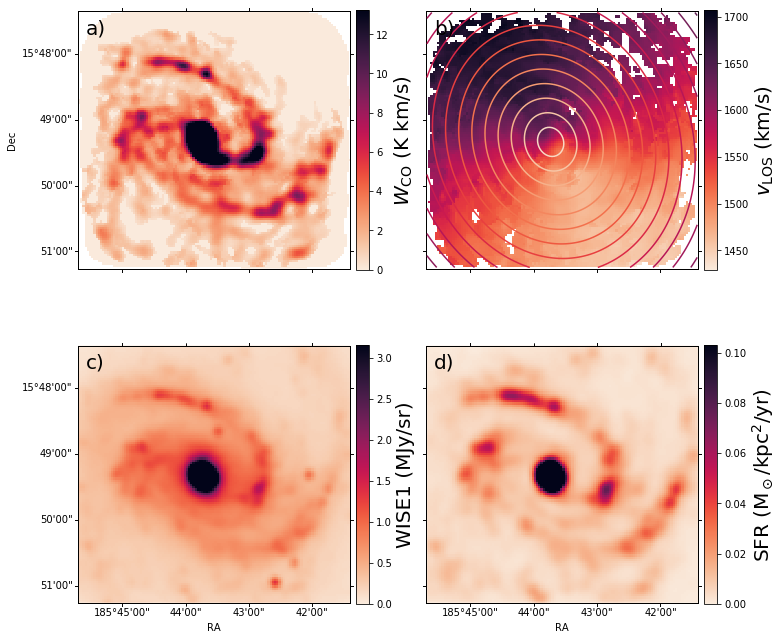

In [0]:
p_4panel_maps(base_width=10)

rc.RC() - WARNING: No custom knots. Spline fit will be crappy
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
rc.RC() - WARNING: No custom knots. Spline fit will be crappy


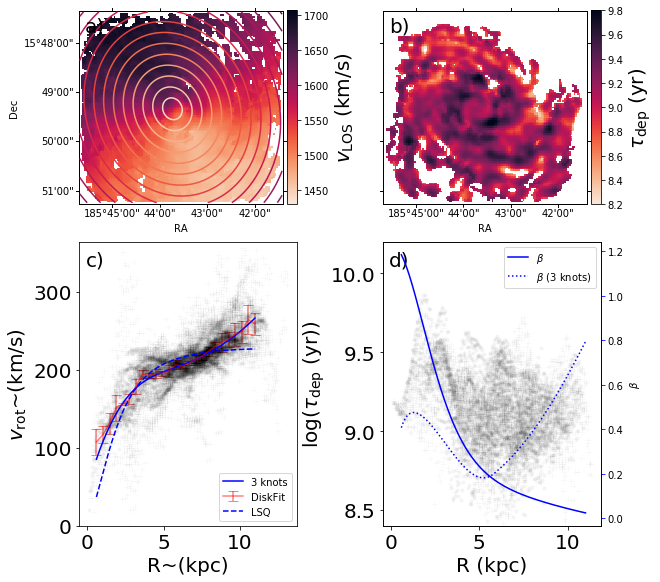

In [0]:
p_4panel_splinecompare(knots=-1)

Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved fil

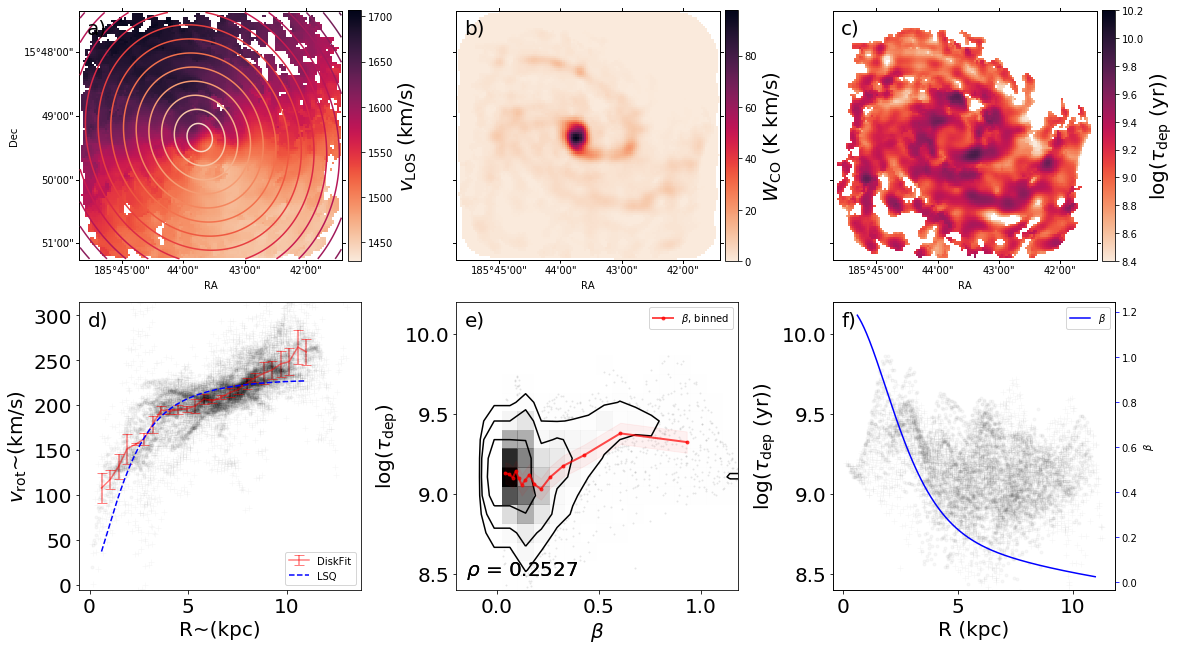

In [0]:
p_6panel_tdep_vs_beta()
# plt.clf()

Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved fil

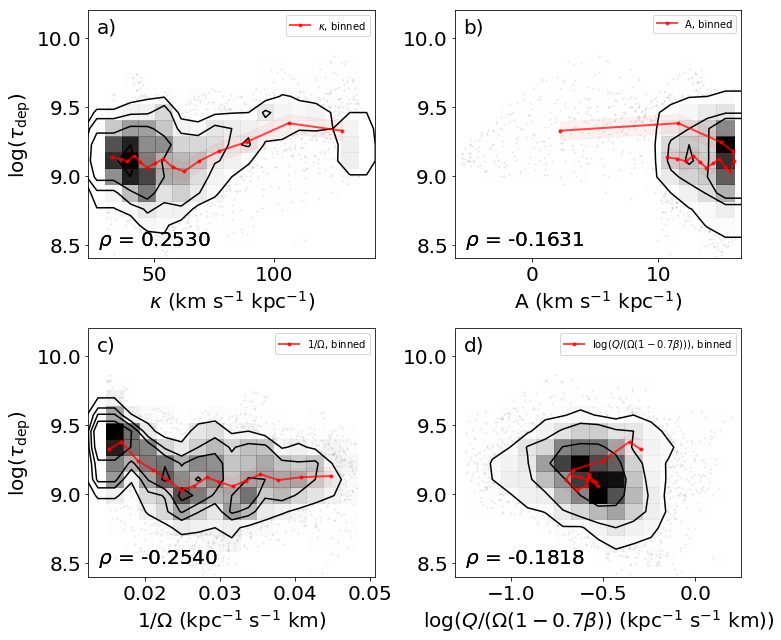

In [0]:
p_4panel_tdep_vs_shearpredictors()

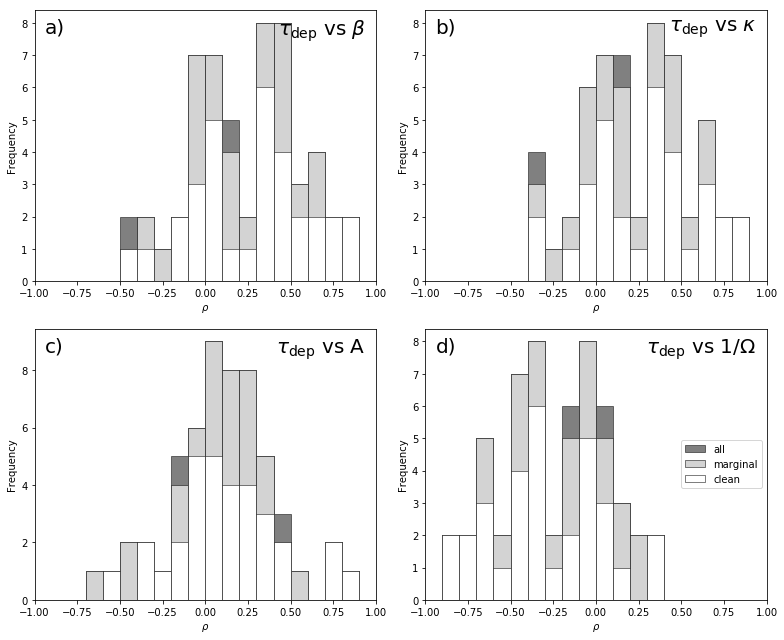

In [0]:
p_4panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True)

Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved fil

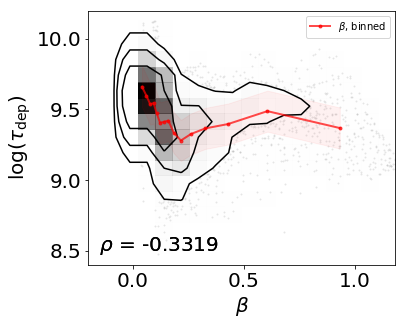

In [0]:
p_map2d_1panel('beta','tdep',x_mode='best',bins=False,save=False,alpha_custom='radial')
p_map2d_1panel('beta','tdep',x_mode='LSQ',bins=True,save=True,alpha_custom='radial')

Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved file is outdated and needs to be re-generated.
Current URC params (r in pc): [155.14603591180258, 3499.7961701039726, 1.1071792123668955]
Saved URC params (r in kpc):  [155.14603646   3.4997962    1.10717922]
rc.RC() - WARNING: Current URC parameters do not match the ones saved in MCurc_save/NGC4321_7m_universal.npz!
                   The saved fil

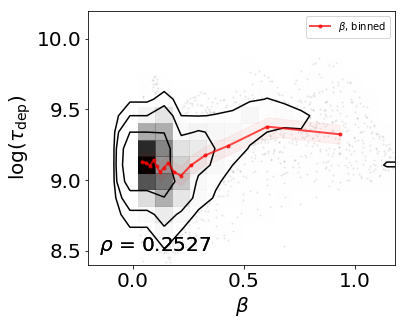

In [0]:
p_map2d_1panel('beta','tdep',x_mode='best',bins=False,save=False)
p_map2d_1panel('beta','tdep',x_mode='LSQ',bins=True,save=True)

# LOOP - all galaxies!!

#### Find+save rotcurves for entire galaxies_LIST! Also makes every plot that doesn't require SFR or convolution.
(Here, we consider rotcurves for all 72 galaxies with successful DiskFit output. No SFR or convolution involved.)

In [0]:
mapmode   = 'mom1'
data_mode = '7m'     # Do NOT change, unless 12m data is unavailable.
conbeam = None
rad_normalize = False

for smooth in ['universal']:
# for smooth in ['universal','simple','brandt']:
# for smooth in ['spline','brandt','simple','universal']:
# for smooth in ['brandt','simple','universal']:
    # Generating EVERYTHING!

    galmax = len(galaxies_list)                    # Highest galaxy in the list.
    # All galaxies, together!
    test_list   = [False]*galmax      # Checks whether a galaxy was used or not.
    R_list      = [None]*galmax      # Empty list for R's.
    R_e_list      = [None]*galmax      # Empty list for R's corresponding to vrot_e_list.
    vrot_list      = [None]*galmax   # Empty list for analytical rotcurves.
    vrot_s_list     = [None]*galmax # Empty list for the best smoothed analytical rotcurves (URC,LSQurc,or MCurc).
    vrots_list      = [None]*galmax  # Empty list for all smoothed analytical rotcurves (URC,LSQurc,AND MCurc).
    vrots_params_list      = [None]*galmax  # Empty list for all smoothed RC parameters (URC,LSQurc,AND MCurc).
    vrot_best_index_list   = [None]*galmax  # Empty list indicating which smoothed rotcurve is the "best" (^).
    vrot_best_vmax_list   = [None]*galmax   # Empty list for best rotcurve's vmax.
    vrot_e_list      = [None]*galmax # Empty list for analytical rotcurves' errorbars.
#     galaxies_skip = [0,10,11,12]     # Galaxies to be skipped entirely.
#     galaxies_skip = [0,9,11,12]     # Galaxies to be skipped entirely.

    for i in range(0,galmax):
        # (!) Choose a condition!
        if galaxies_list[i] in galaxies_skip:
            continue
        
        name = galaxies_list[i]   # Selects a galaxy.
        print('Starting '+name+'...')
        
        # OPTIONS!!
        knots=-1

        # Fancyplot path & conbeam filename
        # Conbeam - convert to angle
        if str(conbeam).replace('.0 pc','pc') in ['500pc','750pc','1000pc','1250pc']:
            conbeam = int(str(conbeam).replace('.0 pc','pc').replace('pc',''))*u.pc
        elif type(conbeam) is str:
            raise ValueError('fancyplot.everything() : \'conbeam\' must be in [\'500pc\',\'750pc\',\'1000pc\',\'1250pc\'] as a string.')
        # Create conbeam_filename
        if conbeam==None:
            conbeam_filename = ''
            conbeam_deg = None
        elif conbeam.unit in {u.pc, u.kpc, u.Mpc}:
            conbeam_filename = str(conbeam.to(u.pc)).replace('.0 pc','pc')
            conbeam_deg = (conbeam.to(u.pc)/gal.distance.to(u.pc))*(u.rad.to(u.deg))
        elif conbeam.unit in {u.arcsec, u.arcmin, u.deg, u.rad}:
            conbeam_filename = str(conbeam.to(u.arcsec).value)+'arcsec'
            conbeam_deg = conbeam.to(u.deg)
        else:
            raise ValueError('conbeam should be in arcsec or pc!')   
        if conbeam==None:
            path = 'fancyplot/'
            conv_title_suffix = ''
        else:
            path = 'fancyplot/convolved/'
            conv_title_suffix = ',\n Convolved to '+conbeam_filename
            
        with silence():
            gal = tools.galaxy(name,data_mode=data_mode,mapmode=mapmode,diskfit_output=True, customPA=customPA)
            gal_orig = tools.galaxy(name,diskfit_output=False,custominc=True,customPA=True,customvsys=False)  # pre-DiskFit
            PA_orig = gal_orig.position_angle
            incl_orig = gal_orig.inclination
            vsys_orig = gal_orig.vsys
            PA_fit = gal.position_angle
            incl_fit = gal.inclination
            vsys_fit = gal.vsys
            hdr = tools.hdr_get(gal,data_mode,dim=2)
            world = WCS(hdr)    # The WCS coordinates of the cube/maps/etc, as specified by the header.
            # Get maps, for plotting.
            I_mom0 = tools.mom0_get(gal,data_mode,conbeam,return_mode='data')
            aspect = I_mom0.shape[0]/I_mom0.shape[1]   # Aspect ratio of images, for colorbar
            I_mom1_broad = tools.mom1_get(gal,data_mode,False,return_mode='data',masking='broad')
            I_mom1       = tools.mom1_get(gal,data_mode,False,return_mode='data',masking=masking)
            vpeak        = tools.vpeak_get(gal,data_mode,False,return_mode='data',masking=masking)
            vobs, rad = rc.rotmap(gal,header=hdr,data_mode=data_mode,mapmode=mapmode,mode='best')
            X_temp,Y_temp = gal.radius(header=hdr, returnXY=True)     # Coords in disk plane, in Mpc.
            rad_full = (np.sqrt(X_temp**2+Y_temp**2).to(u.pc))  # Now in pc.
            phi = np.arctan2(Y_temp,X_temp)
            vrot_mom1  = (I_mom1_broad - gal.vsys.value) / (np.sin(gal.inclination) * np.cos(phi))
            index_wide = (np.abs(np.cos(phi)) > 0.3)  # Only consider points where cos(phi) is large.
            index_narrow = (np.abs(np.cos(phi)) > 0.8)  # Only consider points where cos(phi) is large.
            # Get rotcurve.
            R, vrot,R_e,vrot_e = gal.rotcurve(data_mode=data_mode,mapmode=mapmode)  # Radius, rotation curve
            # Abort if rotcurve is invalid.
            if np.isnan(np.sum(R)):
                raise ValueError('(fancyplot) : ROTCURVE INVALID!')

            # Get smoothed rotcurve, and all derivatives of it. Requires R, vrot.
            def nan1D(R):
                # Acts like an interpolator function, except it returns nan arrays instead of something useful.
                funct = np.zeros(R.shape)
                funct[:] = np.nan
                return funct
            if (smooth=='universal' and name in galaxies_badfit_univ) \
            or (smooth=='brandt' and name in galaxies_badfit_bran) \
            or (smooth=='simple' and name in galaxies_badfit_simp):
                print('(fancyplot) : SMOOTHED ROTCURVE FAILED! ('+smooth+')')
                vrot_spl = None
                vrot_s = None
                vrot_lsq = None
                vrot_mc = None
                vrot_best = None
                vrots = [vrot_s,vrot_lsq,vrot_mc]    # All three smoothed versions, for your convenience.
                vrots_params = [[np.nan,np.nan,np.nan]]*3
                vrot_best_index = 0
                # Get beta, k, OortA&B. Requires vrot_s.
                beta = nan1D
                k = nan1D
                A = nan1D                                          # Oort A / Local Shear
                B = nan1D                                          # Oort B / Local Shear
                sigma_gal = nan1D                                  # (BSpline of 2D array)
                # ^ Effective vel. disp. from gal. rotation
            else:
                R,vrot_spl                        = rc.RC(gal,data_mode,mapmode,mode='spline',knots=knots)
                R,vrot_s,vmaxURC,rmaxURC,AURC     = rc.rotcurve_smooth(R,vrot,R_e,vrot_e,smooth=smooth,\
                                                                   knots=knots, returnparams=True)  # Smooth rotcurve
                R,vrot_lsq,vmaxLSQ,rmaxLSQ,ALSQ   = rc.RC(gal,data_mode,mapmode,smooth,mode='LSQ',returnparams=True)
                R,vrot_mc,vmaxMC,rmaxMC,AMC       = rc.RC(gal,data_mode,mapmode,smooth,mode='MC',returnparams=True)
                if (vrot_mc is None) and (vrot_lsq is None):
                    print('fancyplot : No MC-URC or LSQ-URC rotcurve. Doing calculations with standard URC fit instead.')
                    vrot_mc  = None
                    vrot_lsq = None
                    vrot_best_index = 0
                elif vrot_mc is None:        # If only MCurc isn't there
                    print('fancyplot : No MC-URC rotcurve. Doing calculations with LSQ fit instead.')
                    vrot_mc = None
                    vrot_best_index = 1
                elif vrot_lsq is None:        # If only LSQurc isn't there
                    print('fancyplot : No LSQ-URC rotcurve. Doing calculations with MC fit instead.')
                    vrot_lsq = None
                    vrot_best_index = 2      
        #             vrot_best_index = 0      # (!) vrot_mc sucks at the moment. Replace this with vrot_ms when it's better!
                else:
#                     vrot_best_index = 2      
                    vrot_best_index = 1      # (!) By default, LSQ is best option for now
                # Choose the best smoothed rotcurve!
                vrots = [vrot_s,vrot_lsq,vrot_mc]    # All three smoothed versions, for your convenience.
                vrots_params = [[vmaxURC,rmaxURC,AURC],[vmaxLSQ,rmaxLSQ,ALSQ],[vmaxMC,rmaxMC,AMC]]
                vrot_best = vrots[vrot_best_index]
                # Get beta, k, OortA&B. Requires vrot_s or vrot_mc.
                beta = rc.beta(R,vrot_best)
                k = rc.epicycles(R,vrot_best)
                A = rc.oort(R,vrot_best,oort='A')                     # Oort A / Local Shear
                B = rc.oort(R,vrot_best,oort='B')                     # Oort B / Local Shear
                sigma_gal = rc.linewidth_iso(gal,beam,smooth,knots,data_mode,mapmode,mode='best')  # (BSpline of 2D array)
                # ^ Effective vel. disp. from gal. rotation, where R_c ~ beam width. (NOT the width of convolved beam!)
        
        print('Beginning array organizing...')

        # Saving the beta/depletion/A/B arrays for each galaxy!
        test_list[i] = True
        # Saving rotcurve for each galaxy!
        R_list[i]   = R
        R_e_list[i] = R_e

        vrot_list[i] = vrot
        vrot_e_list[i] = vrot_e  # Array, corresponding to R_e_list[i].
        vrot_s_list[i] = vrot_best
        vrots_list[i] = vrots
        vrots_params_list[i] = vrots_params
        vrot_best_index_list[i] = vrot_best_index
        vrot_best_vmax_list[i] = vrots_params[vrot_best_index][0]

        if isinstance(vrot_s_list[i],BSpline)==False:  # If vrot_s failed:
            print('AAAAAAa')
            vrot_s_list[i] = None
            vrots_list[i] = None
            vrots_params_list[i] = None
            vrot_best_index_list[i] = None
            vrot_best_vmax_list[i] = None

        print('... Array organizing finished!')
        # ACTUAL PLOTTING!

        print('Beginning plotting...')

        p_vrot()
        plt.clf()

        p_beta()
        plt.clf()

        p_a()
        plt.clf()

        p_b()
        plt.clf()

        # kappa-vs-R: version 1
        fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,6),sharex=True)
        p_vrot(save=False,ax=ax1)
        p_k(save=False,ax=ax2)
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_xlabel('')
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/epicycles/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_k'+extension, bbox_inches='tight')
        plt.clf()

        # kappa-vs-R: version 2
    #         p_k()
    #         plt.clf()

        p_vobs()
        plt.clf()

        p_vmom1()
        plt.clf()

        p_vmom1_with_radii()
        plt.clf()

        p_residual()
        plt.clf()

        p_vpeak()
        plt.clf()

    #         Plot mom1-vpeak!
        veldiff = (I_mom1-vpeak)
        p_veldiff()
        plt.clf()

        # Multipanel images!

        p_3panel_rotcurves()
        plt.clf()
        
        print('... Plotting finished!')
    # Saving arrays into .npz
    np.savez('BigData/galaxies/multiple_rotcurves_'+smooth+'_.npz', egg0 = galaxies_list,\
                                                   egg1=R_list,egg2=R_e_list,\
                                                   egg3=vrot_list,egg4=vrot_e_list,egg5=vrot_s_list,\
                                                   egg6=vrots_list,egg7=vrots_params_list,\
                                                   egg8=vrot_best_index_list, egg9=vrot_best_vmax_list)

Starting IC1954...
Beginning array organizing...
... Array organizing finished!
Beginning plotting...


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


fancyplot/3panel_rotcurves/7m_mom1_IC1954_universal.png
... Plotting finished!
Starting IC5273...
Beginning array organizing...
... Array organizing finished!
Beginning plotting...


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


fancyplot/3panel_rotcurves/7m_mom1_IC5273_universal.png
... Plotting finished!
Starting IC5332...
Beginning array organizing...
... Array organizing finished!
Beginning plotting...


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


fancyplot/3panel_rotcurves/7m_mom1_IC5332_universal.png
... Plotting finished!
Starting NGC0628...


## **MAIN LOOP**, for galaxies_SET!
#### Finds+saves pretty much every parameter (tdep, beta, etc.) for every galaxy, and plots everything 1 galaxy at a time.
(We use the 53 galaxies with ALL REQUIRED DATA at the required resolutions.)

In [0]:
mapmode   = 'mom1'
data_mode = '7m'     # Do NOT change, unless 12m data is unavailable.
showtitle = False
conbeam = 750*u.pc
rad_normalize = False
tdep_vs_shear_tests = [['beta','depletion'], ['1/Omega','depletion'], ['tan2000','depletion'],\
                       ['hunter1998','depletion'], ['meidt2018','depletion'], ['freefall','depletion'],\
                       ['beta','tdep-tdep(Re)'], ['Q','depletion'], ['beta','tdep-tff'], ['beta','tdep-torb']]

for smooth in ['universal']:
# for smooth in ['universal','simple','brandt']:
# for smooth in ['spline','brandt','simple','universal']:
# for smooth in ['brandt','simple','universal']:
    # Generating EVERYTHING!

    galmax = len(galaxies_set)                    # Highest galaxy in the list.
    # All galaxies, together!
    test_list   = [False]*galmax      # Checks whether a galaxy was used or not.
    R_list      = [None]*galmax      # Empty list for R's.
    R_e_list    = [None]*galmax      # Empty list for R's corresponding to vrot_e_list.
    vrot_list      = [None]*galmax   # Empty list for analytical rotcurves.
    vrot_s_list    = [None]*galmax # Empty list for the best smoothed analytical rotcurves (URC,LSQurc,or MCurc).
                                     # (!) May need to change to 'vrot_best_list', as vrot_s is just URC-smoothed...
    vrot_best_index_list  = [None]*galmax  # Empty list indicating which smoothed rotcurve is the "best" (^).
    vrot_best_vmax_list   = [None]*galmax   # Empty list for best rotcurve's vmax.
    vrot_e_list           = [None]*galmax # Empty list for analytical rotcurves' errorbars.
    beta1D_list    = [None]*galmax   # Empty list for d lnV / d lnR's.
    beta2D_list    = [None]*galmax   # ^ 2D
    A1D_list       = [None]*galmax   # Empty list for Oort A's.
    A2D_list       = [None]*galmax   # ^ 2D
    B1D_list       = [None]*galmax   # Empty list for Oort B's.
    B2D_list       = [None]*galmax   # ^ 2D
    k1D_list       = [None]*galmax   # Empty list for \kappa (epicyclic frequency).
    k2D_list       = [None]*galmax   # ^ 2D
    rad_list       = [None]*galmax   # Empty list of radius maps
    sigma_gal2D_list = [None]*galmax # Empty list for sigma_gal (shear across cloud-scale).
    sigma2D_list     = [None]*galmax # Empty list for sigma (velocity dispersion).
    Sigma2D_list     = [None]*galmax # Empty list for sigma (molecular density).
    Omega2D_list     = [None]*galmax # Empty list for vrot_best(rad)/(rad.to(u.kpc)).value .
    depletion1D_list = [None]*galmax   # Empty list for depletions.
    freefall1D_list  = [None]*galmax   # Empty list for freefall time.
    orbital1D_list   = [None]*galmax   # Empty list for orbital times.
    depletion2D_list = [None]*galmax   # Empty list for depletion maps.
    freefall2D_list  = [None]*galmax   # Empty list for freefall time maps.
    orbital2D_list   = [None]*galmax   # Empty list for orbital time maps.
    beta_mean_list         = [None]*galmax   # Empty list for arrays of beta_mean in various bins.
    A_mean_list            = [None]*galmax   # Empty list for arrays of A_mean in various bins.
    B_mean_list            = [None]*galmax   # Empty list for arrays of B_mean in various bins.
    logdepletion_mean_list = [None]*galmax   # Empty list for arrays of depletion_mean in various bins.
    logfreefall_mean_list  = [None]*galmax   # Empty list for arrays of freefall_mean in various bins.
    logorbital_mean_list   = [None]*galmax   # Empty list for arrays of orbital_mean in various bins.
    stride_list            = [None]*galmax   # Empty list for 'stride' values (for converting 2D maps to 1D)
    rank_correlations_list          = [None]*galmax   # Empty list for rank correlations of tdep-vs-shearpredictors
    rank_correlations_list_alpharad = [None]*galmax   # Empty list for rank correlations of tdep-vs-shearpredictors,
                                                      #   with radially-varying alpha
    rank_pvalues_list          = [None]*galmax   # Empty list for corresponding p-values to correlations
    rank_pvalues_list_alpharad = [None]*galmax   # Empty list for corresponding p-values to correlations,
                                                 #   with radially-varying alpha
    pvalue = None
    Re_set = tools.Re_get(galaxies_set)
#     galaxies_skip = [0,10,11,12]     # Galaxies to be skipped entirely.
#     galaxies_skip = [0,9,11,12]     # Galaxies to be skipped entirely.

    for i in range(0,galmax):
        # (!) Choose a condition!
        if galaxies_set[i] in galaxies_skip:
            continue
        
        name = galaxies_set[i]   # Selects a galaxy.

        # OPTIONS!!
        #conbeam = 6*u.arcsec     # If you don't want convolved versions, set conbeam=None.
        conbeam = galaxies_conbeam[i]
        #conbeam = None
        alpha = galaxies_alpha[i]

    #     smooth='universal'
        knots=-1
    #     data_mode='12m'           # Do NOT change. The 7m mode is only for plotting the mom1 map.

        with silence():
            gal = tools.galaxy(name,data_mode=data_mode,mapmode=mapmode,diskfit_output=True, customPA=customPA)
        hdr,world,beam,I_mom0,I_mom1,I_mom1_broad,vpeak,I_tpeak,cube,noise,sfr,sfr_best,wise1,\
        R,vrot,R_e,vrot_e,vrot_spl,vrot_s,vrot_lsq,vrot_mc,\
        vrots,vrots_params,vrot_best_index,vrot_mom1,index_wide,index_narrow,\
        PA_orig,PA_fit,incl_orig,incl_fit,vsys_orig,vsys_fit, k,\
        vobs,rad,rad_full,A,B,Sigma,sigma,sigma_gal,sigma1D,sigma_gal1D,\
        beta,depletion,freefall,orbital,beta1D,\
        depletion1D,logdepletion1D,freefall1D,logfreefall1D,orbital1D,logorbital1D,\
        rad1D,A1D,B1D,\
        stride,path,conv_title_suffix,conbeam_filename,aspect \
            = everything(name,conbeam=conbeam,smooth=smooth,knots=knots,mapmode=mapmode,data_mode=data_mode,\
                         masking=masking,alpha=alpha,\
                         read_df_output=True,customPA=customPA)
        
        vrot_best = vrots[vrot_best_index]
        
        print('Beginning array organizing...')
        
        # Finding mean beta/depletion values within certain radius bins!
#         Rstep = 500*u.pc     # Steps of 500pc.
#         nbins = int(R.max()/Rstep.value)+1
#         beta_mean = [np.nan]*nbins
#         logdepletion_mean = [np.nan]*nbins

#         for j in range(0,nbins):
#             Rmin = (j)*Rstep
#             Rmax = (j+1)*Rstep
#             if (j+1)==nbins:
#                 Rmax = R.max()*u.pc    # Correction for final bin, which doesn't reach full 500pc in size.

#             index = (rad1D>Rmin)*(rad1D<Rmax)
#             beta_mean[j] = np.mean(beta1D[index])
#             logdepletion_mean[j] = np.mean(np.log10(depletion[index]))
            
        # Same as above, but binned based on number of data points.
        Nbins=15
        beta_means         = tools.means(beta1D,Nbins)
        A_means            = tools.means(A1D,Nbins)
        B_means            = tools.means(B1D,Nbins)
#         k_means            = tools.means()
        logdepletion_means = tools.means(logdepletion1D,Nbins)
        logfreefall_means  = tools.means(logfreefall1D,Nbins)
        logorbital_means   = tools.means(logorbital1D,Nbins)
        
        # Saving the beta/depletion/A/B arrays for each galaxy!
        test_list[i] = True
        # 1D lists (depreciated?)
        beta1D_list[i], depletion1D_list[i], freefall1D_list[i], orbital1D_list[i], A1D_list[i], B1D_list[i] \
            = beta1D,depletion1D,freefall1D,orbital1D,A1D,B1D
        # 2D lists & stride list
        beta2D_list[i],A2D_list[i],B2D_list[i],k2D_list[i],rad_list[i],sigma_gal2D_list[i],sigma2D_list[i],Sigma2D_list[i],\
        Omega2D_list[i], depletion2D_list[i], freefall2D_list[i], orbital2D_list[i], stride_list[i] \
            = beta(rad),A(rad),B(rad),k(rad),rad,sigma_gal(rad),sigma,Sigma,\
              vrot_best(rad)/(rad.to(u.kpc)).value, depletion, freefall, orbital, stride
        # Saving the binned means of these arrays as well! (Not necessary anymore?)
        beta_mean_list[i], logdepletion_mean_list[i], logfreefall_mean_list[i], logorbital_mean_list[i],\
        A_mean_list[i], B_mean_list[i]\
            = beta_means, logdepletion_means, logfreefall_means, logorbital_means, A_means, B_means
        # Saving rotcurve for each galaxy!
        R_list[i]   = R
        R_e_list[i] = R_e

        vrot_list[i] = vrot
        vrot_e_list[i] = vrot_e  # Array, corresponding to R_e_list[i].
        vrot_s_list[i] = vrot_best
        vrot_best_index_list[i] = vrot_best_index
        vrot_best_vmax_list[i] = vrots_params[vrot_best_index][0]
        
        if isinstance(vrot_s_list[i],BSpline)==False:  # If vrot_s failed:
            print('AAAAAAa')
            vrot_s_list[i] = None
            beta_mean_list[i] = None
            A_mean_list[i] = None
            B_mean_list[i] = None
            beta1D_list[i] = None
            A1D_list[i] = None
            B1D_list[i] = None
        if np.sum(~np.isnan(sfr))==0:  # If sfr failed:
            depletion1D_list[i]   = None
            depletion2D_list[i] = None
            logdepletion_mean_list[i] = None
            
        print('... Array organizing finished!')
            
        # ACTUAL PLOTTING!

        print('Beginning plotting...')
        
        p_mom0()
        plt.clf()

        p_Sigma()
        plt.clf()

        p_tff()
        plt.clf()

        p_tdep()
        plt.clf()
        
        p_vrot()
        plt.clf()

        p_beta()
        plt.clf()
        
        p_a()
        plt.clf()

        p_b()
        plt.clf()

#         kappa-vs-R: version 1
        fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,6),sharex=True)
        p_vrot(save=False,ax=ax1)
        p_k(save=False,ax=ax2)
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.set_xlabel('')
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/epicycles/'+smooth+'/'+data_mode+'_'+mapmode+'_'+str(name)+'_k'+extension, bbox_inches='tight')
        plt.clf()
        
#         kappa-vs-R: version 2
        p_k()
        plt.clf()

        p_sigmasigma()
        plt.clf()

        p_vobs()
        plt.clf()

        p_vmom1()
        plt.clf()
        
        p_vmom1_with_radii()
        plt.clf()

        p_residual()
        plt.clf()

        p_sigma_obs()
        plt.clf()

        p_sigma_gal()
        plt.clf()

        p_ratio()
        plt.clf()

        p_noise()
        plt.clf()

        p_sfr()
        plt.clf()

        p_depletion_vs_ratio()
        plt.clf()

        p_depletion_vs_A()
        plt.clf()
        p_depletion_vs_B()
        plt.clf()
        p_depletion_vs_beta()
        plt.clf()

        p_vpeak()
        plt.clf()

#         Plot mom1-vpeak!
        veldiff = (I_mom1-vpeak)
        p_veldiff()
        plt.clf()
        
#         Multipanel images!
        p_collage_RCderivs()
        plt.clf()

        p_4panel_splinecompare(knots=-1)
        plt.clf()
        
        p_4panel_maps(base_width=10)
        plt.clf()
        
        p_4panel_tdep_vs_shearpredictors()
        plt.clf()
        
        p_3panel_rotcurves()
        plt.clf()
        
        p_6panel_tdep_vs_beta()
        plt.clf()
        
        tdep_vs_shear_tests = [['beta','depletion'], ['1/Omega','depletion'], ['tan2000','depletion'],\
                               ['hunter1998','depletion'], ['meidt2018','depletion'], ['freefall','depletion'],\
                               ['beta','tdep-tdep(Re)'], ['Q','depletion'], ['beta','tdep-tff'], ['beta','tdep-torb']]
#         tdep_vs_shear_tests = [['tan2000','depletion']]
        rank_correlations          = [None]*len(tdep_vs_shear_tests)
        rank_correlations_alpharad = [None]*len(tdep_vs_shear_tests)
        rank_pvalues               = [None]*len(tdep_vs_shear_tests)
        rank_pvalues_alpharad      = [None]*len(tdep_vs_shear_tests)
        for x_name,y_name in tdep_vs_shear_tests:
            # Comment out ONLY the next three lines if not needed.
            p_map2d_1panel(x_name,y_name,x_normalize=False,y_normalize=False,bins=False,Nbins=15,save=False)
            p_map2d_1panel(x_name,y_name,x_normalize=False,y_normalize=False,bins=True,Nbins=15, showcorrelation=True)
            plt.clf()
            # (!! DO NOT COMMENT OUT !!)
            rho,pvalue                   = corr_map2d_1panel(x_name,y_name,x_normalize=False,y_normalize=False,Nbins=15)
            rho_alpharad,pvalue_alpharad = corr_map2d_1panel(x_name,y_name,x_normalize=False,y_normalize=False,Nbins=15,alpha_custom='radial')
            rank_correlations[tdep_vs_shear_tests.index([x_name,y_name])] = rho
            rank_correlations_alpharad[tdep_vs_shear_tests.index([x_name,y_name])] = rho_alpharad
            rank_pvalues[tdep_vs_shear_tests.index([x_name,y_name])] = pvalue
            rank_pvalues_alpharad[tdep_vs_shear_tests.index([x_name,y_name])] = pvalue_alpharad
        rank_correlations_list[i] = rank_correlations
        rank_correlations_list_alpharad[i] = rank_correlations_alpharad
        rank_pvalues_list[i] = rank_pvalues
        rank_pvalues_list_alpharad[i] = rank_pvalues_alpharad
        
        print('... Plotting finished!')
        if pvalue is None:
            raise ValueError('fancyplot (main loop): DON\'T FORGET ABOUT THE CORRELATIONS')
    # Saving arrays into .npz
    while None in rank_correlations_list:
        rank_correlations_list[list(rank_correlations_list).index(None)]          = [np.nan]*len(tdep_vs_shear_tests)
        rank_correlations_list_alpharad[list(rank_correlations_list_alpharad).index(None)] = [np.nan]*len(tdep_vs_shear_tests)
    rank_correlations_list          = np.array(list(rank_correlations_list))
    rank_correlations_list_alpharad = np.array(list(rank_correlations_list_alpharad))
    np.savez('BigData/galaxies/multiple_depletion_vs_beta_'+smooth+'_.npz', egg0 = galaxies_set,\
                                               egg0p5=rad_list,\
                                               egg1=beta1D_list,egg2=depletion1D_list,egg2p5=depletion2D_list,\
                                               egg3=freefall1D_list,egg3p5=freefall2D_list,\
                                               egg4=orbital1D_list,egg4p5=orbital2D_list,\
                                               egg5=beta_mean_list,egg6=logdepletion_mean_list,\
                                               egg7=logfreefall_mean_list,egg8=logorbital_mean_list,\
                                               egg9=A1D_list,egg10=B1D_list,\
                                               egg11=A_mean_list,egg12=B_mean_list,\
                                               egg13=R_list,egg14=R_e_list,\
                                               egg15=vrot_list,egg16=vrot_e_list,egg17=vrot_s_list,\
                                               egg18=vrot_best_index_list, egg19=vrot_best_vmax_list,\
                                               egg20=rank_correlations_list,egg20p5=rank_correlations_list_alpharad,\
                                               egg20p6=rank_pvalues_list,egg20p7=rank_pvalues_list_alpharad,\
                                               egg21=beta2D_list,egg22=A2D_list,egg23=B2D_list,egg24=k2D_list,\
                                               egg25=sigma_gal2D_list,egg26=sigma2D_list,egg26p5=Sigma2D_list,\
                                               egg27=Omega2D_list,egg28=stride_list)
# Final histogram
# p_4panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True)
# plt.clf()

# ----------- Plotting, for *'many-galaxies-at-once'* figures -----------

### Reload galaxies_SET stuff
(i.e. reload everything of importance that was generated in the Main Loop$^\mathrm{TM}$)

In [0]:
# Loading arrays from .npz
data = np.load('BigData/galaxies/multiple_depletion_vs_beta_'+smooth+'_.npz',allow_pickle=True)
galaxies_set_b = list(data['egg0'])
rad_list    = data['egg0p5']
beta1D_list = data['egg1']
depletion1D_list = data['egg2']
depletion2D_list = data['egg2p5']
freefall1D_list  = data['egg3']
freefall2D_list  = data['egg3p5']
orbital1D_list   = data['egg4']
orbital2D_list   = data['egg4p5']
beta_mean_list = data['egg5']
logdepletion_mean_list = data['egg6']
logfreefall_mean_list = data['egg7']
logorbital_mean_list  = data['egg8']
A1D_list = data['egg9']
B1D_list = data['egg10']
A_mean_list = data['egg11']
B_mean_list = data['egg12']
R_list = data['egg13']
R_e_list = data['egg14']
vrot_list = data['egg15']
vrot_e_list = data['egg16']
vrot_s_list = data['egg17']
vrot_best_index_list = data['egg18']
vrot_best_vmax_list  = data['egg19']
rank_correlations_list = data['egg20']
rank_correlations_list_alpharad = data['egg20p5']
rank_pvalues_list = data['egg20p6']
rank_pvalues_list_alpharad = data['egg20p7']
beta2D_list = data['egg21']
A2D_list = data['egg22']
B2D_list = data['egg23']
k2D_list = data['egg24']
sigma_gal2D_list = data['egg25']
sigma2D_list = data['egg26']
Sigma2D_list = data['egg26p5']
Omega2D_list = data['egg27']

# Masses, bars, alphas, etc.
logmass_b = tools.logmass_get(galaxies_set_b)
hasbar_b  = tools.hasbar_get(galaxies_set_b)
alpha_CO21_set_b = tools.alphaCO21_gen(galaxies_set_b,rad_list)  # Generates radially-varying alphas

# Color scales
logmass_colorscale_b = (logmass_b.astype('float') - np.nanmin(logmass_list.astype('float'))) / \
                       (np.nanmax(logmass_list.astype('float')) - np.nanmin(logmass_list.astype('float')))
# vrot_colorscale_b = (vrot_best_vmax_list.astype('float') - np.nanmin(vrot_best_vmax_list.astype('float'))) / \
#                     (np.nanmax(vrot_best_vmax_list.astype('float')) - np.nanmin(vrot_best_vmax_list.astype('float')))
shape = cycle(['o','s','^','*','d','X','p'])
lines = cycle(['-','--',':','-.'])
shapes_set_b  = [None]*len(galaxies_set_b)
lines_set_b   = [None]*len(galaxies_set_b)
colours_set_b = [None]*len(galaxies_set_b)
barcolours_set_b = [None]*len(galaxies_set_b)
hubblecolours_set_b = [None]*len(galaxies_set_b)
for i in range(0,len(galaxies_list)):
    if galaxies_list[i] in galaxies_set_b:
        shapes_set_b[galaxies_set_b.index(galaxies_list[i])]  = shapes_list[i]
        lines_set_b[galaxies_set_b.index(galaxies_list[i])]   = lines_list[i]
        colours_set_b[galaxies_set_b.index(galaxies_list[i])] = colours_list[i]
        barcolours_set_b[galaxies_set_b.index(galaxies_list[i])] = barcolours_list[i]
        hubblecolours_set_b[galaxies_set_b.index(galaxies_list[i])] = hubblecolours_list[i]

### Spearman rank correlation coefficient histograms
Pick an `alpha_custom` first!

In [0]:
alpha_custom = 'radial'
alpha_custom = 'constant'

aye


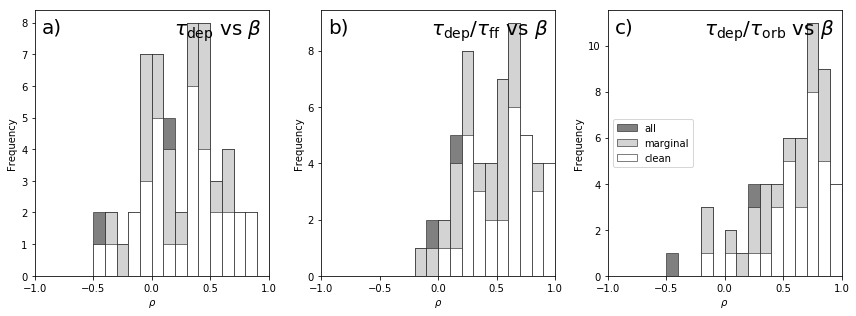

In [0]:
p_3panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                      alpha_custom=alpha_custom)

In [0]:
p_4panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                      alpha_custom=alpha_custom)

In [0]:
p_6panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                      alpha_custom=alpha_custom)

In [0]:
p_corr_map2d_many_6panel(galaxies_set_b,sample='clean-ish',split_sample='None',alpha_custom='radial',\
                         x_normalize=False, y_normalize=False)

In [0]:
# Quick loop for those above five boxes

for alpha_custom in ['radial','constant']:
    p_3panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                          alpha_custom=alpha_custom)
    plt.clf()
    p_4panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                          alpha_custom=alpha_custom)
    plt.clf()
    p_6panel_tdep_vs_shearpredictors_hist(show_clean=True,show_cleanish=True,\
                                          alpha_custom=alpha_custom)
    plt.clf()
    p_corr_map2d_many_6panel(galaxies_set_b,sample='clean-ish',split_sample='None',alpha_custom='radial',\
                             x_normalize=False, y_normalize=False)
    plt.clf()

### Plotting all map2d-vs-map2d Comparisons
(e.g. $\tau_\mathrm{dep}$-vs-($\kappa$, $\beta$, etc.), or $\Sigma_\mathrm{mol}$-vs-$\Sigma_\mathrm{SFR}$)

In [0]:
# 2D map2d-vs-map2d plots: ALL

# Sigma_mol vs Sigma_SFR
for y_name,y_norm in [['sfr',False]]:
    for x_name,x_norm in [['bigma',False]]:
        for split_sample in ['None','bars','hubble']:
            for alpha_custom in ['constant','custom','radial']:
                for sample in ['all','clean-ish','clean']:
                    print('Starting: '+y_name+y_norm*('-median')+' vs '+x_name+x_norm*('-median')\
                                      +', sample='+split_sample+', alpha_custom='+str(alpha_custom)+', '+sample)
                    p_map2d_many_2panel(galaxies_set_b,sample=sample,split_sample=split_sample,\
                                        alpha_custom=alpha_custom,\
                                        x_name=x_name,y_name=y_name,\
                                        x_normalize=x_norm, y_normalize=y_norm)
                    plt.clf()
# # Everything else
# for y_name,y_norm in [['depletion',False],['depletion',True],['tdep-tff',False],\
#                       ['tdep-torb',False],['tdep-tdep(Re)',False]]:
#     for x_name,x_norm in [['beta',False], ['beta',True], ['1/Omega',False], ['tan2000',False],\
#                       ['hunter1998',False],  ['meidt2018',False], ['Q',False]]:
#         for split_sample in ['None','bars','hubble']:
#             for alpha_custom in ['constant','custom','radial']:
#                 for sample in ['all','clean-ish','clean']:
#                     print('Starting: '+y_name+y_norm*('-median')+' vs '+x_name+x_norm*('-median')\
#                                       +', sample='+split_sample+', alpha_custom='+str(alpha_custom)+', '+sample)
#                     p_map2d_many_2panel(galaxies_set_b,sample=sample,split_sample=split_sample,\
#                                         alpha_custom=alpha_custom,\
#                                         x_name=x_name,y_name=y_name,\
#                                         x_normalize=x_norm, y_normalize=y_norm)
#                     plt.clf()

# Everything else, but wasting less time on comparisons that we don't really care about
for y_name,y_norm, x_name,x_norm in [['depletion',False,'beta',False],\
                                     ['depletion',True,'beta',False],\
                                     ['depletion',True,'beta',True],\
                                     ['tdep-tff',False,'beta',False],\
                                     ['tdep-torb',False,'beta',False],\
                                     ['tdep-tdep(Re)',False,'beta',False]]:
    for split_sample in ['None','bars','hubble']:
        for alpha_custom in ['constant','custom','radial']:
            for sample in ['all','clean-ish','clean']:
                print('Starting: '+y_name+y_norm*('-median')+' vs '+x_name+x_norm*('-median')\
                                  +', sample='+split_sample+', alpha_custom='+str(alpha_custom)+', '+sample)
                p_map2d_many_2panel(galaxies_set_b,sample=sample,split_sample=split_sample,\
                                    alpha_custom=alpha_custom,\
                                    x_name=x_name,y_name=y_name,\
                                    x_normalize=x_norm, y_normalize=y_norm)
                plt.clf()
for y_name,y_norm, x_name,x_norm in [['depletion',False,'1/Omega',False],\
                                     ['depletion',False,'tan2000',False],\
                                     ['depletion',False,'hunter1998',False],\
                                     ['depletion',False,'meidt2018',False],\
                                     ['depletion',False,'Q',False]]:
    for split_sample in ['None']:
        for alpha_custom in ['constant','custom','radial']:
            for sample in ['all','clean-ish','clean']:
                print('Starting: '+y_name+y_norm*('-median')+' vs '+x_name+x_norm*('-median')\
                                  +', sample='+split_sample+', alpha_custom='+str(alpha_custom)+', '+sample)
                p_map2d_many_2panel(galaxies_set_b,sample=sample,split_sample=split_sample,\
                                    alpha_custom=alpha_custom,\
                                    x_name=x_name,y_name=y_name,\
                                    x_normalize=x_norm, y_normalize=y_norm)
                plt.clf()

### Reload galaxies_LIST stuff
(i.e. reload rotcurves and stuff for all 74 galaxies, although only 70 of them have successful fits)

In [0]:
# Loading arrays from .npz
smooth = 'universal'
if smooth=='universal':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_univ])
elif smooth=='brandt':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_bran])
elif smooth=='simple':
    galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                 galaxies_other,galaxies_badfit_simp])
print('Skip the following: '+str(galaxies_skip)+'\n')
    
data = np.load('BigData/galaxies/multiple_rotcurves_'+smooth+'_.npz',allow_pickle=True)
galaxies_list_b = list(data['egg0'])
R_list = data['egg1']
R_e_list = data['egg2']
vrot_list  = data['egg3']
vrot_e_list   = data['egg4']
vrot_s_list = data['egg5']
vrots_list = data['egg6']
vrot_params_list = data['egg7']
vrot_best_index_list  = data['egg8']
vrot_best_vmax_list = data['egg9']
Re_list = tools.Re_get(galaxies_list_b)

# List of masses
table = fits.open('BigData/galaxies/phangs_sample_table_v1p1.fits')[1].data
logmass_b = np.zeros(len(galaxies_list_b))
for i in range(0,len(galaxies_list_b)):
    name = galaxies_list_b[i]
    logmass_b[i] = table.field('LOGMSTAR')[list(table.field('NAME')).index(name.upper())]
# List of whether they have bars
hasbar_b = tools.hasbar_get(galaxies_list_b)

split_sample=None

rad_normalize = True

## Plotting All Rotcurves Together

###### No smoothing - just DiskFit!

In [0]:
# Just DiskFit rotcurves!
base_width_scale = 1.5     # Multiplier for base_width; 1.5 looks good here
for sample in ['all','clean-ish','clean']:
#     for split_sample in ['None','mass-gt','mass-lt']:
    for rad_normalize in [True,False]:
        for i in range(0,len(galaxies_list)):
            name = galaxies_list[i]
            if sample=='all':
                if galaxies_list[i] in galaxies_skip:
                    continue
            elif sample in ['cleanish','clean-ish']:
                if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                    continue
            elif sample in ['clean']:
                if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                    continue
            else:
                raise ValueError('Pick a \'sample\' mode!')

            # Extra condition?
            if split_sample=='mass-gt':
                if logmass_b[i] < 10.2:
                    continue
            elif split_sample=='mass-lt':
                if logmass_b[i] > 10.2:
                    continue
            # For radius BINS within galaxies:
#             plt.plot(R_e_list[i]/1000,vrot_list[i](R_e_list[i]),linestyle='-',marker=mark, label=str(galaxies_list[i]),\
#                      color=colour,alpha=alpha,linewidth=1,markersize=7) # OLD: Colour cycles, transparency based on M
            plt.plot(R_e_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                     vrot_list[i](R_e_list[i]),\
                     label=str(galaxies_list[i]),\
                     alpha=0.7,linewidth=1,\
                     marker=shapes_list[i],ls=lines_list[i],color=colours_list[i],\
                     ms=ms,mec=mec,mew=mew)
        m = plt.cm.ScalarMappable()
        m.set_array(logmass_list)  # Corresponds to colours_list (same # of galaxies); just make sure alpha is consistent!
        cbar = plt.colorbar(m,pad=0.02,alpha=0.7,)
        cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
        cbar.ax.tick_params(labelsize=textsize/1.5)


        # # Only take data from a certain range!
        if rad_normalize==False:
            plt.xlim(-0.1,12.1)
        else:
            plt.xlim(-0.1,3.0)
        plt.ylim(-0,320)
        if showtitle==True:
            plt.title('Rotation Curves for Many '\
                      +(split_sample=='mass-gt')*'More-massive '\
                      +(split_sample=='mass-lt')*'Less-massive '\
                      +'Galaxies (not smoothed), \n `'+sample+'\' sample',size=textsize)
        plt.gcf().set_size_inches(base_width*base_width_scale,base_width*base_width_scale)
        plt.xlabel('$R$'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
        plt.ylabel('$v_\mathrm{rot}$ (km/s)',size=textsize)
        plt.tick_params(axis='both', which='major', labelsize=textsize/1.5)
        plt.tick_params(axis='both', which='minor', labelsize=textsize/1.5)
        plt.tight_layout()
        # plt.legend(loc='best')
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurves/none/'+'many_rotcurves_'+sample+'_'+split_sample+rad_normalize*('_norm')+extension, bbox_inches='tight')
        plt.clf()

###### Yes, smoothing

In [0]:
# for smooth in ['universal','brandt','simple']:
base_width_scale = 1.5     # Multiplier for base_width; 1.5 looks good here
for smooth in ['universal']:
    for sample in ['all','clean-ish','clean']:
#         for split_sample in ['None','mass-gt','mass-lt']:
        for rad_normalize in [True,False]:

            # Plotting mean values for other galaxies
            #     Setting up colours and shapes:
            palette = cycle(sns.color_palette('colorblind')[:3])
            shape = cycle(['o','s','^','*','d','X','p'])
            lines = cycle(['-','--',':','-.'])

            # Open table
            table = fits.open('phangs_sample_table_v1p1.fits')[1].data
            # Ctrl+f 'logmass_b'; should be selected individually for each galaxy.


            for i in range(0,len(galaxies_list)):
                name = galaxies_list[i]
                mark = next(shape)
                linestyle = next(lines)

                if sample=='all':
                    if galaxies_list[i] in galaxies_skip:
                        continue
                elif sample in ['cleanish','clean-ish']:
                    if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                        continue
                elif sample in ['clean']:
                    if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                        continue
                else:
                    raise ValueError('Pick a \'sample\' mode!')

                # Extra condition?
                if split_sample=='mass-gt':
                    if logmass_b[i] < 10.2:
                        continue
                elif split_sample=='mass-lt':
                    if logmass_b[i] > 10.2:
                        continue
                # (!) Plot based on certain conditions?
#                 alpha =      (logmass_b[i]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
#                         +0.1*(np.max(logmass_b)-logmass_b[i])/(np.max(logmass_b)-np.min(logmass_b)) # Transparency based on mass.
#                 # (!) Keep things simple if other conditions are enabled
#                 if split_sample!='None':
#                     colour = 'black'
#                     linestyle='-'


                # For radius BINS within galaxies:
#                 plt.plot(R_list[i]/1000,vrot_s_list[i](R_list[i]),linestyle=linestyle, label=str(galaxies_list[i]),\
#                            color=colour,alpha=alpha,linewidth=3) # OLD: Transparency based on M
                plt.plot(R_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                         vrot_s_list[i](R_list[i]),label=str(galaxies_list[i]),\
                         alpha=0.7,linewidth=3,\
                         ls=lines_list[i],color=colours_list[i])
            m = plt.cm.ScalarMappable()
            m.set_array(logmass_list)  # Corresponds to colours_list (same # of galaxies); just make sure alpha is consistent!
            cbar = plt.colorbar(m,pad=0.02,alpha=0.7)
            cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
            cbar.ax.tick_params(labelsize=textsize/1.5)


            # # Only take data from a certain range!
            if rad_normalize==False:
                plt.xlim(-0.1,12.1)
            else:
                plt.xlim(-0.1,3.0)
            plt.ylim(-0,320)
            if showtitle==True:
                plt.title('Rotation Curves for Many '\
                          +(split_sample=='mass-gt')*'More-massive '\
                          +(split_sample=='mass-lt')*'Less-massive '\
                          +'Galaxies ('+smooth+'), \n `'+sample+'\' sample',size=textsize)
            plt.gcf().set_size_inches(base_width*base_width_scale,base_width*base_width_scale)
            plt.xlabel('$R$'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
            plt.ylabel('$v_\mathrm{rot}$ (km/s)',size=textsize)
            plt.tick_params(axis='both', which='major', labelsize=textsize/1.5)
            plt.tick_params(axis='both', which='minor', labelsize=textsize/1.5)
            plt.tight_layout()
            # plt.legend(loc='best')
            plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurves/'+smooth+'/'+'many_rotcurves_'+sample+'_'+split_sample+rad_normalize*('_norm')+extension, bbox_inches='tight')
            plt.clf()

## Plotting All Rotcurve Derivatives Together

In [0]:
# 3-PANEL VERSION!

# for smooth in ['universal','brandt','simple']:
for smooth in ['universal']:
    for sample in ['all','clean-ish','clean']:
#         for split_sample in ['None','mass-gt','mass-lt']:
        for split_sample in ['None']:
            for rad_normalize in [True,False]:
                deriv_files = 'derivs-vs-R/'

                # Begin plotting
                fig = plt.figure(figsize=(11,12))
                Nrows = 3
                Ncols = 1

                G = gridspec.GridSpec(Nrows,Ncols)

                sub_betavsR = fig.add_subplot(G[0,0])
                sub_AvsR    = fig.add_subplot(G[1,0])
                sub_kvsR    = fig.add_subplot(G[2,0])

                for i in range(0,len(galaxies_list)):
                    name = galaxies_list[i]

                    if sample=='all':
                        if galaxies_list[i] in galaxies_skip:
                            continue
                    elif sample in ['cleanish','clean-ish']:
                        if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                            continue
                    elif sample in ['clean']:
                        if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                            continue
                    else:
                        raise ValueError('Pick a \'sample\' mode!')

                    # Select RCderivatives
                    RCderivbeta = rc.beta(R_list[i],vrot_s_list[i])
                    RCderivA = rc.oort(R_list[i],vrot_s_list[i],oort='A')
                    RCderivk = rc.epicycles(R_list[i],vrot_s_list[i])

                    # Extra condition?
                    if split_sample=='mass-gt':
                        if logmass_b[i] < 10.2:
                            continue
                    elif split_sample=='mass-lt':
                        if logmass_b[i] > 10.2:
                            continue
                    # (!) Plot based on certain conditions?
    #                 alpha =      (logmass_b[i]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
    #                         +0.1*(np.max(logmass_b)-logmass_b[i])/(np.max(logmass_b)-np.min(logmass_b)) # Transparency based on mass.
    #                     # (!) Keep things simple if other conditions are enabled
    #                     if split_sample!='None':
    #                         colour = 'black'
    #                         linestyle='-'

                    # For radius BINS within galaxies:
    #                 plt.plot(R_list[i]/1000,vrot_s_list[i](R_list[i]),linestyle=linestyle, label=str(galaxies_list[i]),\
    #                            color=colour,alpha=alpha,linewidth=3) # OLD: Transparency based on M
                    sub_betavsR.plot(R_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                                     RCderivbeta(R_list[i]),label=str(galaxies_list[i]),\
                                     alpha=0.7,linewidth=3,\
                                     ls=lines_list[i],color=colours_list[i])
                    sub_AvsR.plot(R_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                                  RCderivA(R_list[i]),label=str(galaxies_list[i]),\
                                  alpha=0.7,linewidth=3,\
                                  ls=lines_list[i],color=colours_list[i])
                    sub_kvsR.plot(R_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                                  RCderivk(R_list[i]),label=str(galaxies_list[i]),\
                                  alpha=0.7,linewidth=3,\
                                  ls=lines_list[i],color=colours_list[i])

                # # Only take data from a certain range!
                if rad_normalize==False:
                    sub_betavsR.set_xlim(-0.1,12.1)
                    sub_AvsR.set_xlim(-0.1,12.1)
                    sub_kvsR.set_xlim(-0.1,12.1)
                else:
                    sub_betavsR.set_xlim(-0.1,3.0)
                    sub_AvsR.set_xlim(-0.1,3.0)
                    sub_kvsR.set_xlim(-0.1,3.0)
                sub_AvsR.set_ylim(-25,75)
                sub_kvsR.set_ylim(-0.05,0.4)
    #             sub_betavsR.set_yscale('symlog')
    #             sub_AvsR.set_yscale('symlog')
    #             sub_kvsR.set_yscale('symlog')
    #                 plt.ylim(1,10)
                if showtitle==True:
                    plt.gcf().suptitle('(for Many '\
                              +(split_sample=='mass-gt')*'More-massive '\
                              +(split_sample=='mass-lt')*'Less-massive '\
                              +'Galaxies ('+smooth+'), \n `'+sample+'\' sample)',size=textsize)
    #                 plt.gcf().set_size_inches(15, 5)
                sub_kvsR.set_xlabel('$R$'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
                sub_betavsR.set_ylabel('$\\beta$',size=textsize)
                sub_AvsR.set_ylabel('A (km/s/kpc)',size=textsize)
                sub_kvsR.set_ylabel('$\\kappa$ (km/s/kpc)',size=textsize)
    #                 plt.tight_layout()
                # plt.legend(loc='best')
                plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/'+deriv_files+smooth+'/'\
                            +'many_'+deriv_files.replace('/','')+'s_'+sample+'_'+split_sample+rad_normalize*('_norm')+extension,\
                            bbox_inches='tight')
                plt.clf()

In [0]:
print('WARNING: Only applies to galaxies_list, NOT galaxies_list. There are galaxies with rotcurve that the main loop skipped!')
# for smooth in ['universal','brandt','simple']:
for smooth in ['universal']:
    for sample in ['all','clean-ish','clean']:
#         for split_sample in ['None','mass-gt','mass-lt']:
        for split_sample in ['None']:
            for rad_normalize in [True,False]:
                for deriv in ['k','beta','A','B']:
                    if deriv=='k':
                        deriv_files = 'epicycles/'
                        deriv_title = '$\\kappa$'
                        deriv_axis  = '$\\kappa$ (km/s/kpc)'
                    elif deriv=='beta':
                        deriv_files = 'beta/'
                        deriv_title = '$\\beta$'
                        deriv_axis  = '$\\beta$'
                    elif deriv=='A':
                        deriv_files = 'oortA/'
                        deriv_title = 'Oort A'
                        deriv_axis  = 'A (km/s/kpc)'
                    elif deriv=='B':
                        deriv_files = 'oortB/'
                        deriv_title = 'Oort B'
                        deriv_axis  = 'B (km/s/kpc)'

                    for i in range(0,len(galaxies_list)):
                        name = galaxies_list[i]

                        if sample=='all':
                            if galaxies_list[i] in galaxies_skip:
                                continue
                        elif sample in ['cleanish','clean-ish']:
                            if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                                continue
                        elif sample in ['clean']:
                            if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                                continue
                        else:
                            raise ValueError('Pick a \'sample\' mode!')

                        # Select RCderivative
                        if deriv=='k':
                            RCderiv = rc.epicycles(R_list[i],vrot_s_list[i])
                        elif deriv=='beta':
                            RCderiv = rc.beta(R_list[i],vrot_s_list[i])
                        elif deriv=='A':
                            RCderiv = rc.oort(R_list[i],vrot_s_list[i],oort='A')
                        elif deriv=='B':
                            RCderiv = rc.oort(R_list[i],vrot_s_list[i],oort='B')

                        # Extra condition?
                        if split_sample=='mass-gt':
                            if logmass_b[i] < 10.2:
                                continue
                        elif split_sample=='mass-lt':
                            if logmass_b[i] > 10.2:
                                continue
                        # (!) Plot based on certain conditions?
    #                     alpha =      (logmass_b[i]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
    #                             +0.1*(np.max(logmass_b)-logmass_b[i])/(np.max(logmass_b)-np.min(logmass_b)) # Transparency based on mass.
    #                     # (!) Keep things simple if other conditions are enabled
    #                     if split_sample!='None':
    #                         colour = 'black'
    #                         linestyle='-'

                        # For radius BINS within galaxies:
        #                 plt.plot(R_list[i]/1000,vrot_s_list[i](R_list[i]),linestyle=linestyle, label=str(galaxies_list[i]),\
        #                            color=colour,alpha=alpha,linewidth=3) # OLD: Transparency based on M
                        plt.plot(R_list[i]/1000 * ((rad_normalize==False)*1/u.pc + (rad_normalize*(1000./Re_list[i].to(u.pc)))),\
                                 RCderiv(R_list[i]),label=str(galaxies_list[i]),\
                                 alpha=0.7,linewidth=3,\
                                 ls=lines_list[i],color=colours_list[i])
                    m = plt.cm.ScalarMappable()
                    m.set_array(logmass_list)  # Corresponds to colours_list (same # of galaxies); just make sure alpha is consistent!
                    cbar = plt.colorbar(m,pad=0.02,alpha=0.7)
                    cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize/1.5)
                    cbar.ax.tick_params(labelsize=textsize)

                    # # Only take data from a certain range!
                    if rad_normalize==False:
                        plt.xlim(-0.1,12.1)
                    else:
                        plt.xlim(-0.1,3.0)
    #                 plt.yscale('symlog')
    #                 plt.ylim(1,10)
                    if showtitle==True:
                        plt.title(deriv_title+' for Many '\
                                  +(split_sample=='mass-gt')*'More-massive '\
                                  +(split_sample=='mass-lt')*'Less-massive '\
                                  +'Galaxies ('+smooth+'), \n `'+sample+'\' sample',size=textsize)
    #                 plt.gcf().set_size_inches(15, 5)
                    plt.xlabel('$R$'+rad_normalize*('/$R_\mathrm{e}$')+(rad_normalize==False)*' (kpc)',size=textsize)
                    plt.ylabel(deriv_axis,size=textsize)
                    plt.tick_params(axis='both', which='major', labelsize=textsize/1.5)
                    plt.tick_params(axis='both', which='minor', labelsize=textsize/1.5)
    #                 plt.tight_layout()
                    # plt.legend(loc='best')
                    plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/'+deriv_files+smooth+'/'\
                                +'many_'+deriv_files.replace('/','')+'s_'+sample+'_'+split_sample+rad_normalize*('_norm')+extension,\
                                bbox_inches='tight')
                    plt.clf()

## Plotting RCderiv-vs-RCderiv

In [0]:
print('WARNING: Only applies to galaxies_list, NOT galaxies_list. There are galaxies with rotcurve that the main loop skipped!')

# 1-panel version

# for smooth in ['universal','brandt','simple']:
for smooth in ['universal']:
    for sample in ['all','clean-ish','clean']:
#         for split_sample in ['None','mass-gt','mass-lt']:
        for split_sample in ['None']:
            for deriv in ['A-vs-beta','k-vs-beta']:
                if deriv=='A-vs-beta':
                    deriv_files = 'oortA-vs-beta/'
                    deriv_title = 'A vs. $\\beta$'
                    deriv_ax1 = 'A (km/s/kpc)'
                    deriv_ax2 = '$\\beta$'
                elif deriv=='k-vs-beta':
                    deriv_files = 'epicycles-vs-beta/'
                    deriv_title = '$\\kappa$ vs. $\\beta$'
                    deriv_ax1 = '$\\kappa$ (km/s/kpc)'
                    deriv_ax2 = '$\\beta$'

                for i in range(0,len(galaxies_list)):
                    name = galaxies_list[i]
                    mark = next(shape)
                    linestyle = next(lines)

                    if sample=='all':
                        if galaxies_list[i] in galaxies_skip:
                            continue
                    elif sample in ['cleanish','clean-ish']:
                        if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                            continue
                    elif sample in ['clean']:
                        if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                            continue
                    else:
                        raise ValueError('Pick a \'sample\' mode!')

                    # Select RCderivatives  
                    if deriv=='A-vs-beta':
                        RCderiv1 = rc.oort(R_list[i],vrot_s_list[i],oort='A')
                        RCderiv2 = rc.beta(R_list[i],vrot_s_list[i])
                    elif deriv=='k-vs-beta':
                        RCderiv1 = rc.epicycles(R_list[i],vrot_s_list[i])
                        RCderiv2 = rc.beta(R_list[i],vrot_s_list[i])

                    # Extra condition?
                    if split_sample=='mass-gt':
                        if logmass_b[i] < 10.2:
                            continue
                    elif split_sample=='mass-lt':
                        if logmass_b[i] > 10.2:
                            continue
                    # (!) Plot based on certain conditions?
#                     alpha =      (logmass_b[i]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
#                             +0.1*(np.max(logmass_b)-logmass_b[i])/(np.max(logmass_b)-np.min(logmass_b)) # Transparency based on mass.
#                     # (!) Keep things simple if other conditions are enabled
#                     if split_sample!='None':
#                         colour = 'black'
#                         linestyle='-'

                    # For radius BINS within galaxies:
    #                 plt.plot(R_list[i]/1000,vrot_s_list[i](R_list[i]),linestyle=linestyle, label=str(galaxies_list[i]),\
    #                            color=colour,alpha=alpha,linewidth=3) # OLD: Transparency based on M
                    plt.plot(RCderiv2(R_list[i]),RCderiv1(R_list[i]), label=str(galaxies_list[i]),\
                             alpha=0.7,linewidth=3,\
                             ls=lines_list[i],color=colours_list[i])
                m = plt.cm.ScalarMappable()
                m.set_array(logmass_list)  # Corresponds to colours_list (same # of galaxies); just make sure alpha is consistent!
                cbar = plt.colorbar(m,pad=0.02,alpha=0.7)
                cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
                cbar.ax.tick_params(labelsize=textsize/1.5)


                # # Only take data from a certain range!
#                 plt.xlim(-0.1,15.5)
#                 plt.ylim(1,10)
#                 plt.yscale('symlog')
                if showtitle==True:
                    plt.title(deriv_title+' for Many '\
                              +(split_sample=='mass-gt')*'More-massive '\
                              +(split_sample=='mass-lt')*'Less-massive '\
                              +'Galaxies ('+smooth+'), \n `'+sample+'\' sample',size=textsize)
                plt.gcf().set_size_inches(15, 5)
                plt.xlabel(deriv_ax2,size=textsize)
                plt.ylabel(deriv_ax1,size=textsize)
                plt.tick_params(axis='both', which='major', labelsize=textsize/1.5)
                plt.tick_params(axis='both', which='minor', labelsize=textsize/1.5)
#                 plt.tight_layout()
#                 # plt.legend(loc='best')
                plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/'+deriv_files+smooth+'/'\
                            +'many_'+deriv_files.replace('/','_')+sample+'_'+split_sample+extension,\
                            bbox_inches='tight')
                plt.clf()

In [0]:
print('WARNING: Only applies to galaxies_list, NOT galaxies_list. There are galaxies with rotcurve that the main loop skipped!')

# 2-panel version

# for smooth in ['universal','brandt','simple']:
for smooth in ['universal']:
    for sample in ['all','clean-ish','clean']:
#         for split_sample in ['None','mass-gt','mass-lt']:
        for split_sample in ['None']:
            deriv_files = 'derivs-vs-beta/'

            # Begin plotting
            fig = plt.figure(figsize=(12,9))
            Nrows = 2
            Ncols = 1

            G = gridspec.GridSpec(Nrows,Ncols)

            sub_Avsbeta = fig.add_subplot(G[0,0])
            sub_kvsbeta = fig.add_subplot(G[1,0])

            for i in range(0,len(galaxies_list)):
                name = galaxies_list[i]

                if sample=='all':
                    if galaxies_list[i] in galaxies_skip:
                        continue
                elif sample in ['cleanish','clean-ish']:
                    if galaxies_list[i] not in galaxies_cleanish or galaxies_list[i] in galaxies_skip:
                        continue
                elif sample in ['clean']:
                    if galaxies_list[i] not in galaxies_clean or galaxies_list[i] in galaxies_skip:
                        continue
                else:
                    raise ValueError('Pick a \'sample\' mode!')

                # Select RCderivatives
                RCderivA = rc.oort(R_list[i],vrot_s_list[i],oort='A')
                RCderivk = rc.epicycles(R_list[i],vrot_s_list[i])
                RCderivbeta = rc.beta(R_list[i],vrot_s_list[i])

                # Extra condition?
                if split_sample=='mass-gt':
                    if logmass_b[i] < 10.2:
                        continue
                elif split_sample=='mass-lt':
                    if logmass_b[i] > 10.2:
                        continue
                # (!) Plot based on certain conditions?
#                 alpha =      (logmass_b[i]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
#                         +0.1*(np.max(logmass_b)-logmass_b[i])/(np.max(logmass_b)-np.min(logmass_b)) # Transparency based on mass.
#                 # (!) Keep things simple if other conditions are enabled
#                 if split_sample!='None':
#                     colour = 'black'
#                     linestyle='-'

                # For radius BINS within galaxies:
#                 plt.plot(R_list[i]/1000,vrot_s_list[i](R_list[i]),linestyle=linestyle, label=str(galaxies_list[i]),\
#                            color=colour,alpha=alpha,linewidth=3) # OLD: Transparency based on M
                sub_Avsbeta.plot(RCderivbeta(R_list[i]),RCderivA(R_list[i]),label=str(galaxies_list[i]),\
                                alpha=0.7,linewidth=3,\
                                ls=lines_list[i],color=colours_list[i])
                sub_kvsbeta.plot(RCderivbeta(R_list[i]),RCderivk(R_list[i]),label=str(galaxies_list[i]),\
                                alpha=0.7,linewidth=3,\
                                ls=lines_list[i],color=colours_list[i])

            # # Only take data from a certain range!
#                 plt.xlim(-0.1,15.5)
#                 plt.ylim(1,10)
#             sub_Avsbeta.set_yscale('symlog')
#             sub_kvsbeta.set_yscale('symlog')
        
            if showtitle==True:
                plt.gcf().suptitle('(for many '\
                          +(split_sample=='mass-gt')*'More-massive '\
                          +(split_sample=='mass-lt')*'Less-massive '\
                          +'Galaxies ('+smooth+'), \n `'+sample+'\' sample)',size=textsize)
                sub_Avsbeta.set_title('A vs. $\\beta$')
                sub_kvsbeta.set_title('$\\kappa$ vs. $\\beta$')
            sub_kvsbeta.set_xlabel('$\\beta$',size=textsize)
            sub_kvsbeta.set_ylabel('$\\kappa$',size=textsize)
            sub_Avsbeta.set_ylabel('A',size=textsize)
#             plt.tight_layout()
#                 # plt.legend(loc='best')
            plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+'fancyplot/rotcurve_derivatives/'+deriv_files+smooth+'/'\
                        +'many_'+deriv_files.replace('/','_')+sample+'_'+split_sample+extension,\
                        bbox_inches='tight')
            plt.clf()

#### Some sample/leftover stuff
Here are some individual '*many-galaxies-at-once*'-type plots that were either non-essential for the thesis, or were already covered by above loops

In [0]:
# Not saved, since I didn't cover it in the thesis.
p_corr_map2d_many_1panel(galaxies_set_b,sample='all',split_sample='None',alpha_custom='constant',\
                         x_name='beta',y_name='tdep',\
                         x_normalize=False, y_normalize=False)

In [0]:
p_map2d_many_2panel(galaxies_set_b,sample='clean-ish',split_sample='None',alpha_custom='radial',\
                    x_name='beta',y_name='tdep',\
                    x_normalize=False, y_normalize=False)

In [0]:
p_map2d_many_2panel(galaxies_set_b,sample='clean-ish',split_sample='None',alpha_custom='radial',\
                    x_name='beta',y_name='tdep-tdep(Re)',\
                    x_normalize=False, y_normalize=False)

In [0]:
p_map2d_many_2panel(galaxies_set_b,sample='clean-ish',split_sample='None',alpha_custom='radial',\
                    x_name='beta',y_name='torb',\
                    x_normalize=False, y_normalize=False)

# Trash Pile
#### Everything below here is VERY outdated and probably won't work.

In [0]:
# Populate 'hasbar': Only need to run once for each dataset!
#    Or maybe refresh it when I'm unsure as to which galaxies have bars or not. Or if galaxies_list gets changed.
galaxies_list = tools.galaxies_gen(data_mode,data_mode_sfr,exclude_custom='')
galmax = len(galaxies_list)


hasbar = [False]*galmax
for i in range(0,galmax):
    name = galaxies_list[i]
#     with silence():
#         gal = tools.galaxy(name,data_mode=data_mode,mapmode=mapmode,diskfit_output=True)
    barcheck = tools.bar_info_get(name,data_mode,radii='arcsec',check_has_bar=True,\
             folder='/media/jnofech/BigData/galaxies/drive_tables/',fname='TABLE_Environmental_masks - Parameters')
    if barcheck=='No':
        hasbar[i] = False
    elif barcheck=='Yes':
        hasbar[i] = True
    elif barcheck=='Uncertain':
        hasbar[i] = None
    else:
        raise ValueError('houston we have a problem')
# hasbar_save = hasbar

print('\nMISSING BARS:')

for i in range(0,len(np.where(np.array(hasbar)==None)[0])):
#     print(i)
    print(galaxies_list[np.where(np.array(hasbar)==None)[0][i]])

# Custom 'hasbar' entries!
hasbar[galaxies_list.index('NGC1317')] = True
hasbar[galaxies_list.index('NGC2090')] = False
hasbar[galaxies_list.index('NGC2283')] = True
hasbar[galaxies_list.index('NGC2566')] = True
hasbar[galaxies_list.index('NGC2835')] = True
hasbar[galaxies_list.index('NGC2997')] = False
hasbar[galaxies_list.index('NGC3059')] = True
hasbar[galaxies_list.index('NGC3137')] = False
hasbar[galaxies_list.index('NGC3621')] = False
hasbar[galaxies_list.index('NGC4457')] = False
hasbar[galaxies_list.index('NGC5128')] = False
hasbar[galaxies_list.index('NGC5530')] = False
hasbar[galaxies_list.index('NGC5643')] = True
hasbar[galaxies_list.index('NGC6300')] = True
hasbar[galaxies_list.index('NGC6744')] = True

hasbar = np.array(hasbar)


print('hasbar = np.array([', end='')
for i in range(0,galmax):
#     print('\''+str(galaxies_list[i])+'\'', end=',')
    print(hasbar[i], end=',')


hasbar_save = np.array([ True,  True,  True, False,  True,  True,  True,  True,  True,
                         True, False,  True,  True,  True, False,  True,  True,  True,
                         True, False, False, False,  True,  True, False,  True,  True,
                        False,  True, False, False,  True,  True,  True, False, False,
                        False, False,  True, False, False,  True, False,  True,  True,
                         True, False,  True,  True,  True,  True,  True,  True, False,
                         True,  True, False, False,  True,  True, False, False, False,
                         True,  True, False,  True, False, False,  True,  True,  True,
                        False,  True])
hasbar = hasbar_save

In [0]:
fig, axs = plt.subplots(4,3, figsize=(15,18))
axs = axs.ravel()
fig.suptitle('Depletion Time vs Beta')
fig.subplots_adjust(hspace = .2, wspace=.1)

corner.hist2d(beta_all,np.log10(depletion_all),bins=100,ax=axs[0])
axs[0].set_title('ALL OF THEM')
axs[0].set_xlim(np.percentile(beta_all,0.5),np.percentile(beta_all,99.5))
axs[0].set_ylim(np.percentile(np.log10(depletion_all),0.5),np.percentile(np.log10(depletion_all),99.5))
plt.setp(axs[0].get_xticklabels(), visible=False)
for i in range(0,12):
    corner.hist2d(beta1D_list[i], np.log10(depletion1D_list[i]), bins=20, ax=axs[i])
    axs[i].set_title(str(galaxies_list[i]))
    axs[i].set_xlim(np.percentile(beta_all,0.5),np.percentile(beta_all,99.5))
    axs[i].set_ylim(np.percentile(np.log10(depletion_all),0.5),np.percentile(np.log10(depletion_all),99.5))
    
    if i not in(9,10,11):
        plt.setp(axs[i].get_xticklabels(), visible=False)
    if i not in(3,6,9):
        plt.setp(axs[i].get_yticklabels(), visible=False)

LEAST SQUARES TEST

In [0]:
def vcirc_universal(r, *pars):
    '''
    Fit Eq. 14 from Persic & Salucci 1995.
    '''
    v0, a, rmax = np.array(pars)[0]
    x = (r / rmax)
    return v0*np.sqrt( (0.72+0.44*np.log10(a))*(1.97*x**1.22)/(x**2 + 0.78**2)**1.43 +
               1.6*np.exp(-0.4*a)*x**2/(x**2 + 1.5**2 *a**0.4) )
def fun(pars, x, y,y_err):
    func = np.nansum(np.abs(y - vcirc_universal(x, pars))/y_err)
    return func

res = least_squares(fun, (1,1,600), bounds=((0,0.01,0),(np.inf,np.inf,np.inf)), args=(R_e, vrot(R_e),vrot_e),\
                   loss='linear')

In [0]:
vrot_fit = vcirc_universal(R,res.x)
plt.errorbar(R_e, vrot(R_e), yerr=vrot_e, label='data')
plt.plot(R, vrot_fit, label='fitted model')
plt.xlabel('R (pc)')
plt.ylabel('$vrot$')
plt.title('vrot vs radius, for '+name)
plt.legend()
#plt.ylim(0,380)

### SFR ratio

In [0]:
for i in range(0,len(galaxies_list)):
    name = galaxies_list[i]
    print(name)
    if name in 'NGC3239':
        continue
    with silence():
        conbeam = 7.5*u.arcsec
        gal = tools.galaxy(name,diskfit_output=True)
        hdr,beam,I_mom0,I_mom1,vpeak,I_tpeak,cube,mask,noise,sfr,sfr_best,\
        R,vrot,R_e,vrot_e,vrot_s,vrot_lsq,vrot_mc,\
        vrots,vrots_params,vrot_best_index,vrot_mom1,index_wide,k,\
        vobs,rad,Dec,RA,A,B,Sigma,sigma,sigma_gal,rad1D_sig,sigma1D,sigma_gal1D,\
        beta,depletion,freefall,orbital,beta1D,\
        depletion1D,logdepletion1D,freefall1D,logfreefall1D,orbital1D,logorbital1D,\
        rad1D,A1D,B1D,\
        stride,path,conv_title_suffix,conbeam_filename \
            = everything(name,conbeam=conbeam,smooth=smooth,knots=knots,mapmode=mapmode,data_mode=data_mode,alpha=alpha,\
                        read_df_output=True,customPA='LSQ')
        
    with silence():
#         hdr = tools.hdr_get(gal,data_mode,dim=2)
        # Choose appropriate resolution for SFR map, changing 'conbeam' to match it if necessary.
        res_nuvw3='15'
        res_fuvw4='15'
        conbeam = None
        conbeam_filename = '15arcsec'
        sfr_nuvw3 = tools.sfr_get(gal,hdr,conbeam,res_nuvw3,'nuv','w3','data')
        sfr_fuvw4 = tools.sfr_get(gal,hdr,conbeam,res_fuvw4,'fuv','w4','data')
        
        # Missing SFR map?
        if sfr_nuvw3 is None:
            sfr_nuvw3 = np.zeros(I_mom0.shape)
            sfr_nuvw3[:] = np.nan       # Create array of NaNs, same size as others.
        if sfr_fuvw4 is None:
            sfr_fuvw4 = np.zeros(I_mom0.shape)
            sfr_fuvw4[:] = np.nan       # Create array of NaNs, same size as others.
#         sfr_f7 = tools.sfr_get(gal,None,None,band_uv='fuv',band_ir='w4',return_mode='hdu',autocorrect=False)
#         sfr_n7 = tools.sfr_get(gal,None,None,band_uv='nuv',band_ir='w3',return_mode='hdu',autocorrect=False)
#         sfr_f15 = tools.sfr_get(gal,None,None,band_uv='fuv',band_ir='w4',return_mode='hdu',autocorrect=False,res='15')
#         sfr_n15 = tools.sfr_get(gal,None,None,band_uv='nuv',band_ir='w3',return_mode='hdu',autocorrect=False,res='15')

        path = 'fancyplot/convolved/'
        if conbeam==None:
            conv_title_suffix = ''
        else:
            conv_title_suffix = ',\n Convolved to '+conbeam_filename
    
    p_sfr_ratio()
    plt.clf()
#     if sfr_n is not None:
#         print(name+' : best nuv+w3 ='+str((sfr_n.header['BMAJ']*u.deg).to(u.arcsec)))
#     else:
#         print(name+' : best nuv+w3 = None')
        
#     if sfr_f is not None:
#         print('        : best fuv+w4 ='+str((sfr_f.header['BMAJ']*u.deg).to(u.arcsec)))
#     else:
#         print('        : best fuv+w4 = None')
        
#     if sfr_n7 is None:
#         print(name+' : missing 7.5" nuv+w3')
#         if sfr_n15 is None:
#             print(name+' : missing 15" nuv+w3 as well!')

### Old galaxy-list-populating thing (see galaxies_alpha)

In [0]:
# old
galaxies_list = ['IC5332', 'NGC0628','NGC1672','NGC2835','NGC3351','NGC3627',\
                 'NGC4254','NGC4303','NGC4321','NGC4535','NGC5068','NGC6744']
# 12m Dataset
# PHANGS-ALMA-v1p0
galaxies_list = ['IC5332',  'NGC0628','NGC1672','NGC2835','NGC3351',\
                 'NGC3627', 'NGC4254','NGC4303','NGC4321','NGC4535',\
                 'NGC5068', 'NGC6744']

# PHANGS-ALMA-LP/delivery/cubes
# galaxies_list = ['IC1954','IC5273','IC5332','NGC0628','NGC0685',\
#                     'NGC1317','NGC1365','NGC1511','NGC1672','NGC1809',\
#                     'NGC2090','NGC2283','NGC2566','NGC2775','NGC2835',\
#                     'NGC3059','NGC3137','NGC3239','NGC3351','NGC3507',\
#                     'NGC3511','NGC3596','NGC3626','NGC3627','NGC4207',\
#                     'NGC4254','NGC4293','NGC4298','NGC4303','NGC4321',\
#                     'NGC4424','NGC4457','NGC4535','NGC4540','NGC4548',\
#                     'NGC4569','NGC4571','NGC4579','NGC4654','NGC4689',\
#                     'NGC4694','NGC4826','NGC4941','NGC4951','NGC5042',\
#                     'NGC5068','NGC5134','NGC5248','NGC5530','NGC5643',\
#                     'NGC6300','NGC6744','NGC7456','NGC7496']

galaxies_alpha = np.array([8.95, 5.39, 4.08, 8.30, 3.98, 4.06, 4.41,\
                                 5.10, 4.29, 4.06, 7.10, 4.59, np.nan])/0.7
galaxies_conbeam = np.array([0,500,500,500,500,500,500,500,500,500,500,500,500])*u.pc

In [0]:
# !!  DEPRECIATED !!
# tdep-vs-rcderivative - 1 PANEL, 1 GALAXY (for comparing different smoothing methods)

def p_tdep_vs_rcderivative_1panel(x='',mode='best',mode2='',bins=True,\
                                  x_normalize = False,\
                                  y_normalize = 'None',\
                                  percentile_min=0.0,hist_xbins=25,hist_ybins=25,\
                                  y_logscale=True,\
                                  save=True,ax=None):
    '''
    x : str
        The quantity that tdep is plotted against
        ('beta', 'A', 'B', 'A+B').
    mode='diskfit' : str
        - "spline"            : x from spline-smoothed rotcurve (must be generated beforehand).
        - "smooth(ed)"/"URC"  : x from URC-smoothed rotcurve.
        - "LSQurc" : x from final, lsq-improved rotcurve.
        - "MCurc"  : x from final, MC-improved rotcurve (different method).
        - "best"    : x from best available MC, LSQ, or smoothed URC (in order of descending accuracy).
    mode2='' : str
        Same as 'mode' if you want to compare.
        No effect if bins==False.
    bins=True : bool
        Chooses whether x,tdep are binned.
        True  : 1D plot of tdep vs x
        False : hist2d of tdep vs x (cannot compare)
    x_normalize=False : bool
        True  : plots x-<x>
        False : plots x
    y_normalize='None' : str
        Can be 'None','median','freefall', or 'orb', depending on what
        you want y divided by (or log(y) subtracted from).
    y_logscale=True : bool
        Toggles whether the y-axis has a logarithmic scale.
    '''
    if ax is None:
        ax = plt.gca()
        plt.gcf().set_size_inches(base_width,0.85*base_width)
        
    logdepletion = np.log10(depletion)
    logfreefall = np.log10(freefall)
    logorbital =  np.log10(orbital)
    
    # Get rotcurves & derivatives
    R,vrot_s                          = rc.RC(gal,data_mode,mapmode,mode=mode,knots=knots)
    beta = rc.beta(R,vrot_s)
    A = rc.oort(R,vrot_s,'A')
    B = rc.oort(R,vrot_s,'B')
    rad, Sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')    # Sigma not needed
    beta2D = tools.rad_function2D(rad,beta)
    A2D    = tools.rad_function2D(rad,A)
    B2D    = tools.rad_function2D(rad,B)
    for i in [logdepletion, logfreefall, logorbital, rad, beta2D, A2D]:
        if np.nansum(i)==0:
            print(i)
    rad1D, [dep1D,freefall1D,orbital1D,logdepletion1D,logfreefall1D,logorbital1D,beta1D,A1D,B1D] = \
        tools.map2D_to_1D(rad,[depletion,freefall,orbital,logdepletion,logfreefall,logorbital,beta2D,A2D,B2D],\
                         stride=stride)
    beta,A,B = beta1D,A1D,B1D
    # Bin, if specified
    Nbins=15
    beta_mean         = tools.means(beta1D,Nbins)
    A_mean            = tools.means(A1D,Nbins)
    B_mean            = tools.means(B1D,Nbins)
#         k_mean            = tools.means()
    logdepletion_mean = tools.means(logdepletion1D,Nbins)
    logfreefall_mean  = tools.means(logfreefall1D,Nbins)
    logorbital_mean   = tools.means(logorbital1D,Nbins)
    
    R2, vrot2, beta2, A2, B2, beta_mean2, A_mean2, B_mean2 = [np.array([np.nan])]*8
    if mode2!='':
        R2,vrot_s2                          = rc.RC(gal,data_mode,mapmode,mode=mode2,knots=knots)
        beta2 = rc.beta(R,vrot_s2)
        A2 = rc.oort(R2,vrot_s2,'A')
        B2 = rc.oort(R2,vrot_s2,'B')
        rad, Sigma = tools.sigmas(gal,hdr,I_mom0,I_tpeak,alpha,data_mode,mapmode,'Sigma')    # Sigma not needed
        beta2D2 = tools.rad_function2D(rad,beta2)
        A2D2    = tools.rad_function2D(rad,A2)
        B2D2    = tools.rad_function2D(rad,B2)
        rad1D, [dep1D,freefall1D,orbital1D,logdepletion1D,logfreefall1D,logorbital1D,beta1D2,A1D2,B1D2] = \
            tools.map2D_to_1D(rad,[depletion,freefall,orbital,logdepletion,logfreefall,logorbital,beta2D2,A2D2,B2D2],\
                             stride=stride)
        beta2,A2,B2 = beta1D2,A1D2,B1D2
        # Bin, if specified
        Nbins=15
        beta_mean2         = tools.means(beta1D2,Nbins)
        A_mean2            = tools.means(A1D2,Nbins)
        B_mean2            = tools.means(B1D2,Nbins)
#         k_mean2            = tools.means()
    
    # Choosing a quantity!
    if x in ['beta','']:
        x_display_title  = '$\\beta$'
        x_display_axis   = '$\\beta$'
        x_filename_folder = 'beta'
        x_filename_file   = 'beta'
        x      = beta
        x_mean = beta_mean
        x2      = beta2
        x_mean2 = beta_mean2
        if x=='':
            x='beta'
            print('WARNING: \'x\' not specified; \'beta\' selected by default.')
    elif x.lower()=='a':
        x_display_title  = 'Oort A'
        x_display_axis   = 'A'
        x_filename_folder = 'oortA'
        x_filename_file   = 'A'
        x      = A
        x_mean = A_mean
        x2      = A2
        x_mean2 = A_mean2
    elif x.lower()=='b':
        x_display_title  = 'Oort B'
        x_display_axis   = 'B'
        x_filename_folder = 'oortB'
        x_filename_file   = 'B'
        x      = B
        x_mean = B_mean
        x2      = B2
        x_mean2 = B_mean2
    elif x.lower() in ['apb','a+b']:
        x_display_title  = 'Oort A+B'
        x_display_axis   = 'A+B'
        x_filename_folder = 'oortA+B'
        x_filename_file   = 'ApB'
        x      = np.array(A)+np.array(B)
        x_mean = np.array(A_mean) + np.array(B_mean)
        x2      = np.array(A2)+np.array(B2)
        x_mean2 = np.array(A_mean2) + np.array(B_mean2)
    
    # Choosing a y-quantity:
    y_display_title  = '$\\tau_\mathrm{dep}$'
    y_display_axis   = '$\\tau_\mathrm{dep}$'
    y_filename_folder = 'depletion'
    y_filename_file   = 'tdep'
    y = np.log10(depletion1D)              #    Will become just (tdep) if y_logscale==False,
                                         #        except for if y_normalize=='median'.
                                         #    Currently log(tdep).
    y_mean = np.copy(logdepletion_mean)  #    Binned <log(tdep)>.
    
    # Normalize x, if specified!
    if x_normalize==True:
        print('Normalizing: Plotting \''+x+'-\\langle'+x+'$\\rangle$\'.')
        x_display_axis   = x_display_axis+'-\\langle'+x_display_axis+'$\\rangle$'
        x_filename_file   = x_filename_file+'-median'
        x = x - np.median(x)
        x2 = x2 - np.median(x2)
            
    # Normalize y, if specified!    
    if y_normalize in ['median']:
        if y_logscale==False:
            print('p_tdep_vs_rcderivative_1panel() : WARNING: Forcing y_logscale to be True, for tdep-median.')
            y_logscale=True
        y_display_title  = 'log('+y_display_title+')-$\\langle$log($\\tau_\mathrm{dep}$)$\\rangle$'
        y_display_axis   = 'log('+y_display_axis +')-$\\langle$log($\\tau_\mathrm{dep}$)$\\rangle$'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        y_mean = y_mean - np.median(y)
        y      = y      - np.median(y)
        y_normalized = True
    elif y_normalize in ['freefall']:
        y_display_title  = y_logscale*'log(' + y_display_title+'/$\\tau_\mathrm{ff}$' + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis +'/$\\tau_\mathrm{ff}$' + y_logscale*')'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        y_mean = y_mean - logfreefall_mean    # Same as finding tdep-tff before binning!
                                              #   (i.e. Yes, this is safe!)
        y      = y      - np.log10(freefall)  # y = tdep-tff, with no averages involved.
        y_normalized = True
    elif y_normalize in ['orb']:
        y_display_title  = y_logscale*'log(' + y_display_title+'/$\\tau_\mathrm{orb}$' + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis +'/$\\tau_\mathrm{orb}$' + y_logscale*')'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        y_mean = y_mean - logorbital_mean    # Same as finding tdep-torb before binning!
                                                                      #   (i.e. Yes, this is safe!)
        y      = y      - np.log10(orbital)  # y = tdep-torb, with no averages involved.
        y_normalized = True
    else:
        y_display_title  = y_logscale*'log(' + y_display_title + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis  + y_logscale*')'
        y_filename_file   = y_filename_file
        y_normalized = False
    # Note the difference between y_normalize and y_normalized. The latter just marks whether
    #   a normalization has occurred!
        
    # tdep -> log(tdep), if specified!
    if y_logscale==False:
        y_mean = 10**(y_mean)
        y      = 10**(y)
        y_filename_file = y_filename_file+'-notlogscale'
    
    # Single gigantic arrays...
    x_all         = x
    x_all2        = x2
    y_all         = y
    
    # Cleaning up NaNs since hist2d doesn't like those...
    if mode2!='':
        x_all2 = x_all2[~np.isnan(x_all*y_all)]
    x_all, y_all  =  x_all[~np.isnan(x_all*y_all)],\
                     y_all[~np.isnan(x_all*y_all)]

    # Figure 1 : Setup
#     ax = plt.subplot()
    ax.tick_params(axis='both', which='major', labelsize=textsize)
    ax.tick_params(axis='both', which='minor', labelsize=textsize)

    
    #    Plotting x_all vs depletion_all
    if bins==False:
        corner.hist2d(x_all, y_all,ax=ax,\
                      plot_density=True, plot_contours=True, plot_datapoints=True,\
                      bins=[hist_xbins,hist_ybins])
    else:
        # NEW: Colour based on vmax
        IQR = np.percentile(y_mean,75) - np.percentile(y_mean,25)
        ax.fill_between(x_mean, y_mean-IQR, y_mean+IQR,\
                    color='red',alpha=0.05)
        ax.plot(x_mean,y_mean, label=mode+' $\\beta$, binned',\
                   color='red',marker='.',mew=1,linewidth=2,alpha=0.7)
        if mode2!='':
            IQR2 = np.percentile(y_mean,75) - np.percentile(y_mean,25)
            ax.fill_between(x_mean2, y_mean-IQR, y_mean+IQR,\
                        color='blue',alpha=0.05)
            ax.plot(x_mean2,y_mean, label=mode2,\
                       color='blue',marker='.',mew=1,linewidth=2,alpha=0.7)
        
    # Setting window ranges:
    #     Only display data within a percentile range!
    xmin = np.nanmin([np.percentile(x_all,0.),np.percentile(x_all2,0.),-0.2])
    xmax = np.nanmax([np.percentile(x_all,100.-percentile_min),np.percentile(x_all2,100.-percentile_min),1.0])
#     ymin = np.percentile(y_all,percentile_min)
#     ymax = np.percentile(y_all,100.-percentile_min)
    ymin = 8.4
    ymax = 10.2

    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    if bins==True:
        ax.legend(loc='best')

    # Overall Image Settings
    ax.set_ylabel(y_display_title,size=textsize)
#     plt.gcf().set_size_inches(base_width*base_width_scale,base_width*base_width_scale)
#     plt.tight_layout()
    
    # New titles-and-filenames-and-all-that-fun-stuff!
    if showtitle==True:
        ax.set_title(y_display_title+' vs '+x_display_title+' for '+name+',\n'\
                     +'\''+mode+'\'' + (mode2!='' and bins==True)*(' versus \''+mode2+'\'') + ' rotcurve fits'\
                     +conv_title_suffix,size=textsize)
    ax.set_xlabel('$\\beta$'+x_normalize*('$-\\langle \\beta\\rangle$'),size=textsize)
    
    if save==True:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/'+y_filename_folder+'-'+x_filename_folder+'/'+smooth+'/'\
                +(bins==True and mode2!='')*'smoothcompare_'+(bins==False)*'smoothhist2d_'\
                +name+'_'+x_filename_file+'_vs_'+y_filename_file+'_'\
                +mode+(mode2!='')*('_'+mode2)+'__'\
                +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')


## $\tau_\mathrm{dep}$ vs $\beta$ - ALL AT ONCE!

In [0]:
showtitle=False
textsize = 25     # 25 by default; roughly appropriate for journals.

# for smooth in ['universal','brandt','simple']:
for smooth in ['universal']:
    if smooth=='universal':
        galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                     galaxies_other])
    elif smooth=='brandt':
        galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                     galaxies_other])
    elif smooth=='simple':
        galaxies_skip = sorted(np.r_[galaxies_irreg,galaxies_badrotcurve,\
                                     galaxies_other])
    for sample in ['all','clean-ish','clean']:
#     for sample in ['all']:
#         for split_sample in ['None','mass-gt','mass-lt','bar-yes','bar-no']:
        for split_sample in ['None']:
            for x_normalize in [False,True]:
                for [y_normalize,y_logscale] in [['None',True],['median',True],['freefall',True],['freefall',False],['orb',True]]:

                    data = np.load('multiple_depletion_vs_beta_'+smooth+'_.npz')
                    beta1D_list = data['egg1']
                    depletion1D_list = data['egg2']
                    freefall1D_list  = data['egg3']
                    orbital1D_list   = data['egg4']
                    beta_mean_list = data['egg5']
                    logdepletion_mean_list = data['egg6']
                    logfreefall_mean_list = data['egg7']
                    logorbital_mean_list  = data['egg8']
                    A1D_list = data['egg9']
                    B1D_list = data['egg10']
                    A_mean_list = data['egg11']
                    B_mean_list = data['egg12']
                    R_list = data['egg13']
                    R_e_list = data['egg14']
                    vrot_list = data['egg15']
                    vrot_e_list = data['egg16']
                    vrot_s_list = data['egg17']
                    vrot_best_index_list = data['egg18']
                    vrot_best_vmax_list  = data['egg19']

                    # tdep-vs-beta
                    hist_xbins = (smooth=='universal')*((sample=='all')*30 + (sample=='clean-ish')*40 + (sample=='clean')*40) +\
                                 (smooth=='brandt'   )*((sample=='all')*20 + (sample=='clean-ish')*40 + (sample=='clean')*20) +\
                                 (smooth=='simple'   )*((sample=='all')*20 + (sample=='clean-ish')*40 + (sample=='clean')*30)
                    p_tdep_vs_rcderivative_2panel(galaxies_set,x='beta',sample=sample,hist_xbins=hist_xbins,hist_ybins=80,percentile_min=1.5,\
                                                 split_sample=split_sample,y_logscale=y_logscale)
                    plt.clf()

                    # tdep-vs-A
                    hist_xbins = (smooth=='universal')*((sample=='all')*80 + (sample=='clean-ish')*80 + (sample=='clean')*40) +\
                                 (smooth=='brandt'   )*((sample=='all')*80 + (sample=='clean-ish')*80 + (sample=='clean')*30) +\
                                 (smooth=='simple'   )*((sample=='all')*80 + (sample=='clean-ish')*80 + (sample=='clean')*30)

                    p_tdep_vs_rcderivative_2panel(galaxies_set,x='A',sample=sample,hist_xbins=hist_xbins,hist_ybins=80,percentile_min=1.5,\
                                                 split_sample=split_sample,y_logscale=y_logscale)
                    plt.clf()

                    # tdep-vs-B
                    hist_xbins = (smooth=='universal')*((sample=='all')*160 + (sample=='clean-ish')*200 + (sample=='clean')*60) +\
                                 (smooth=='brandt'   )*((sample=='all')*160 + (sample=='clean-ish')*160 + (sample=='clean')*40) +\
                                 (smooth=='simple'   )*((sample=='all')*160 + (sample=='clean-ish')*160 + (sample=='clean')*80)

                    p_tdep_vs_rcderivative_2panel(galaxies_set,x='B',sample=sample,hist_xbins=hist_xbins,hist_ybins=80,percentile_min=1.5,\
                                                 split_sample=split_sample,y_logscale=y_logscale)
                    plt.clf()

                    # tdep-vs-(A+B)
                    hist_xbins = (smooth=='universal')*((sample=='all')*160 + (sample=='clean-ish')*200 + (sample=='clean')*120) +\
                                 (smooth=='brandt'   )*((sample=='all')*240 + (sample=='clean-ish')*160 + (sample=='clean')*80) +\
                                 (smooth=='simple'   )*((sample=='all')*240 + (sample=='clean-ish')*240 + (sample=='clean')*80)

                    p_tdep_vs_rcderivative_2panel(galaxies_set,x='A+B',sample=sample,hist_xbins=hist_xbins,hist_ybins=80,percentile_min=1.5,\
                                                 split_sample=split_sample,y_logscale=y_logscale)
                    plt.clf()

In [0]:
# UNUSED

def p_tdep_vs_rcderivative_2panel(galaxies_set,x='',sample='',percentile_min=0.5,hist_xbins=160,hist_ybins=80,\
                                  split_sample='None',y_logscale=True):
    '''
    galaxies_set : list
        Names of galaxies included in here.
    x : str
        The quantity that tdep is plotted against
        ('beta', 'A', 'B', 'A+B').
    sample='' : str
        'all'/''   - uses all sampled galaxies
                     except for those that crash.
        'clean'    - uses clean galaxies.
        'cleanish' - uses clean galaxies +
                     "maybe clean" galaxies.
    '''
    galmax = len(galaxies_set_b)      # Highest galaxy in the list.
    test_list   = [False]*galmax      # Checks whether a galaxy was used (True) or not (False).
    alpha = [1.0]*galmax             # Transparency, based on 'split_sample'.
    for j in range(0,galmax):
        # Choose a condition!
        if sample=='clean':
            if galaxies_set_b[j] in galaxies_clean and galaxies_set_b[j] not in galaxies_skip:
                test_list[j] = True
        elif sample in ['cleanish','clean-ish']:
            sample='cleanish'
            if galaxies_set_b[j] in galaxies_cleanish and galaxies_set_b[j] not in galaxies_skip:
                test_list[j] = True
        elif sample in ['','all']:
            sample='all'
            if galaxies_set_b[j] not in galaxies_skip:
                test_list[j] = True
        else:
            raise ValueError('Select sample of galaxies to plot.')
        # (!) Any other conditions?
        if split_sample=='mass-gt':
            if logmass_b[j] < 10.2:
                test_list[j] = False
        elif split_sample=='mass-lt':
            if logmass_b[j] > 10.2:
                test_list[j] = False
        elif split_sample=='bar-yes':
            if hasbar_b[j]==False:
                test_list[j] = False
        elif split_sample=='bar-no':
            if hasbar_b[j]==True:
                test_list[j] = False
        elif split_sample is not 'None':
            print("'"+split_sample+"' is not a valid split_sample! Switching to 'None' by default.")
        # Only consider galaxies_set
        if galaxies_set_b[j] not in galaxies_set:
            test_list[j] = False
        # Plot based on certain conditions?
        alpha[j] =       (logmass_b[j]-np.min(logmass_b))/(np.max(logmass_b)-np.min(logmass_b)) \
                    +0.1*(np.max(logmass_b)-logmass_b[j])/(np.max(logmass_b)-np.min(logmass_b))
    
    # EXCLUDING galaxies!
    for j in range(0,len(galaxies_set_b)):
        if test_list[j]==False or vrot_s_list[j] is None or logdepletion_mean_list[j] is None:
            # ^ Galaxy must be in the "sample" and "split_sample". It also shouldn't be missing vrot_s OR sfr.
            beta1D_list[j]      = np.array([np.nan])
            A1D_list[j]         = np.array([np.nan])
            B1D_list[j]         = np.array([np.nan])
            depletion1D_list[j] = np.array([np.nan])   # Yes, the loop is necessary. The nans won't be arrays otherwise.
            freefall1D_list[j]  = np.array([np.nan])
            orbital1D_list[j]   = np.array([np.nan])
            beta_mean_list[j]           = np.array([np.nan])
            A_mean_list[j]              = np.array([np.nan])
            B_mean_list[j]              = np.array([np.nan])
            logdepletion_mean_list[j]   = np.array([np.nan])
            logfreefall_mean_list[j]    = np.array([np.nan])
            logorbital_mean_list[j]     = np.array([np.nan])
            vrot_best_vmax_list[j]      = np.array([np.nan])
    

    # Set up normalized color array; i.e. from 0 to 1
    vrot_colorscale = (vrot_best_vmax_list.astype('float') - np.nanmin(vrot_best_vmax_list.astype('float'))) / \
                      (np.nanmax(vrot_best_vmax_list.astype('float')) - np.nanmin(vrot_best_vmax_list.astype('float')))
        

    # Choosing a quantity!
    if x in ['beta','']:
        x_display_title  = '$\\beta$'
        x_display_axis   = '$\\beta$'
        x_filename_folder = 'beta'
        x_filename_file   = 'beta'
        x_list      = beta1D_list
        x_mean_list = beta_mean_list
        if x=='':
            x='beta'
            print('WARNING: \'x\' not specified; \'beta\' selected by default.')
    elif x.lower()=='a':
        x_display_title  = 'Oort A'
        x_display_axis   = 'A'
        x_filename_folder = 'oortA'
        x_filename_file   = 'A'
        x_list      = A1D_list
        x_mean_list = A_mean_list
    elif x.lower()=='b':
        x_display_title  = 'Oort B'
        x_display_axis   = 'B'
        x_filename_folder = 'oortB'
        x_filename_file   = 'B'
        x_list      = B1D_list
        x_mean_list = B_mean_list
    elif x.lower() in ['apb','a+b']:
        x_display_title  = 'Oort A+B'
        x_display_axis   = 'A+B'
        x_filename_folder = 'oortA+B'
        x_filename_file   = 'ApB'
        x_list      = np.array(A1D_list)+np.array(B1D_list)
        x_mean_list = np.array(A_mean_list) + np.array(B_mean_list)
    
    # Choosing a y-quantity:
    y_display_title  = '$\\tau_\mathrm{dep}$'
    y_display_axis   = '$\\tau_\mathrm{dep}$'
    y_filename_folder = 'depletion'
    y_filename_file   = 'tdep'
    y_list = [None]*len(depletion1D_list)            # An array of log(tdep) (not filled in). 
                                                   #    Will become just (tdep) if y_logscale==False,
                                                   #    except for if y_normalize=='median'.
    y_mean_list = np.copy(logdepletion_mean_list)  # An array of <log(tdep)>.
    for j in range(0,len(galaxies_set_b)):
        y_list[j] = np.log10(depletion1D_list[j])    # Now it's filled in. Currently log(tdep).
    
    
    # Normalize x, if specified!
    if x_normalize==True:
        print('Normalizing: Plotting \''+x+'-$\\langle$'+x+'$\\rangle$\'.')
        x_display_axis   = x_display_axis+'-$\\langle$'+x_display_axis+'$\\rangle$'
        x_filename_file   = x_filename_file+'-median'
        for j in range(0,len(galaxies_set_b)):
            x_list[j] = x_list[j] - np.median(x_list[j])
            
    # Normalize y, if specified!    
    if y_normalize in ['median']:
        if y_logscale==False:
            print('p_tdep_vs_rcderivative_2panel() : WARNING: Forcing y_logscale to be True, for tdep-median.')
            y_logscale=True
        y_display_title  = 'log('+y_display_title+')-$\\langle$log($\\tau_\mathrm{dep}$)$\\rangle$'
        y_display_axis   = 'log('+y_display_axis +')-$\\langle$log($\\tau_\mathrm{dep}$)$\\rangle$'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        for j in range(0,len(galaxies_set_b)):
            y_mean_list[j] = y_mean_list[j] - np.median(y_list[j])
            y_list[j] = y_list[j]           - np.median(y_list[j])
        y_normalized = True
    elif y_normalize in ['freefall']:
        y_display_title  = y_logscale*'log(' + y_display_title+'/$\\tau_\mathrm{ff}$' + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis +'/$\\tau_\mathrm{ff}$' + y_logscale*')'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        for j in range(0,len(galaxies_set_b)):
            y_mean_list[j] = y_mean_list[j] - logfreefall_mean_list[j]    # Same as finding tdep-tff before binning!
                                                                          #   (i.e. Yes, this is safe!)
            y_list[j] = y_list[j]           - np.log10(freefall1D_list[j])  # y = tdep-tff, with no averages involved.
        y_normalized = True
    elif y_normalize in ['orb']:
        y_display_title  = y_logscale*'log(' + y_display_title+'/$\\tau_\mathrm{orb}$' + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis +'/$\\tau_\mathrm{orb}$' + y_logscale*')'
        y_filename_file   = y_filename_file+'-'+y_normalize
        print('Normalizing: Plotting '+y_display_axis+'.')
        for j in range(0,len(galaxies_set_b)):
            y_mean_list[j] = y_mean_list[j] - logorbital_mean_list[j]    # Same as finding tdep-torb before binning!
                                                                          #   (i.e. Yes, this is safe!)
            y_list[j] = y_list[j]           - np.log10(orbital1D_list[j])  # y = tdep-torb, with no averages involved.
        y_normalized = True
    else:
        y_display_title  = y_logscale*'log(' + y_display_title + y_logscale*')'
        y_display_axis   = y_logscale*'log(' + y_display_axis  + y_logscale*')'
        y_filename_file   = y_filename_file
        y_normalized = False
    # Note the difference between y_normalize and y_normalized. The latter just marks whether
    #   a normalization has occurred!
        
    # tdep -> log(tdep), if specified!
    if y_logscale==False:
        for j in range(0,len(galaxies_set_b)):
            y_mean_list[j] = 10**(y_mean_list[j])
            y_list[j]      = 10**(y_list[j])
        y_filename_file = y_filename_file+'-notlogscale'
    
    # Single gigantic arrays...
    x_all         = np.concatenate(x_list[0:])
    y_all         = np.concatenate(y_list[0:])
    # Cleaning up NaNs since hist2d doesn't like those...
    x_all         = x_all[~np.isnan(x_all)]
    y_all        = y_all[~np.isnan(y_all)]

    # Figure 1 : Setup
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    ax = fig.add_subplot(111, frameon=False)
    ax.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')

    # Figure 1a: 
    #    Plotting beta_all vs depletion_all
    corner.hist2d(x_all, y_all,ax=ax1,\
                  plot_density=True, plot_contours=True, plot_datapoints=True,\
                  bins=[hist_xbins,hist_ybins])
    #    Median scatter points!
    if y_logscale==True and x_normalize!=True and y_normalize!='median':
        for i in range(0,len(galaxies_set_b)):
            ax1.scatter(np.median(x_list[i]),np.median(y_list[i]),label=str(galaxies_set_b[i]),\
                        alpha=0.7,\
                        marker=shapes_set_b[i],color=colours_set_b[i],\
                        s=ms*10,edgecolors=mec,linewidth=mew*1.5)
    # Figure 1b:
    #     Plotting mean values for other galaxies
    # ENTIRE galaxies:
    for i in range(0,galmax):
        if i in galaxies_skip:
            continue
        
        # (!) Keep things simple if other conditions are enabled
#         if split_sample!='None':
#             colour = 'black'
#             linestyle='-'
#         if len(galaxies_set)<=3:
#             colour = 'black'
#             linestyle='-'
        if test_list[i]==True:
            # NEW: Colour based on vmax
            IQR = np.percentile(y_mean_list[i],75) - np.percentile(y_mean_list[i],25)
#             ax2.fill_between(x_mean_list[i], y_mean_list[i]-IQR, y_mean_list[i]+IQR,\
#                         color=colours_set_b[i],alpha=0.05)
            ax2.plot(x_mean_list[i],y_mean_list[i],label=str(galaxies_set_b[i]),\
                     alpha=0.7,linewidth=2,\
                     marker=shapes_set_b[i],ls=lines_set_b[i],color=colours_set_b[i],\
                     ms=ms,mec=mec,mew=mew)

    # Setting window ranges:
    #     Only display data within a percentile range!
    xmin = np.percentile(x_all,percentile_min)-0.1
    xmax = np.percentile(x_all,100.-percentile_min)
    ymin = np.percentile(y_all,percentile_min)
    ymax = np.percentile(y_all,100.-percentile_min)

    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    ax2.set_xlim(xmin,xmax)
    ax2.set_ylim(ymin,ymax)
    if y_logscale==True and y_normalize.lower() not in ['median','freefall','orb']:
        ax1.set_ylim(ymin,ymax)
        ax2.set_ylim(ymin,ymax)
    if len(galaxies_set)<=3:
        ax2.legend(loc='best')

    # Overall Image Settings
#     ax.set_ylabel('log(Depletion Time / yr)'+y_normalized*(' - '+y_norm_display),size=textsize)
    ax.set_ylabel(y_display_title,size=textsize)
    plt.gcf().set_size_inches(20, 10)
    ax1.tick_params(axis='both', which='major', labelsize=textsize*0.6)
    ax1.tick_params(axis='both', which='minor', labelsize=textsize*0.6)
    ax2.tick_params(axis='both', which='major', labelsize=textsize*0.6)
    ax2.tick_params(axis='both', which='minor', labelsize=textsize*0.6)
    # plt.tight_layout()
    
    
    # New titles-and-filenames-and-all-that-fun-stuff!
    if showtitle==True:
        if len(galaxies_set)<=3:
            ax.set_title(y_display_title+' vs '+x_display_title+' for '\
                         +(str(galaxies_set).replace('[','').replace(']','').replace('\'',''))\
                         +conv_title_suffix,size=textsize)
        else:
            ax.set_title(y_display_title+' vs '+x_display_title+' for multiple '\
                         +(split_sample=='mass-gt')*'higher-mass '\
                         +(split_sample=='mass-lt')*'lower-mass '\
                         +(split_sample=='bar-yes')*'barred '\
                         +(split_sample=='bar-no')*'unbarred '\
                         +'galaxies'\
                         +conv_title_suffix,size=textsize)
    ax1.set_xlabel('$\\beta$'+x_normalize*('$-\\langle \\beta\\rangle$'),size=textsize)
    ax2.set_xlabel('$\\beta$'+x_normalize*('$-\\langle \\beta\\rangle$'),size=textsize)
    

    m = plt.cm.ScalarMappable()
    m.set_array(logmass)  # Corresponds to colours_set (same # of galaxies); just make sure alpha is consistent!
    cbar = plt.colorbar(m,pad=0.02,alpha=0.7,ax=ax2)
    cbar.ax.set_ylabel('log($M_\mathrm{\star}$)',size=textsize)
    

    if len(galaxies_set)<=3:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/'+y_filename_folder+'-'+x_filename_folder+'/'+smooth+'/'\
                +(split_sample!='None')*'split_sample/'\
                +'some_'+sample+'_'+(split_sample!='None')*(split_sample+'_')\
                +x_filename_file+'_vs_'+y_filename_file+'__'\
                +(str(galaxies_set).replace('[','').replace(']','').replace('\'',''))\
                +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')
    else:
        plt.savefig('/content/gdrive/Shared drives/PHANGS-Shear/BigData/galaxies/'+path+'depletiontime/'+y_filename_folder+'-'+x_filename_folder+'/'+smooth+'/'\
                +(split_sample!='None')*'split_sample/'\
                +'multiple_'+sample+'_'+(split_sample!='None')*(split_sample+'_')\
                +x_filename_file+'_vs_'+y_filename_file+'__'\
                +data_mode+'_'+mapmode+'_'+conbeam_filename+extension, bbox_inches='tight')
